# Import Libraries

In [2]:
from ContinuousDeepRobots import ThreeLinkRobot
import random
import copy
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from math import pi, log, sqrt
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Define DQNAgent Class

In [3]:
class DQNAgent:
    INPUT_DIM = 5
    OUTPUT_DIM = 1
    def __init__(self, actions_params=(-pi/16, pi/16, pi/128), memory_size=500, gamma=0.95, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.9995, learning_rate=0.001):
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.actions = self._get_actions(actions_params)
        self.model = self._build_model()

    def _get_actions(self, actions_params):
        """
        :return: a list of action space values in tuple format (a1dot, a2dot)
        """
        lower_limit, upper_limit, interval = actions_params
        upper_limit += (interval/10)  # to ensure the range covers the rightmost value in the loop
        r = np.arange(lower_limit, upper_limit, interval)
        actions = [(i, j) for i in r for j in r]

        # remove a1dot = 0, a2dot = 0 from action space
        actions.remove((0.0,0.0))

        return actions
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        # input layer
        model.add(Dense(100, input_dim=self.INPUT_DIM, activation='relu'))
        # hidden layers
        model.add(Dense(150, activation='relu'))
        model.add(Dense(100, activation='relu'))
        # output layer
        model.add(Dense(self.OUTPUT_DIM, activation = 'linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def choose_action(self, robot, state, epsilon_greedy=False):
        """
        epsilon-greedy approach for choosing an action and transition into next state
        returns the next state, reward resulting from the chosen action
        """
        chosen_action = None
        if epsilon_greedy:
            if np.random.rand() <= self.epsilon:
                print('random actions')
                # choose random action
                while True:
                    chosen_action = random.choice(self.actions)
                    temp_robot = copy.deepcopy(robot)
                    print('current state: ', temp_robot.state)
                    print('action in process: ', chosen_action)
                    _, a1, a2 = temp_robot.move(chosen_action)
                    if abs(a1 - a2) > 0.00001: # check for singularity
                        break
            else:
                print('argmax')
                # find the action with greatest Q value
                maxQ = -float("inf")
                for action in self.actions:
                    input_data = np.asarray(state + action).reshape(1, 5)
                    Q = self.model.predict(input_data)        
                    if Q > maxQ:
                        temp_robot = copy.deepcopy(robot)
                        print('current state: ', temp_robot.state)
                        print('action in process: ', action)
                        _, a1, a2 = temp_robot.move(action)
                        # print('a1 - a2 > 0.00001: ', a1 - a2 > 0.00001, '-pi/2 <= a1 <= pi/2: ', -pi/2 <= a1 <= pi/2, '-pi/2 <= a2 <= pi/2: ', -pi/2 <= a2 <= pi/2)
                        if abs(a1 - a2) > 0.00001: # check for singularity
                            maxQ = Q
                            chosen_action = action


        else:
            
            # policy rollout
            maxQ = -float("inf")
            for action in self.actions:
                input_data = np.asarray(state + action).reshape(1, 5)
                Q = self.model.predict(input_data)        
                if Q > maxQ:
                    maxQ = Q
                    chosen_action = action
                     
        return chosen_action
    
    def act(self, robot, action):
        
        # transition into next state
        # print('act state: {s}'.format(s=robot.state))
        # print('act action: {s}'.format(s=action))
        next_state = robot.move(action=action)
        # print('act state after: {s}'.format(s=next_state))
        
        # calculate reward
        a1, a2, v, a1dot, a2dot = robot.a1, robot.a2, robot.inertial_v[0][0], robot.a1dot, robot.a2dot
        if v == 0 or a1dot == 0 or a2dot == 0:
            reward = -5
        else:
            # print('a1dot: ', a1dot, 'a2dot: ', a2dot )
            # reward = v/sqrt(a1dot**2 + a2dot**2) 
            reward = v
            # print('this reward: ', reward)
        
        return robot, reward, next_state

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        losses = []
        for state, action, reward, next_state in minibatch:
            
            # perform Bellman Update (use temporal difference?)
            input_data = np.asarray(state + action).reshape(1, 5)
            # print('reward: ', reward, 'prediction: ', self.model.predict(input_data))
            Q_target = reward + self.gamma * self.model.predict(input_data)
            
            # perform a gradient descent step
            loss = self.model.train_on_batch(input_data, Q_target)
            # print('loss: {x}'.format(x=loss))
            # print('loss: ', loss, 'input: ', input_data, 'Q_target: ', Q_target)
            losses.append(loss)
            # self.model.fit(state, target_f, epochs=1, verbose=0)
            
        # update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # return the average lost of this experience replay
        return sum(losses)/len(losses)
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# DeepRobots

In [4]:
EPISODES = 100
ITERATIONS = 50

# 0.99996 for 30000 iterations
# 0.999 for 1000 iterations
agent = DQNAgent(epsilon_decay=0.9997,actions_params=(-pi/2, pi/2, pi/16))
batch_size = 25
avg_losses = []
gd_iterations = [] # gradient descent iterations
gd_iteration = 0

for e in range(1,EPISODES+1):
    robot = ThreeLinkRobot(t_interval=0.1)
    state = robot.randomize_state(enforce_opposite_angle_signs=True)
    # print(state)
    for i in range(1,ITERATIONS+1):
        # print('In ', e, ' th epsiode, ', i, ' th iteration, the initial state is: ', state)
        action = agent.choose_action(robot, state, epsilon_greedy=True)
        print('In ', e, ' th epsiode, ', i, ' th iteration, the chosen action is: ', action)
        robot_after_transition, reward, next_state = agent.act(robot, action)
        print('In ', e, ' th epsiode, ', i, ' th iteration, the reward is: ', reward)
        # print('In ', e, ' th epsiode, ', i, ' th iteration, the state after transition is: ', next_state)
        agent.remember(state, action, reward, next_state)
        state = next_state
        robot = robot_after_transition
        if len(agent.memory) > batch_size:
            avg_loss = agent.replay(batch_size)
            gd_iteration += 1
            avg_losses.append(avg_loss)
            gd_iterations.append(gd_iteration)
            print('In ', e, ' th episode, ', i, ' th iteration, the average loss is: ', avg_loss)
            
        # print('\n')

random actions
current state:  (-0.3726611415826895, -0.8928582920052626, 0.8862643190919473)
action in process:  (0.39269908169872414, 0.98174770424681057)
In  1  th epsiode,  1  th iteration, the chosen action is:  (0.39269908169872414, 0.98174770424681057)
In  1  th epsiode,  1  th iteration, the reward is:  0.648345745384
random actions
current state:  (-0.43011543664002261, -0.85358838383539015, 0.98443908951662829)
action in process:  (-0.19634954084936207, -1.5707963267948966)
In  1  th epsiode,  2  th iteration, the chosen action is:  (-0.19634954084936207, -1.5707963267948966)
In  1  th epsiode,  2  th iteration, the reward is:  -0.955003340409
random actions
current state:  (-0.37048735328590199, -0.87322333792032636, 0.82735945683713863)
action in process:  (-0.98174770424681035, 0.39269908169872414)
In  1  th epsiode,  3  th iteration, the chosen action is:  (-0.98174770424681035, 0.39269908169872414)
In  1  th epsiode,  3  th iteration, the reward is:  0.0528382083912
rand

In  1  th episode,  26  th iteration, the average loss is:  4.33027417961
random actions
current state:  (-0.76438326665594469, -0.28417471537224037, 0.67027982415764931)
action in process:  (-1.1780972450961724, 1.5707963267948966)
In  1  th epsiode,  27  th iteration, the chosen action is:  (-1.1780972450961724, 1.5707963267948966)
In  1  th epsiode,  27  th iteration, the reward is:  0.532348888902
In  1  th episode,  27  th iteration, the average loss is:  4.20659118832
random actions
current state:  (-0.71482331735510163, -0.40198443988185761, 0.82735945683713896)
action in process:  (-1.3744467859455345, -1.5707963267948966)
In  1  th epsiode,  28  th iteration, the chosen action is:  (-1.3744467859455345, -1.5707963267948966)
In  1  th epsiode,  28  th iteration, the reward is:  -1.73015148194
In  1  th episode,  28  th iteration, the average loss is:  2.94691332913
random actions
current state:  (-0.5965715252681062, -0.53942911847641106, 0.67027982415764931)
action in process:

In  1  th episode,  50  th iteration, the average loss is:  3.69536080812
random actions
current state:  (-0.33583247108913117, -1.3389678248069252, 1.0955815642296227)
action in process:  (0.0, 0.19634954084936207)
In  2  th epsiode,  1  th iteration, the chosen action is:  (0.0, 0.19634954084936207)
In  2  th epsiode,  1  th iteration, the reward is:  -5
In  2  th episode,  1  th iteration, the average loss is:  4.44819873652
random actions
current state:  (-0.34343973298698743, -1.3389678248069252, 1.115216518314559)
action in process:  (-1.5707963267948966, 1.3744467859455343)
In  2  th epsiode,  2  th iteration, the chosen action is:  (-1.5707963267948966, 1.3744467859455343)
In  2  th epsiode,  2  th iteration, the reward is:  0.9557315166
In  2  th episode,  2  th iteration, the average loss is:  3.80274260169
random actions
current state:  (-0.29603656498022951, -1.4960474574864149, 1.2526611969091124)
action in process:  (0.19634954084936207, 0.98174770424681057)
In  2  th eps

In  2  th episode,  24  th iteration, the average loss is:  4.05509123653
random actions
current state:  (-0.35549927621480548, -1.4922565104551517, 1.4137166941154069)
action in process:  (-1.3744467859455345, -1.1780972450961724)
In  2  th epsiode,  25  th iteration, the chosen action is:  (-1.3744467859455345, -1.1780972450961724)
In  2  th epsiode,  25  th iteration, the reward is:  -0.230829897342
In  2  th episode,  25  th iteration, the average loss is:  2.33906982593
random actions
current state:  (-0.25869896610820486, -1.5707963267948966, 1.2959069696057897)
action in process:  (-1.1780972450961724, 0.98174770424681057)
In  2  th epsiode,  26  th iteration, the chosen action is:  (-1.1780972450961724, 0.98174770424681057)
In  2  th epsiode,  26  th iteration, the reward is:  -5
In  2  th episode,  26  th iteration, the average loss is:  2.61515451962
random actions
current state:  (-0.30264675249140216, -1.5707963267948966, 1.3940817400304708)
action in process:  (1.374446785

In  2  th episode,  48  th iteration, the average loss is:  1.20813373356
random actions
current state:  (-0.14782668657372075, -1.5511613727099602, 1.0602875205865547)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  2  th epsiode,  49  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  2  th epsiode,  49  th iteration, the reward is:  -0.289841605915
In  2  th episode,  49  th iteration, the average loss is:  1.12291022504
random actions
current state:  (-0.17686333917445896, -1.4922565104551517, 1.0406525665016186)
action in process:  (1.1780972450961724, -1.3744467859455345)
In  2  th epsiode,  50  th iteration, the chosen action is:  (1.1780972450961724, -1.3744467859455345)
In  2  th epsiode,  50  th iteration, the reward is:  -0.954005382157
In  2  th episode,  50  th iteration, the average loss is:  1.41833703853
random actions
current state:  (2.4361578268036794, -1.4277501611305197, 1.2686889185860177)
action in process:  (

current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (2.3721328042705405, -1.3548118318605984, 1.3744467859455343)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  3  th epsiode,  21 

In  3  th episode,  39  th iteration, the average loss is:  3.00055215419
random actions
current state:  (2.3447981113071843, -1.4333516482003434, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.19634954084936207)
In  3  th epsiode,  40  th iteration, the chosen action is:  (1.1780972450961724, -0.19634954084936207)
In  3  th epsiode,  40  th iteration, the reward is:  0.403722147762
In  3  th episode,  40  th iteration, the average loss is:  3.45339079003
random actions
current state:  (2.2915027174013369, -1.3155419236907262, 1.5511613727099602)
action in process:  (0.0, 1.5707963267948966)
In  3  th epsiode,  41  th iteration, the chosen action is:  (0.0, 1.5707963267948966)
In  3  th epsiode,  41  th iteration, the reward is:  -5
In  3  th episode,  41  th iteration, the average loss is:  1.7806002496
random actions
current state:  (2.2830167576215681, -1.3155419236907262, 1.5707963267948966)
action in process:  (1.5707963267948966, 0.0)
In  3  th epsiode,  42  th i

In  4  th episode,  13  th iteration, the average loss is:  3.81956765369
random actions
current state:  (-2.4031213214288618, -0.29764237676811156, 0.96787565439066103)
action in process:  (0.98174770424681057, 1.1780972450961724)
In  4  th epsiode,  14  th iteration, the chosen action is:  (0.98174770424681057, 1.1780972450961724)
In  4  th epsiode,  14  th iteration, the reward is:  -1.26351666575
In  4  th episode,  14  th iteration, the average loss is:  2.73431853518
random actions
current state:  (-2.4789293199567739, -0.1994676063434305, 1.0856853789002783)
action in process:  (0.58904862254808599, -1.5707963267948966)
In  4  th epsiode,  15  th iteration, the chosen action is:  (0.58904862254808599, -1.5707963267948966)
In  4  th epsiode,  15  th iteration, the reward is:  0.913755294167
In  4  th episode,  15  th iteration, the average loss is:  4.14070322981
random actions
current state:  (-2.4970784005100057, -0.1405627440886219, 0.92860574622078862)
action in process:  (0.

In  4  th episode,  37  th iteration, the average loss is:  4.21522917558
random actions
current state:  (-2.5711283609461697, 0, 1.1838601493249588)
action in process:  (-1.3744467859455345, -0.58904862254808621)
In  4  th epsiode,  38  th iteration, the chosen action is:  (-1.3744467859455345, -0.58904862254808621)
In  4  th epsiode,  38  th iteration, the reward is:  1.39561479019
In  4  th episode,  38  th iteration, the average loss is:  6.00745874523
random actions
current state:  (-2.502406021648893, -0.13744467859455345, 1.1249552870701502)
action in process:  (-0.58904862254808621, 0.78539816339744828)
In  4  th epsiode,  39  th iteration, the chosen action is:  (-0.58904862254808621, 0.78539816339744828)
In  4  th epsiode,  39  th iteration, the reward is:  -0.32275223919
In  4  th episode,  39  th iteration, the average loss is:  1.17010488212
random actions
current state:  (-2.4755820326921958, -0.19634954084936207, 1.2034951034098951)
action in process:  (0.196349540849362

In  5  th episode,  3  th iteration, the average loss is:  3.45328305348
random actions
current state:  (-0.52149055735904359, -1.1854998279585427, 0.61226426976705361)
action in process:  (0.0, -0.98174770424681035)
In  5  th epsiode,  4  th iteration, the chosen action is:  (0.0, -0.98174770424681035)
In  5  th epsiode,  4  th iteration, the reward is:  -5
In  5  th episode,  4  th iteration, the average loss is:  3.56168908945
random actions
current state:  (-0.4847433730588589, -1.1854998279585427, 0.51408949934237258)
action in process:  (0.39269908169872414, -0.39269908169872414)
In  5  th epsiode,  5  th iteration, the chosen action is:  (0.39269908169872414, -0.39269908169872414)
In  5  th epsiode,  5  th iteration, the reward is:  -0.162680770285
In  5  th episode,  5  th iteration, the average loss is:  2.80925074637
random actions
current state:  (-0.5009019981999856, -1.1462299197886703, 0.47481959117250017)
action in process:  (0.58904862254808599, -1.5707963267948966)
In 

current state:  (-0.14499891068520016, -1.4211192769777776, 0.16066032581352085)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-0.14499891068520016, -1.4211192769777776, 0.16066032581352085)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  5  th epsiode,  17  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  5  th epsiode,  17  th iteration, the reward is:  0.931153154279
In  5  th episode,  17  th iteration, the average loss is:  2.47869407007
random actions
current state:  (-0.36267033018479011, -1.264039644298288, 0.31773995849301051)
action in process:  (0.39269908169872414, -1.1780972450961724)
In  5  th epsiode,  18  th iteration, the chosen action is:  (0.39269908169872414, -1.1780972450961724)
In  5  th epsiode,  18  th iteration, the reward is:  -0.585800880089
In  5  th episode,  18  th iteration, the average loss is:  3.02063249223
random actions
current state:  (-0.346955000581461, -1.2247697361

In  5  th episode,  40  th iteration, the average loss is:  3.30809774442
random actions
current state:  (-0.2603543652389495, -1.3940817400304706, 0.31773995849301051)
action in process:  (1.1780972450961724, 0.19634954084936207)
In  5  th epsiode,  41  th iteration, the chosen action is:  (1.1780972450961724, 0.19634954084936207)
In  5  th epsiode,  41  th iteration, the reward is:  0.11508983572
In  5  th episode,  41  th iteration, the average loss is:  1.65024355973
random actions
current state:  (-0.37052193308055609, -1.2762720155208533, 0.33737491257794672)
action in process:  (1.1780972450961724, 0.39269908169872414)
In  5  th epsiode,  42  th iteration, the chosen action is:  (1.1780972450961724, 0.39269908169872414)
In  5  th epsiode,  42  th iteration, the reward is:  0.32533090411
In  5  th episode,  42  th iteration, the average loss is:  3.10004414708
random actions
current state:  (-0.48771191537356956, -1.1584622910112361, 0.37664482074781913)
action in process:  (0.19

In  6  th episode,  4  th iteration, the average loss is:  2.06311979383
random actions
current state:  (-2.5491722977816611, -1.1854662430487681, 0.14807272723800252)
action in process:  (-1.1780972450961724, 0.98174770424681057)
In  6  th epsiode,  5  th iteration, the chosen action is:  (-1.1780972450961724, 0.98174770424681057)
In  6  th epsiode,  5  th iteration, the reward is:  -0.255847533502
In  6  th episode,  5  th iteration, the average loss is:  5.12903324142
random actions
current state:  (-2.4843178831354509, -1.3032759675583854, 0.24624749766268358)
action in process:  (-0.98174770424681035, 1.5707963267948966)
In  6  th epsiode,  6  th iteration, the chosen action is:  (-0.98174770424681035, 1.5707963267948966)
In  6  th epsiode,  6  th iteration, the reward is:  -0.611545481112
In  6  th episode,  6  th iteration, the average loss is:  1.69840713953
random actions
current state:  (-2.4655934480698622, -1.4014507379830663, 0.40332713034217327)
action in process:  (0.196

In  6  th episode,  28  th iteration, the average loss is:  3.62807067393
random actions
current state:  (-2.3943150814692227, -1.3744467859455347, 0.23561944901923437)
action in process:  (0.19634954084936207, 0.78539816339744828)
In  6  th epsiode,  29  th iteration, the chosen action is:  (0.19634954084936207, 0.78539816339744828)
In  6  th epsiode,  29  th iteration, the reward is:  -0.321199756149
In  6  th episode,  29  th iteration, the average loss is:  1.49976854216
random actions
current state:  (-2.4466802485456971, -1.3548118318605984, 0.3141592653589792)
action in process:  (-0.39269908169872414, 0.19634954084936207)
In  6  th epsiode,  30  th iteration, the chosen action is:  (-0.39269908169872414, 0.19634954084936207)
In  6  th epsiode,  30  th iteration, the reward is:  -0.0649118493817
In  6  th episode,  30  th iteration, the average loss is:  2.26173682928
random actions
current state:  (-2.4211386468151588, -1.3940817400304708, 0.33379421944391541)
action in process

In  6  th episode,  39  th iteration, the average loss is:  2.52680000775
argmax
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.6870989433637842, -1.0995574287564276, 0.35342917352885161)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.6870989433637842, -1.0995574287564276,

In  6  th episode,  41  th iteration, the average loss is:  3.53543240329
random actions
current state:  (-2.8472800242917278, -0.78539816339744828, 0.078539816339744717)
action in process:  (0.0, 1.3744467859455343)
In  6  th epsiode,  42  th iteration, the chosen action is:  (0.0, 1.3744467859455343)
In  6  th epsiode,  42  th iteration, the reward is:  -5
In  6  th episode,  42  th iteration, the average loss is:  3.42243250434
random actions
current state:  (-2.91014537642786, -0.78539816339744828, 0.21598449493429814)
action in process:  (1.1780972450961724, 1.3744467859455343)
In  6  th epsiode,  43  th iteration, the chosen action is:  (1.1780972450961724, 1.3744467859455343)
In  6  th epsiode,  43  th iteration, the reward is:  -2.10520687456
In  6  th episode,  43  th iteration, the average loss is:  3.42825078458
random actions
current state:  (-3.0687461017512252, -0.66758843888783104, 0.35342917352885156)
action in process:  (-1.5707963267948966, -0.78539816339744828)
In  6

In  7  th episode,  9  th iteration, the average loss is:  4.59732657918
random actions
current state:  (0.14423997517288578, -0.92359852051006719, 1.3849674654975903)
action in process:  (-0.58904862254808621, 1.5707963267948966)
In  7  th epsiode,  10  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  7  th epsiode,  10  th iteration, the reward is:  1.00470425433
In  7  th episode,  10  th iteration, the average loss is:  3.87325911643
random actions
current state:  (0.13045967827599034, -0.98250338276487581, 1.54204709817708)
action in process:  (0.98174770424681057, -0.98174770424681035)
In  7  th epsiode,  11  th iteration, the chosen action is:  (0.98174770424681057, -0.98174770424681035)
In  7  th epsiode,  11  th iteration, the reward is:  -0.733291920056
In  7  th episode,  11  th iteration, the average loss is:  1.21327769984
random actions
current state:  (0.10688954563655011, -0.88432861234019478, 1.4438723277523988)
action in process:  (-

In  7  th episode,  33  th iteration, the average loss is:  3.43243682032
random actions
current state:  (0.45549986760928213, -1.178852923614238, 1.060287520586555)
action in process:  (-0.19634954084936207, -0.98174770424681035)
In  7  th epsiode,  34  th iteration, the chosen action is:  (-0.19634954084936207, -0.98174770424681035)
In  7  th epsiode,  34  th iteration, the reward is:  -0.455745515596
In  7  th episode,  34  th iteration, the average loss is:  2.51616698655
random actions
current state:  (0.50364469064783857, -1.1984878776991743, 0.96211275016187392)
action in process:  (0.58904862254808599, -1.1780972450961724)
In  7  th epsiode,  35  th iteration, the chosen action is:  (0.58904862254808599, -1.1780972450961724)
In  7  th epsiode,  35  th iteration, the reward is:  -0.583221888587
In  7  th episode,  35  th iteration, the average loss is:  1.45553573155
random actions
current state:  (0.50593527201312172, -1.1395830154443658, 0.84430302565225668)
action in process:

In  8  th episode,  2  th iteration, the average loss is:  1.71137371568
random actions
current state:  (0.94163012846564176, -0.93688551517524266, 0.27602381317431518)
action in process:  (-0.58904862254808621, -1.5707963267948966)
In  8  th epsiode,  3  th iteration, the chosen action is:  (-0.58904862254808621, -1.5707963267948966)
In  8  th epsiode,  3  th iteration, the reward is:  -0.89266015187
In  8  th episode,  3  th iteration, the average loss is:  2.34706193736
random actions
current state:  (1.0553808583862405, -0.99579037743005128, 0.11894418049482552)
action in process:  (1.3744467859455343, 1.3744467859455343)
In  8  th epsiode,  4  th iteration, the chosen action is:  (1.3744467859455343, 1.3744467859455343)
In  8  th epsiode,  4  th iteration, the reward is:  0.922957448193
In  8  th episode,  4  th iteration, the average loss is:  3.27932682093
random actions
current state:  (0.86456808034381871, -0.85834569883549783, 0.25638885908937892)
action in process:  (1.37444

In  8  th episode,  17  th iteration, the average loss is:  3.16516215832
random actions
current state:  (0.45046520086878067, -0.56382138756145472, 0.68722339297276724)
action in process:  (-1.5707963267948966, 1.3744467859455343)
In  8  th epsiode,  18  th iteration, the chosen action is:  (-1.5707963267948966, 1.3744467859455343)
In  8  th epsiode,  18  th iteration, the reward is:  0.303777779573
In  8  th episode,  18  th iteration, the average loss is:  1.46498493585
random actions
current state:  (0.52582005343677585, -0.72090102024094438, 0.82466807156732069)
action in process:  (-0.98174770424681035, 0.78539816339744828)
In  8  th epsiode,  19  th iteration, the chosen action is:  (-0.98174770424681035, 0.78539816339744828)
In  8  th epsiode,  19  th iteration, the reward is:  0.2215090677
In  8  th episode,  19  th iteration, the average loss is:  1.47867349189
random actions
current state:  (0.57222805133396026, -0.81907579066562541, 0.90320788790706552)
action in process:  

In  8  th episode,  34  th iteration, the average loss is:  0.873698502081
random actions
current state:  (0.66239243199982389, -0.779805882495753, 0.45160394395353265)
action in process:  (-0.58904862254808621, 1.5707963267948966)
In  8  th epsiode,  35  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  8  th epsiode,  35  th iteration, the reward is:  0.7848347784
In  8  th episode,  35  th iteration, the average loss is:  2.7763412225
random actions
current state:  (0.65591665376336128, -0.83871074475056162, 0.60868357663302231)
action in process:  (-0.19634954084936207, 1.3744467859455343)
In  8  th epsiode,  36  th iteration, the chosen action is:  (-0.19634954084936207, 1.3744467859455343)
In  8  th epsiode,  36  th iteration, the reward is:  0.734040272278
In  8  th episode,  36  th iteration, the average loss is:  1.55774788301
random actions
current state:  (0.62639320347638205, -0.85834569883549783, 0.74612825522757575)
action in process:  (-

current state:  (0.62023905908655985, -0.89761560700537024, 0.82466807156732058)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  8  th epsiode,  49  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  8  th epsiode,  49  th iteration, the reward is:  1.06966458086
In  8  th episode,  49  th iteration, the average loss is:  2.44666365176
random actions
current state:  (0.46017927385334356, -0.74053597432588059, 0.98174770424681024)
action in process:  (0.39269908169872414, -0.39269908169872414)
In  8  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, -0.39269908169872414)
In  8  th epsiode,  50  th iteration, the reward is:  -0.162321896229
In  8  th episode,  50  th iteration, the average loss is:  3.70793820348
random actions
current state:  (2.1491095788237633, -1.2989628520947074, 0.4965622539950311)
action in process:  (1.5707963267948966, -1.5707963267948966)
In  9  th epsiode,  1  th iteration, the chosen ac

In  9  th episode,  12  th iteration, the average loss is:  1.97827327487
random actions
current state:  (1.6616850232935432, -0.78845404588636614, 0.65364188667452072)
action in process:  (-1.3744467859455345, 0.19634954084936207)
In  9  th epsiode,  13  th iteration, the chosen action is:  (-1.3744467859455345, 0.19634954084936207)
In  9  th epsiode,  13  th iteration, the reward is:  0.0318603817235
In  9  th episode,  13  th iteration, the average loss is:  1.31016712584
random actions
current state:  (1.7569032966081486, -0.92589872448091959, 0.67327684075945693)
action in process:  (-0.39269908169872414, 0.0)
In  9  th epsiode,  14  th iteration, the chosen action is:  (-0.39269908169872414, 0.0)
In  9  th epsiode,  14  th iteration, the reward is:  -5
In  9  th episode,  14  th iteration, the average loss is:  1.51959974856
random actions
current state:  (1.7860643429607901, -0.965168632650792, 0.67327684075945693)
action in process:  (0.58904862254808599, -0.98174770424681035)


current state:  (1.5410005241423153, -0.65100936729181269, 0.67327684075945693)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  9  th epsiode,  26  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  9  th epsiode,  26  th iteration, the reward is:  0.0603214814062
In  9  th episode,  26  th iteration, the average loss is:  3.05640166789
random actions
current state:  (1.3851751704189801, -0.49392973461232303, 0.83035647343894659)
action in process:  (-1.5707963267948966, 0.19634954084936207)
In  9  th epsiode,  27  th iteration, the chosen action is:  (-1.5707963267948966, 0.19634954084936207)
In  9  th epsiode,  27  th iteration, the reward is:  -0.118169463676
In  9  th episode,  27  th iteration, the average loss is:  2.54563143079
random actions
current state:  (1.4848493517201273, -0.65100936729181269, 0.84999142752388279)
action in process:  (1.3744467859455343, -1.5707963267948966)
In  9  th epsiode,  28  th iteration, the chosen a

current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (1.1780972450961724, 1.3744467859455343)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (1.4599946934050445, -0.47429478052738683, 0.35911757540047762)
action in process:  (1.3744467859455343, 1.3744467859455343)
current s

In  10  th episode,  7  th iteration, the average loss is:  2.26716425569
random actions
current state:  (1.9717794951844991, -0.12284637563671641, 0.54194047561701619)
action in process:  (0.19634954084936207, 0.39269908169872414)
In  10  th epsiode,  8  th iteration, the chosen action is:  (0.19634954084936207, 0.39269908169872414)
In  10  th epsiode,  8  th iteration, the reward is:  -0.351956657441
In  10  th episode,  8  th iteration, the average loss is:  2.51196041906
random actions
current state:  (1.9563793528522042, -0.1032114215517802, 0.58121038378688861)
action in process:  (-1.5707963267948966, 0.39269908169872414)
In  10  th epsiode,  9  th iteration, the chosen action is:  (-1.5707963267948966, 0.39269908169872414)
In  10  th epsiode,  9  th iteration, the reward is:  0.584567473944
In  10  th episode,  9  th iteration, the average loss is:  2.30120784483
random actions
current state:  (2.0431568550843773, -0.26029105423126986, 0.62048029195676102)
action in process:  (

In  10  th epsiode,  18  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  10  th epsiode,  18  th iteration, the reward is:  -0.111656752706
In  10  th episode,  18  th iteration, the average loss is:  2.08129111888
random actions
current state:  (1.9799796872801256, -0.25525440310417069, 0.89536964914586792)
action in process:  (1.3744467859455343, -1.1780972450961724)
In  10  th epsiode,  19  th iteration, the chosen action is:  (1.3744467859455343, -1.1780972450961724)
In  10  th epsiode,  19  th iteration, the reward is:  0.0873941598314
In  10  th episode,  19  th iteration, the average loss is:  1.59178492352
random actions
current state:  (1.912944467703928, -0.11780972450961727, 0.77755992463625068)
action in process:  (-1.3744467859455345, 1.5707963267948966)
In  10  th epsiode,  20  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  10  th epsiode,  20  th iteration, the reward is:  -0.19013244058
In  10  th ep

In  10  th episode,  39  th iteration, the average loss is:  2.30785465627
argmax
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (1.8109120101812535, 0, 1.1898939604199108)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (1.8109120101812535, 0, 1.1898939604199

In  11  th epsiode,  3  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  11  th epsiode,  3  th iteration, the reward is:  0.495005390804
In  11  th episode,  3  th iteration, the average loss is:  2.22348803084
random actions
current state:  (-0.33383368919922485, -1.011881028270889, 0.60922615364849775)
action in process:  (0.19634954084936207, 0.39269908169872414)
In  11  th epsiode,  4  th iteration, the chosen action is:  (0.19634954084936207, 0.39269908169872414)
In  11  th epsiode,  4  th iteration, the reward is:  0.271539408428
In  11  th episode,  4  th iteration, the average loss is:  2.86823087748
random actions
current state:  (-0.36258824077178159, -0.99224607418595279, 0.64849606181837016)
action in process:  (-1.5707963267948966, 1.5707963267948966)
In  11  th epsiode,  5  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  11  th epsiode,  5  th iteration, the reward is:  0.644296283326
In  11  th episode

In  11  th episode,  11  th iteration, the average loss is:  2.79288375351
random actions
current state:  (-0.6813946515211069, -0.7762615792516544, 1.1786398221116476)
action in process:  (0.98174770424681057, -1.1780972450961724)
In  11  th epsiode,  12  th iteration, the chosen action is:  (0.98174770424681057, -1.1780972450961724)
In  11  th epsiode,  12  th iteration, the reward is:  -0.513189964231
In  11  th episode,  12  th iteration, the average loss is:  2.01995332857
random actions
current state:  (-0.71167267228028497, -0.67808680882697336, 1.0608300976020304)
action in process:  (-1.1780972450961724, 1.1780972450961724)
In  11  th epsiode,  13  th iteration, the chosen action is:  (-1.1780972450961724, 1.1780972450961724)
In  11  th epsiode,  13  th iteration, the reward is:  0.418919433882
In  11  th episode,  13  th iteration, the average loss is:  2.73733820904
random actions
current state:  (-0.66495090932318002, -0.79589653333659061, 1.1786398221116476)
action in proc

In  11  th episode,  24  th iteration, the average loss is:  2.12439639865
random actions
current state:  (-0.66258143701594396, -0.65845185474203716, 0.86448055675266833)
action in process:  (-0.58904862254808621, 0.39269908169872414)
In  11  th epsiode,  25  th iteration, the chosen action is:  (-0.58904862254808621, 0.39269908169872414)
In  11  th epsiode,  25  th iteration, the reward is:  0.0695534567773
In  11  th episode,  25  th iteration, the average loss is:  1.5371454089
argmax
current state:  (-0.63270510871603569, -0.71735671699684578, 0.90375046492254074)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.63270510871603569, -0.71735671699684578, 0.90375046492254074)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.63270510871603569, -0.71735671699684578, 0.90375046492254074)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.63270510871603569, -0.71735671699684578, 0.90375046

In  11  th episode,  37  th iteration, the average loss is:  0.839129705839
random actions
current state:  (-0.83818541397238588, -0.44246735980773888, 0.96265532717734958)
action in process:  (0.39269908169872414, 0.39269908169872414)
In  11  th epsiode,  38  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  11  th epsiode,  38  th iteration, the reward is:  0.349256658701
In  11  th episode,  38  th iteration, the average loss is:  1.91414378263
random actions
current state:  (-0.87055879257534097, -0.40319745163786647, 1.0019252353472221)
action in process:  (0.78539816339744828, -0.39269908169872414)
In  11  th epsiode,  39  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  11  th epsiode,  39  th iteration, the reward is:  0.0284415905944
In  11  th episode,  39  th iteration, the average loss is:  1.82160479274
random actions
current state:  (-0.91237101256942976, -0.32465763529812164, 0.9626553271773497)
action

In  12  th epsiode,  3  th iteration, the chosen action is:  (-0.98174770424681035, -0.58904862254808621)
In  12  th epsiode,  3  th iteration, the reward is:  0.0100514038868
In  12  th episode,  3  th iteration, the average loss is:  2.00436699272
random actions
current state:  (-1.5164463233677568, -0.90770884546025399, 1.3017350236029577)
action in process:  (-0.19634954084936207, 0.39269908169872414)
In  12  th epsiode,  4  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  12  th epsiode,  4  th iteration, the reward is:  0.0134076132762
In  12  th episode,  4  th iteration, the average loss is:  1.93389200368
random actions
current state:  (-1.5163325319849357, -0.92734379954519019, 1.3410049317728301)
action in process:  (-0.19634954084936207, -1.3744467859455345)
In  12  th epsiode,  5  th iteration, the chosen action is:  (-0.19634954084936207, -1.3744467859455345)
In  12  th epsiode,  5  th iteration, the reward is:  -0.0469486276775
In  12 

In  12  th episode,  17  th iteration, the average loss is:  0.961150067588
random actions
current state:  (-1.1639374266799367, -1.3593127894137866, 1.1250204368385321)
action in process:  (0.0, -0.39269908169872414)
In  12  th epsiode,  18  th iteration, the chosen action is:  (0.0, -0.39269908169872414)
In  12  th epsiode,  18  th iteration, the reward is:  -5
In  12  th episode,  18  th iteration, the average loss is:  3.796730179
random actions
current state:  (-1.1485236081581036, -1.3593127894137866, 1.0857505286686597)
action in process:  (-1.1780972450961724, -0.58904862254808621)
In  12  th epsiode,  19  th iteration, the chosen action is:  (-1.1780972450961724, -0.58904862254808621)
In  12  th epsiode,  19  th iteration, the reward is:  -0.00921566251789
In  12  th episode,  19  th iteration, the average loss is:  2.83963890333
argmax
current state:  (-1.0493359040747559, -1.4771225139234039, 1.026845666413851)
action in process:  (-1.5707963267948966, -1.5707963267948966)
c

current state:  (-1.3219735256507963, -1.3155419236907258, 1.4588146562824478)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-1.3219735256507963, -1.3155419236907258, 1.4588146562824478)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  12  th epsiode,  31  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  12  th epsiode,  31  th iteration, the reward is:  0.0523868300523
In  12  th episode,  31  th iteration, the average loss is:  1.94728602315
argmax
current state:  (-1.458118601714359, -1.1584622910112361, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.458118601714359, -1.1584622910112361, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.458118601714359, -1.1584622910112361, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.458118601714359, -1.1

In  12  th episode,  47  th iteration, the average loss is:  0.502832152257
random actions
current state:  (-1.40126398463069, -1.0995574287564276, 1.3744467859455345)
action in process:  (0.39269908169872414, 1.3744467859455343)
In  12  th epsiode,  48  th iteration, the chosen action is:  (0.39269908169872414, 1.3744467859455343)
In  12  th epsiode,  48  th iteration, the reward is:  0.126551672628
In  12  th episode,  48  th iteration, the average loss is:  0.747864402104
random actions
current state:  (-1.4742362644631068, -1.0602875205865552, 1.5118914645400878)
action in process:  (-1.5707963267948966, -0.39269908169872414)
In  12  th epsiode,  49  th iteration, the chosen action is:  (-1.5707963267948966, -0.39269908169872414)
In  12  th epsiode,  49  th iteration, the reward is:  -0.00116628671321
In  12  th episode,  49  th iteration, the average loss is:  1.24828793101
random actions
current state:  (-1.3680070240532165, -1.2173671532660448, 1.4726215563702154)
action in proc

current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-1.1780972450961724, -0.58904862254808621)
current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (-1.6645234582275801, -0.92070328581148586, 0.77671312612730792)
action in process:  (-0.19634954084936207, -0.39269908169872414)
In  13  th epsiode,  12  th iteration, the chosen action is:  (-0.19634954084936207, -0.39269908169872414)
In  13  th epsiode,

In  13  th episode,  21  th iteration, the average loss is:  2.53945599497
argmax
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.3579431432313667, -1.1955926430005928, 0.46255386076832861)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.3579431432313667, -1.1955926430005928

In  13  th episode,  34  th iteration, the average loss is:  1.68061530388
random actions
current state:  (-1.2690540806404469, -1.4508470461047636, 0.7178082638724993)
action in process:  (0.0, -0.39269908169872414)
In  13  th epsiode,  35  th iteration, the chosen action is:  (0.0, -0.39269908169872414)
In  13  th epsiode,  35  th iteration, the reward is:  -5
In  13  th episode,  35  th iteration, the average loss is:  1.79404305819
random actions
current state:  (-1.253314765410718, -1.4508470461047636, 0.67853835570262688)
action in process:  (-1.3744467859455345, 1.5707963267948966)
In  13  th epsiode,  36  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  13  th epsiode,  36  th iteration, the reward is:  0.284899757336
In  13  th episode,  36  th iteration, the average loss is:  2.82295491919
random actions
current state:  (-1.2272843758294811, -1.5707963267948966, 0.83561798838211654)
action in process:  (1.1780972450961724, -0.9817477042468103

In  14  th episode,  1  th iteration, the average loss is:  0.283584880624
random actions
current state:  (-2.8490443535497052, -0.38326561947487547, 0.51841738484991051)
action in process:  (-0.98174770424681035, -0.98174770424681035)
In  14  th epsiode,  2  th iteration, the chosen action is:  (-0.98174770424681035, -0.98174770424681035)
In  14  th epsiode,  2  th iteration, the reward is:  1.97529398183
In  14  th episode,  2  th iteration, the average loss is:  0.767160052629
random actions
current state:  (-2.758085339319766, -0.48144038989955651, 0.42024261442522948)
action in process:  (-0.78539816339744828, -1.1780972450961724)
In  14  th epsiode,  3  th iteration, the chosen action is:  (-0.78539816339744828, -1.1780972450961724)
In  14  th epsiode,  3  th iteration, the reward is:  1.90779734477
In  14  th episode,  3  th iteration, the average loss is:  1.80311604596
argmax
current state:  (-2.6659478617309311, -0.55998020623930134, 0.30243288991561224)
action in process:  (

In  14  th episode,  18  th iteration, the average loss is:  1.23541501796
random actions
current state:  (-2.3583078728425515, -0.89377442568321674, 0.14535325723612258)
action in process:  (0.0, 1.3744467859455343)
In  14  th epsiode,  19  th iteration, the chosen action is:  (0.0, 1.3744467859455343)
In  14  th epsiode,  19  th iteration, the reward is:  -5
In  14  th episode,  19  th iteration, the average loss is:  1.55683658478
argmax
current state:  (-2.418282886597356, -0.89377442568321674, 0.28279793583067603)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.418282886597356, -0.89377442568321674, 0.28279793583067603)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.418282886597356, -0.89377442568321674, 0.28279793583067603)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.418282886597356, -0.89377442568321674, 0.28279793583067603)
action in process:  (-1.5707963267948966, -0.9

In  14  th episode,  33  th iteration, the average loss is:  1.91474998817
random actions
current state:  (-2.2193214760137949, -1.0704890124476425, 0.17671458676442586)
action in process:  (1.5707963267948966, 1.1780972450961724)
In  14  th epsiode,  34  th iteration, the chosen action is:  (1.5707963267948966, 1.1780972450961724)
In  14  th epsiode,  34  th iteration, the reward is:  -0.904268856056
In  14  th episode,  34  th iteration, the average loss is:  0.612870888395
random actions
current state:  (-2.4142541161645945, -0.91340937976815284, 0.2945243112740431)
action in process:  (0.78539816339744828, 1.5707963267948966)
In  14  th epsiode,  35  th iteration, the chosen action is:  (0.78539816339744828, 1.5707963267948966)
In  14  th epsiode,  35  th iteration, the reward is:  -1.21826683701
In  14  th episode,  35  th iteration, the average loss is:  1.36025056097
random actions
current state:  (-2.5431439864020891, -0.83486956342840801, 0.45160394395353276)
action in process

In  14  th epsiode,  44  th iteration, the chosen action is:  (-1.5707963267948966, 1.1780972450961724)
In  14  th epsiode,  44  th iteration, the reward is:  -0.378737702194
In  14  th episode,  44  th iteration, the average loss is:  2.86795886531
random actions
current state:  (-2.0823061928418083, -1.5220929564011754, 0.70685834705770345)
action in process:  (0.19634954084936207, -0.58904862254808621)
In  14  th epsiode,  45  th iteration, the chosen action is:  (0.19634954084936207, -0.58904862254808621)
In  14  th epsiode,  45  th iteration, the reward is:  0.146136038666
In  14  th episode,  45  th iteration, the average loss is:  0.894690484033
argmax
current state:  (-2.0725948504970217, -1.502458002316239, 0.64795348480289483)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0725948504970217, -1.502458002316239, 0.64795348480289483)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.0725948504970217, -1.5024580

In  15  th episode,  9  th iteration, the average loss is:  2.08495119874
random actions
current state:  (2.2414781252581477, -0.66218480882381558, 0.65180158289495593)
action in process:  (-0.78539816339744828, 1.1780972450961724)
In  15  th epsiode,  10  th iteration, the chosen action is:  (-0.78539816339744828, 1.1780972450961724)
In  15  th epsiode,  10  th iteration, the reward is:  -0.365844561883
In  15  th episode,  10  th iteration, the average loss is:  3.05996665823
random actions
current state:  (2.2651543498768287, -0.74072462516356041, 0.76961130740457318)
action in process:  (-0.19634954084936207, 0.0)
In  15  th epsiode,  11  th iteration, the chosen action is:  (-0.19634954084936207, 0.0)
In  15  th epsiode,  11  th iteration, the reward is:  -5
In  15  th episode,  11  th iteration, the average loss is:  0.74813636507
random actions
current state:  (2.279021487136851, -0.76035957924849662, 0.76961130740457318)
action in process:  (0.19634954084936207, -1.374446785945

In  15  th episode,  29  th iteration, the average loss is:  1.53538716852
random actions
current state:  (2.7604018397168586, -1.1923285691170933, 0.23946754711129559)
action in process:  (1.3744467859455343, 0.78539816339744828)
In  15  th epsiode,  30  th iteration, the chosen action is:  (1.3744467859455343, 0.78539816339744828)
In  15  th epsiode,  30  th iteration, the reward is:  -0.763438361806
In  15  th episode,  30  th iteration, the average loss is:  0.936234461218
random actions
current state:  (2.6042338909996574, -1.0548838905225399, 0.31800736345104041)
action in process:  (0.58904862254808599, 0.19634954084936207)
In  15  th epsiode,  31  th iteration, the chosen action is:  (0.58904862254808599, 0.19634954084936207)
In  15  th epsiode,  31  th iteration, the reward is:  -0.277865537186
In  15  th episode,  31  th iteration, the average loss is:  1.14621266832
random actions
current state:  (2.5459479471620634, -0.99597902826773133, 0.33764231753597662)
action in proce

In  16  th epsiode,  1  th iteration, the chosen action is:  (-0.98174770424681035, -0.58904862254808621)
In  16  th epsiode,  1  th iteration, the reward is:  0.082608997796
In  16  th episode,  1  th iteration, the average loss is:  1.7614458094
random actions
current state:  (-2.8069112368739186, -1.3574036402156828, 1.3309492949343529)
action in process:  (-1.3744467859455345, -0.19634954084936207)
In  16  th epsiode,  2  th iteration, the chosen action is:  (-1.3744467859455345, -0.19634954084936207)
In  16  th epsiode,  2  th iteration, the reward is:  -0.279671393812
In  16  th episode,  2  th iteration, the average loss is:  0.687065591104
argmax
current state:  (-2.7173681501077844, -1.4948483188102362, 1.3113143408494166)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7173681501077844, -1.4948483188102362, 1.3113143408494166)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7173681501077844, -1.494848318810

In  16  th episode,  20  th iteration, the average loss is:  0.488524615678
random actions
current state:  (-2.7124394513250474, -1.4333516482003428, 1.2762720155208536)
action in process:  (1.3744467859455343, 0.78539816339744828)
In  16  th epsiode,  21  th iteration, the chosen action is:  (1.3744467859455343, 0.78539816339744828)
In  16  th epsiode,  21  th iteration, the reward is:  0.0641284489723
In  16  th episode,  21  th iteration, the average loss is:  1.11255013581
random actions
current state:  (-2.8271777157054374, -1.2959069696057894, 1.3548118318605984)
action in process:  (0.39269908169872414, 1.3744467859455343)
In  16  th epsiode,  22  th iteration, the chosen action is:  (0.39269908169872414, 1.3744467859455343)
In  16  th epsiode,  22  th iteration, the reward is:  -0.594816891532
In  16  th episode,  22  th iteration, the average loss is:  3.08651549412
random actions
current state:  (-2.9054114289404005, -1.256637061435917, 1.4922565104551517)
action in process: 

current state:  (-2.7898388395690334, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.58904862254808621)
In  16  th epsiode,  36  th iteration, the chosen action is:  (-1.3744467859455345, -0.58904862254808621)
In  16  th epsiode,  36  th iteration, the reward is:  -0.0481460392576
In  16  th episode,  36  th iteration, the average loss is:  1.71954228198
random actions
current state:  (-2.7205569138787444, -1.5707963267948966, 1.5118914645400878)
action in process:  (0.0, 0.78539816339744828)
In  16  th epsiode,  37  th iteration, the chosen action is:  (0.0, 0.78539816339744828)
In  16  th epsiode,  37  th iteration, the reward is:  -5
In  16  th episode,  37  th iteration, the average loss is:  1.50635901121
random actions
current state:  (-2.7491913116068805, -1.5707963267948966, 1.5707963267948966)
action in process:  (0.0, 0.19634954084936207)
In  16  th epsiode,  38  th iteration, the chosen action is:  (0.0, 0.19634954084936207)
In  16  th 

current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.1780972450961724, -1.1780972450961724)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (-2.8904557865708491, -1.0602875205865552, 1.2370021073509809)
action in process:  (-1.1780972450961724, -0.78539816339744828)
cur

In  17  th episode,  13  th iteration, the average loss is:  2.12333547173
argmax
current state:  (1.8493262057510496, -0.91062778698498625, 1.0013826583317469)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.8493262057510496, -0.91062778698498625, 1.0013826583317469)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.8493262057510496, -0.91062778698498625, 1.0013826583317469)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.8493262057510496, -0.91062778698498625, 1.0013826583317469)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.8493262057510496, -0.91062778698498625, 1.0013826583317469)
action in process:  (-1.5707963267948966, -0.39269908169872414)
In  17  th epsiode,  14  th iteration, the chosen action is:  (-1.5707963267948966, -0.39269908169872414)
In  17  th epsiode,  14  th iteration, the reward is:  0.114397579935
In  17  th episode,  14  th i

In  17  th episode,  25  th iteration, the average loss is:  1.87883432936
random actions
current state:  (2.4910736600035306, -1.5707963267948966, 0.56941366846315034)
action in process:  (-0.58904862254808621, 0.19634954084936207)
In  17  th epsiode,  26  th iteration, the chosen action is:  (-0.58904862254808621, 0.19634954084936207)
In  17  th epsiode,  26  th iteration, the reward is:  -5
In  17  th episode,  26  th iteration, the average loss is:  0.776886934054
random actions
current state:  (2.4828283754930793, -1.5707963267948966, 0.58904862254808654)
action in process:  (1.1780972450961724, 0.39269908169872414)
In  17  th epsiode,  27  th iteration, the chosen action is:  (1.1780972450961724, 0.39269908169872414)
In  17  th epsiode,  27  th iteration, the reward is:  0.0867314169207
In  17  th episode,  27  th iteration, the average loss is:  1.38158801459
random actions
current state:  (2.3759869085846992, -1.4529866022852793, 0.62831853071795896)
action in process:  (-1.374

In  17  th episode,  41  th iteration, the average loss is:  0.857942211165
argmax
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (0.78539816339744828, -1.5707963267948966)
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (0.98174770424681057, -1.5707963267948966)
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (1.1780972450961724, -1.5707963267948966)
current state:  (2.1919088215457063, -1.2959069696057899, 0.78539816339744861)
action in process:  (1.1780972450961724, -1.3744467859455345)
current state:  (2.1919088215457063, -1.2959069696057899, 0.7853981

In  18  th episode,  3  th iteration, the average loss is:  0.594151558139
random actions
current state:  (-1.5837384018204221, -0.97095549177946194, 1.3715301679492673)
action in process:  (1.3744467859455343, 0.78539816339744828)
In  18  th epsiode,  4  th iteration, the chosen action is:  (1.3744467859455343, 0.78539816339744828)
In  18  th epsiode,  4  th iteration, the reward is:  -0.00536775411607
In  18  th episode,  4  th iteration, the average loss is:  1.15824405879
random actions
current state:  (-1.6934725785224882, -0.83351081318490849, 1.4500699842890121)
action in process:  (0.19634954084936207, 1.1780972450961724)
In  18  th epsiode,  5  th iteration, the chosen action is:  (0.19634954084936207, 1.1780972450961724)
In  18  th epsiode,  5  th iteration, the reward is:  -0.0970132697127
In  18  th episode,  5  th iteration, the average loss is:  0.81235097978
argmax
current state:  (-1.7403099330373293, -0.81387585909997229, 1.5678797087986294)
action in process:  (-1.570

In  18  th episode,  17  th iteration, the average loss is:  1.51184243064
random actions
current state:  (-1.8083871064913448, -0.59789136416567401, 1.3548118318605984)
action in process:  (-0.19634954084936207, -1.1780972450961724)
In  18  th epsiode,  18  th iteration, the chosen action is:  (-0.19634954084936207, -1.1780972450961724)
In  18  th epsiode,  18  th iteration, the reward is:  0.21374018005
In  18  th episode,  18  th iteration, the average loss is:  2.01479414893
argmax
current state:  (-1.7696501841148289, -0.61752631825061022, 1.2370021073509812)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7696501841148289, -0.61752631825061022, 1.2370021073509812)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-1.7696501841148289, -0.61752631825061022, 1.2370021073509812)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-1.7696501841148289, -0.61752631825061022, 1.2370021073509812)


current state:  (-1.9005747432615321, -0.48008163965605677, 1.4529866022852793)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-1.9005747432615321, -0.48008163965605677, 1.4529866022852793)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-1.9005747432615321, -0.48008163965605677, 1.4529866022852793)
action in process:  (-0.58904862254808621, -1.5707963267948966)
current state:  (-1.9005747432615321, -0.48008163965605677, 1.4529866022852793)
action in process:  (-0.39269908169872414, -1.5707963267948966)
current state:  (-1.9005747432615321, -0.48008163965605677, 1.4529866022852793)
action in process:  (-0.19634954084936207, -1.5707963267948966)
In  18  th epsiode,  32  th iteration, the chosen action is:  (-0.19634954084936207, -1.5707963267948966)
In  18  th epsiode,  32  th iteration, the reward is:  0.41577698158
In  18  th episode,  32  th iteration, the average loss is:  2.56369851391
random actions
current state: 

In  18  th episode,  48  th iteration, the average loss is:  0.803129706814
random actions
current state:  (-2.0387040924583459, -0.12665246612720507, 0.94247779607693782)
action in process:  (-1.3744467859455345, 0.78539816339744828)
In  18  th epsiode,  49  th iteration, the chosen action is:  (-1.3744467859455345, 0.78539816339744828)
In  18  th epsiode,  49  th iteration, the reward is:  0.114461752766
In  18  th episode,  49  th iteration, the average loss is:  0.59252632709
random actions
current state:  (-1.9680961517680213, -0.26409714472175849, 1.0210176124166828)
action in process:  (0.39269908169872414, 0.39269908169872414)
In  18  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  18  th epsiode,  50  th iteration, the reward is:  -0.235451144894
In  18  th episode,  50  th iteration, the average loss is:  1.51983195312
random actions
current state:  (0.20937535285222975, -0.5639671438116995, 0.4899573100407422)
action in pr

In  19  th episode,  20  th iteration, the average loss is:  0.673478015013
random actions
current state:  (-0.086176224661068029, -0.17126806211297541, 0.15707963267948966)
action in process:  (-1.1780972450961724, 0.39269908169872414)
In  19  th epsiode,  21  th iteration, the chosen action is:  (-1.1780972450961724, 0.39269908169872414)
In  19  th epsiode,  21  th iteration, the reward is:  -2.29587124012
In  19  th episode,  21  th iteration, the average loss is:  1.32302389044
random actions
current state:  (-0.007055202387744347, -0.28907778662259265, 0.19634954084936207)
action in process:  (-0.19634954084936207, -0.58904862254808621)
In  19  th epsiode,  22  th iteration, the chosen action is:  (-0.19634954084936207, -0.58904862254808621)
In  19  th epsiode,  22  th iteration, the reward is:  -1.600734025
In  19  th episode,  22  th iteration, the average loss is:  3.64620824685
random actions
current state:  (0.026270158388278779, -0.30871274070752885, 0.13744467859455345)
act

current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (-0.28787050090159988, 0, 0.66758843888783104)
action in process:  (0.98174770424681057, 1.5707963267948966)
In  19  th epsiode,  28  th iteration, the chosen action is:  (0.98174770424681057, 1.5707963267948966)
In  19  th epsiode,  28  th iteration, the reward is:  -5
In  19  th episode,  28  th iteration, the average loss is:  3.09641010894
random actio

In  19  th episode,  41  th iteration, the average loss is:  3.14897343695
random actions
current state:  (-0.042969823797627746, -0.47123889803846897, 1.0799224746714913)
action in process:  (-1.1780972450961724, -0.39269908169872414)
In  19  th epsiode,  42  th iteration, the chosen action is:  (-1.1780972450961724, -0.39269908169872414)
In  19  th epsiode,  42  th iteration, the reward is:  -0.77652470613
In  19  th episode,  42  th iteration, the average loss is:  1.77257931456
argmax
current state:  (0.03799011878664478, -0.58904862254808621, 1.0406525665016189)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.03799011878664478, -0.58904862254808621, 1.0406525665016189)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.03799011878664478, -0.58904862254808621, 1.0406525665016189)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.03799011878664478, -0.58904862254808621, 1.0406525665016

In  19  th episode,  50  th iteration, the average loss is:  1.02681494885
random actions
current state:  (0.6536826949481411, -0.52750735154681, 0.7199364547255891)
action in process:  (-0.98174770424681035, -0.19634954084936207)
In  20  th epsiode,  1  th iteration, the chosen action is:  (-0.98174770424681035, -0.19634954084936207)
In  20  th epsiode,  1  th iteration, the reward is:  -0.573980802453
In  20  th episode,  1  th iteration, the average loss is:  0.516836348123
random actions
current state:  (0.72587492101414708, -0.62568212197149109, 0.70030150064065289)
action in process:  (-0.39269908169872414, 1.1780972450961724)
In  20  th epsiode,  2  th iteration, the chosen action is:  (-0.39269908169872414, 1.1780972450961724)
In  20  th epsiode,  2  th iteration, the reward is:  0.584502887255
In  20  th episode,  2  th iteration, the average loss is:  0.441006984118
random actions
current state:  (0.7222854340989826, -0.6649520301413635, 0.81811122515027013)
action in process

current state:  (0.57124514551448735, -0.52750735154681005, 1.0144607659996323)
action in process:  (0.58904862254808599, 1.3744467859455343)
current state:  (0.57124514551448735, -0.52750735154681005, 1.0144607659996323)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (0.57124514551448735, -0.52750735154681005, 1.0144607659996323)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (0.57124514551448735, -0.52750735154681005, 1.0144607659996323)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (0.57124514551448735, -0.52750735154681005, 1.0144607659996323)
action in process:  (1.1780972450961724, 1.5707963267948966)
In  20  th epsiode,  12  th iteration, the chosen action is:  (1.1780972450961724, 1.5707963267948966)
In  20  th epsiode,  12  th iteration, the reward is:  1.42340070975
In  20  th episode,  12  th iteration, the average loss is:  1.30439525452
random actions
current state:  (0.4623517386

current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.36329009868746631, -0.19371313210289451, 1.0340957200845691)
action in process:  (-1.5707963267948966, 1.5707963267948966)
cu

In  20  th episode,  29  th iteration, the average loss is:  1.01984412796
argmax
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.39136029654736648, -0.35079276478238419, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.39136029654736648, -0.3507927647823841

In  20  th episode,  32  th iteration, the average loss is:  2.31795617135
random actions
current state:  (0.31889415791238684, -0.23298304027276692, 1.5707963267948966)
action in process:  (1.5707963267948966, 0.98174770424681057)
In  20  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, 0.98174770424681057)
In  20  th epsiode,  33  th iteration, the reward is:  -5
In  20  th episode,  33  th iteration, the average loss is:  0.364569253727
random actions
current state:  (0.23308920677229075, -0.075903407593277267, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.58904862254808621)
In  20  th epsiode,  34  th iteration, the chosen action is:  (-1.3744467859455345, -0.58904862254808621)
In  20  th epsiode,  34  th iteration, the reward is:  -1.14648604601
In  20  th episode,  34  th iteration, the average loss is:  3.52193865437
random actions
current state:  (0.30638481773254933, -0.21334808618783072, 1.511891464540088)
action in process:  (-0.1

In  20  th episode,  42  th iteration, the average loss is:  1.86464583814
random actions
current state:  (0.40063855002854043, -0.35079276478238419, 1.4137166941154069)
action in process:  (0.58904862254808599, -1.3744467859455345)
In  20  th epsiode,  43  th iteration, the chosen action is:  (0.58904862254808599, -1.3744467859455345)
In  20  th epsiode,  43  th iteration, the reward is:  -0.886084742989
In  20  th episode,  43  th iteration, the average loss is:  2.3841788584
argmax
current state:  (0.38731452172541825, -0.29188790252757557, 1.2762720155208536)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.38731452172541825, -0.29188790252757557, 1.2762720155208536)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.38731452172541825, -0.29188790252757557, 1.2762720155208536)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.38731452172541825, -0.29188790252757557, 1.2762720155208536)


In  20  th episode,  50  th iteration, the average loss is:  2.77736763589
random actions
current state:  (1.1190931402885758, -1.4242234880919806, 0.5808527398319845)
action in process:  (-0.78539816339744828, -1.1780972450961724)
In  21  th epsiode,  1  th iteration, the chosen action is:  (-0.78539816339744828, -1.1780972450961724)
In  21  th epsiode,  1  th iteration, the reward is:  -0.202505667136
In  21  th episode,  1  th iteration, the average loss is:  3.39200924956
argmax
current state:  (1.2276710576038483, -1.5027633044317255, 0.46304301532236725)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.2276710576038483, -1.5027633044317255, 0.46304301532236725)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.2276710576038483, -1.5027633044317255, 0.46304301532236725)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.2276710576038483, -1.5027633044317255, 0.46304301532236725)
action

current state:  (0.83659943654956714, -1.2867788094974271, 1.0324566837855174)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (0.83659943654956714, -1.2867788094974271, 1.0324566837855174)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (0.83659943654956714, -1.2867788094974271, 1.0324566837855174)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (0.83659943654956714, -1.2867788094974271, 1.0324566837855174)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (0.83659943654956714, -1.2867788094974271, 1.0324566837855174)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  21  th epsiode,  6  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  21  th epsiode,  6  th iteration, the reward is:  0.362982329676
In  21  th episode,  6  th iteration, the average loss is:  0.511164187388
random actions
current state:  (0.67327810082096973,

In  21  th episode,  19  th iteration, the average loss is:  1.10460048226
argmax
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.47867718345121124, -1.0315244063932565, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.47867718345121124, -1.0315244063932565, 1.57

In  21  th episode,  23  th iteration, the average loss is:  1.98973380688
random actions
current state:  (0.4682598640736137, -1.0118894523083202, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.78539816339744828)
In  21  th epsiode,  24  th iteration, the chosen action is:  (0.19634954084936207, -0.78539816339744828)
In  21  th epsiode,  24  th iteration, the reward is:  -0.474384820674
In  21  th episode,  24  th iteration, the average loss is:  1.18397697947
random actions
current state:  (0.48488241028272244, -0.99225449822338396, 1.4922565104551517)
action in process:  (0.98174770424681057, -1.1780972450961724)
In  21  th epsiode,  25  th iteration, the chosen action is:  (0.98174770424681057, -1.1780972450961724)
In  21  th epsiode,  25  th iteration, the reward is:  -0.746429411528
In  21  th episode,  25  th iteration, the average loss is:  0.868159389846
random actions
current state:  (0.46708009391252825, -0.89407972779870293, 1.3744467859455345)
action in p

In  21  th episode,  30  th iteration, the average loss is:  2.37286483652
random actions
current state:  (0.22165874254052972, -0.50138064609997879, 1.3940817400304706)
action in process:  (-0.78539816339744828, 1.5707963267948966)
In  21  th epsiode,  31  th iteration, the chosen action is:  (-0.78539816339744828, 1.5707963267948966)
In  21  th epsiode,  31  th iteration, the reward is:  1.01485067378
In  21  th episode,  31  th iteration, the average loss is:  2.96325070588
argmax
current state:  (0.23686400301865709, -0.57992046243972362, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.23686400301865709, -0.57992046243972362, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.23686400301865709, -0.57992046243972362, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.23686400301865709, -0.57992046243972362, 1.5511613727099602)
ac

In  21  th epsiode,  37  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  21  th epsiode,  37  th iteration, the reward is:  1.29292678266
In  21  th episode,  37  th iteration, the average loss is:  1.85130589917
argmax
current state:  (0.090123993550188575, -0.28539615116568051, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.090123993550188575, -0.28539615116568051, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.090123993550188575, -0.28539615116568051, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.090123993550188575, -0.28539615116568051, 1.4922565104551517)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.090123993550188575, -0.28539615116568051, 1.4922565104551517)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.090

In  21  th episode,  47  th iteration, the average loss is:  1.40184939461
argmax
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.049901187286426132, -0.16758642665606324, 1.3744467859455345)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.049901187286426132, -0.167586426

In  22  th episode,  4  th iteration, the average loss is:  1.40313277197
random actions
current state:  (-0.88671937582066751, -0.76748034193934778, 0.14828405959259716)
action in process:  (-0.98174770424681035, 0.0)
In  22  th epsiode,  5  th iteration, the chosen action is:  (-0.98174770424681035, 0.0)
In  22  th epsiode,  5  th iteration, the reward is:  -5
In  22  th episode,  5  th iteration, the average loss is:  1.47685887796
random actions
current state:  (-0.79741532698260298, -0.86565511236402881, 0.14828405959259716)
action in process:  (0.39269908169872414, 1.1780972450961724)
In  22  th epsiode,  6  th iteration, the chosen action is:  (0.39269908169872414, 1.1780972450961724)
In  22  th epsiode,  6  th iteration, the reward is:  0.955052919207
In  22  th episode,  6  th iteration, the average loss is:  2.70032841515
argmax
current state:  (-0.88441220412367383, -0.8263852041941564, 0.2660937841022144)
action in process:  (-1.5707963267948966, -1.5707963267948966)
curren

In  22  th episode,  13  th iteration, the average loss is:  0.531599605298
random actions
current state:  (-1.4026474958681032, -0.37478126024062364, 0.85514240665030061)
action in process:  (0.0, -0.58904862254808621)
In  22  th epsiode,  14  th iteration, the chosen action is:  (0.0, -0.58904862254808621)
In  22  th epsiode,  14  th iteration, the reward is:  -5
In  22  th episode,  14  th iteration, the average loss is:  2.51010031285
random actions
current state:  (-1.3921961202435584, -0.37478126024062364, 0.79623754439549199)
action in process:  (0.39269908169872414, 0.78539816339744828)
In  22  th epsiode,  15  th iteration, the chosen action is:  (0.39269908169872414, 0.78539816339744828)
In  22  th epsiode,  15  th iteration, the reward is:  0.180546774704
In  22  th episode,  15  th iteration, the average loss is:  1.45965845685
random actions
current state:  (-1.4318075067102056, -0.33551135207075122, 0.87477736073523682)
action in process:  (0.58904862254808599, 0.0)
In  2

In  22  th epsiode,  33  th iteration, the chosen action is:  (-1.5707963267948966, -0.58904862254808621)
In  22  th epsiode,  33  th iteration, the reward is:  0.250357854916
In  22  th episode,  33  th iteration, the average loss is:  2.38579843387
random actions
current state:  (-1.5877371525897968, -0.15707963267948966, 0.75696763622561958)
action in process:  (-0.39269908169872414, 0.39269908169872414)
In  22  th epsiode,  34  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  22  th epsiode,  34  th iteration, the reward is:  -0.00158444306654
In  22  th episode,  34  th iteration, the average loss is:  1.09299324772
random actions
current state:  (-1.5687166976462552, -0.19634954084936207, 0.79623754439549199)
action in process:  (-1.1780972450961724, 1.1780972450961724)
In  22  th epsiode,  35  th iteration, the chosen action is:  (-1.1780972450961724, 1.1780972450961724)
In  22  th epsiode,  35  th iteration, the reward is:  0.000635860309692


In  22  th episode,  45  th iteration, the average loss is:  0.804047755469
random actions
current state:  (-1.3397664314938091, -0.58904862254808621, 0.91404726890510934)
action in process:  (0.98174770424681057, -1.5707963267948966)
In  22  th epsiode,  46  th iteration, the chosen action is:  (0.98174770424681057, -1.5707963267948966)
In  22  th epsiode,  46  th iteration, the reward is:  -0.19470020427
In  22  th episode,  46  th iteration, the average loss is:  1.28448597284
random actions
current state:  (-1.3675774479115497, -0.49087385212340517, 0.75696763622561969)
action in process:  (0.78539816339744828, 0.39269908169872414)
In  22  th epsiode,  47  th iteration, the chosen action is:  (0.78539816339744828, 0.39269908169872414)
In  22  th epsiode,  47  th iteration, the reward is:  0.161057416982
In  22  th episode,  47  th iteration, the average loss is:  2.03301280835
argmax
current state:  (-1.4293004848645989, -0.41233403578366035, 0.7962375443954921)
action in process: 

In  23  th episode,  4  th iteration, the average loss is:  1.12578076215
random actions
current state:  (-3.066363558559698, -1.4726215563702154, 0.7188412697051586)
action in process:  (0.19634954084936207, -1.5707963267948966)
In  23  th epsiode,  5  th iteration, the chosen action is:  (0.19634954084936207, -1.5707963267948966)
In  23  th epsiode,  5  th iteration, the reward is:  0.735477277772
In  23  th episode,  5  th iteration, the average loss is:  1.05876388278
random actions
current state:  (-3.0173969028451371, -1.4529866022852791, 0.56176163702566895)
action in process:  (-0.78539816339744828, -0.98174770424681035)
In  23  th epsiode,  6  th iteration, the chosen action is:  (-0.78539816339744828, -0.98174770424681035)
In  23  th epsiode,  6  th iteration, the reward is:  0.348134789846
In  23  th episode,  6  th iteration, the average loss is:  1.23412065712
random actions
current state:  (-2.9159413814958453, -1.5315264186250239, 0.46358686660098791)
action in process: 

In  23  th episode,  23  th iteration, the average loss is:  1.03611632619
random actions
current state:  (-2.9069905368587095, -1.4137166941154069, 0.14942760124200857)
action in process:  (0.19634954084936207, 1.3744467859455343)
In  23  th epsiode,  24  th iteration, the chosen action is:  (0.19634954084936207, 1.3744467859455343)
In  23  th epsiode,  24  th iteration, the reward is:  -0.738230834156
In  23  th episode,  24  th iteration, the average loss is:  2.14291371509
random actions
current state:  (-2.9887960826565245, -1.3940817400304706, 0.28687227983656199)
action in process:  (0.58904862254808599, 0.0)
In  23  th epsiode,  25  th iteration, the chosen action is:  (0.58904862254808599, 0.0)
In  23  th epsiode,  25  th iteration, the reward is:  -5
In  23  th episode,  25  th iteration, the average loss is:  1.33442598082
random actions
current state:  (-3.0403303134079085, -1.3351768777756621, 0.28687227983656199)
action in process:  (-0.78539816339744828, -0.3926990816987

In  23  th epsiode,  40  th iteration, the chosen action is:  (-1.5707963267948966, -1.1780972450961724)
In  23  th epsiode,  40  th iteration, the reward is:  -5
In  23  th episode,  40  th iteration, the average loss is:  1.09938813336
random actions
current state:  (-2.7036425415018601, -1.5707963267948966, 0)
action in process:  (-0.19634954084936207, 0.39269908169872414)
In  23  th epsiode,  41  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  23  th epsiode,  41  th iteration, the reward is:  -5
In  23  th episode,  41  th iteration, the average loss is:  0.797503366265
argmax
current state:  (-2.7232774955867964, -1.5707963267948966, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7232774955867964, -1.5707963267948966, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7232774955867964, -1.5707963267948966, 0.039269908169872414)
actio

current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.38340783614229806, -1.0659070850606285, 0.32805297687158785)
action in process:  (-0.39269908169872414, 1.5707963267948

In  24  th episode,  16  th iteration, the average loss is:  1.82683963106
argmax
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.99947255328265772, -0.43758855434266986, 0.70111710448537579)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.99947255328265772, -0.437

In  24  th episode,  25  th iteration, the average loss is:  1.55692771192
argmax
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.3167760966631628, 0, 1.2312608647786534)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.3167760966631628, 0, 1.231

In  24  th episode,  36  th iteration, the average loss is:  0.665263326988
random actions
current state:  (-1.2836671889586653, -0.039269908169872414, 1.1134511402690359)
action in process:  (0.78539816339744828, 0.39269908169872414)
In  24  th epsiode,  37  th iteration, the chosen action is:  (0.78539816339744828, 0.39269908169872414)
In  24  th epsiode,  37  th iteration, the reward is:  0.201627828818
In  24  th episode,  37  th iteration, the average loss is:  1.60967889528
argmax
current state:  (-1.3043119662028371, 0, 1.1527210484389085)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3043119662028371, 0, 1.1527210484389085)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.3043119662028371, 0, 1.1527210484389085)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3043119662028371, 0, 1.1527210484389085)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current sta

In  24  th epsiode,  48  th iteration, the chosen action is:  (-1.3744467859455345, -0.19634954084936207)
In  24  th epsiode,  48  th iteration, the reward is:  -0.252594603361
In  24  th episode,  48  th iteration, the average loss is:  1.93615159318
random actions
current state:  (-1.1512836040822809, -0.35342917352885173, 1.3883404974581426)
action in process:  (-1.5707963267948966, 0.98174770424681057)
In  24  th epsiode,  49  th iteration, the chosen action is:  (-1.5707963267948966, 0.98174770424681057)
In  24  th epsiode,  49  th iteration, the reward is:  0.122526106345
In  24  th episode,  49  th iteration, the average loss is:  1.44168685968
random actions
current state:  (-1.0756110158788454, -0.51050880620834138, 1.4865152678828237)
action in process:  (1.5707963267948966, -0.39269908169872414)
In  24  th epsiode,  50  th iteration, the chosen action is:  (1.5707963267948966, -0.39269908169872414)
In  24  th epsiode,  50  th iteration, the reward is:  -0.0028251382531
In  2

In  25  th episode,  7  th iteration, the average loss is:  1.85709000624
random actions
current state:  (1.4274215030956467, -0.21232574917625471, 0.5245454562215357)
action in process:  (1.3744467859455343, 0.78539816339744828)
In  25  th epsiode,  8  th iteration, the chosen action is:  (1.3744467859455343, 0.78539816339744828)
In  25  th epsiode,  8  th iteration, the reward is:  0.404283302094
In  25  th episode,  8  th iteration, the average loss is:  3.73421337596
random actions
current state:  (1.3277671652377994, -0.074881070581701292, 0.60308527256128053)
action in process:  (-0.78539816339744828, -1.3744467859455345)
In  25  th epsiode,  9  th iteration, the chosen action is:  (-0.78539816339744828, -1.3744467859455345)
In  25  th epsiode,  9  th iteration, the reward is:  -0.784940684677
In  25  th episode,  9  th iteration, the average loss is:  2.3284597033
argmax
current state:  (1.3793103690098869, -0.15342088692144612, 0.46564059396672708)
action in process:  (-1.57079

current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (1.7448788763435359, -0.7817394176394048, 0.72089499707089777)
action in process:  (1.5707963267948966, -0.39269908169872414)
current stat

current state:  (1.3960813125498663, -0.33013547368587204, 0.83870472158051501)
action in process:  (1.5707963267948966, -0.39269908169872414)
current state:  (1.3960813125498663, -0.33013547368587204, 0.83870472158051501)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  25  th epsiode,  27  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  25  th epsiode,  27  th iteration, the reward is:  0.150235545994
In  25  th episode,  27  th iteration, the average loss is:  1.91586082436
argmax
current state:  (1.3009645430471046, -0.17305584100638238, 0.8190697674955788)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3009645430471046, -0.17305584100638238, 0.8190697674955788)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.3009645430471046, -0.17305584100638238, 0.8190697674955788)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.300964543047

current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-1.1780972450961724, -1.1780972450961724)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-0.98174770424681035, -0.98174770424681035)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-0.78539816339744828, -0.98174770424681035)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-0.78539816339744828, -0.78539816339744828)
current state:  (1.3467767327617663, -0.231960703261191, 0.74052995115583398)
action in process:  (-0.58904862254808621, -0.78539816339744828)
cur

current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-0.98174770424681035, -0.98174770424681035)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-0.98174770424681035, -0.78539816339744828)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-0.78539816339744828, -0.98174770424681035)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-0.78539816339744828, -0.78539816339744828)
current state:  (1.3952956052096797, -0.31415926535897931, 0.83870472158051501)
action in process:  (-0.58904862254808621, -0.785398

In  25  th episode,  47  th iteration, the average loss is:  0.84518335918
random actions
current state:  (1.4341994299852474, -0.25525440310417069, 0.38710077762698225)
action in process:  (-0.39269908169872414, -1.5707963267948966)
In  25  th epsiode,  48  th iteration, the chosen action is:  (-0.39269908169872414, -1.5707963267948966)
In  25  th epsiode,  48  th iteration, the reward is:  -0.419359927171
In  25  th episode,  48  th iteration, the average loss is:  0.580495045567
random actions
current state:  (1.493676884211232, -0.2945243112740431, 0.2300211449474926)
action in process:  (-1.5707963267948966, 0.58904862254808599)
In  25  th epsiode,  49  th iteration, the chosen action is:  (-1.5707963267948966, 0.58904862254808599)
In  25  th epsiode,  49  th iteration, the reward is:  -0.129276444066
In  25  th episode,  49  th iteration, the average loss is:  0.35909434157
argmax
current state:  (1.5988352989479848, -0.45160394395353276, 0.28892600720230122)
action in process:  

In  26  th episode,  4  th iteration, the average loss is:  0.23203084403
random actions
current state:  (-1.3283380000652634, -0.84498861377326873, 0.59463353822282061)
action in process:  (0.0, 0.19634954084936207)
In  26  th epsiode,  5  th iteration, the chosen action is:  (0.0, 0.19634954084936207)
In  26  th epsiode,  5  th iteration, the reward is:  -5
In  26  th episode,  5  th iteration, the average loss is:  1.8091357925
argmax
current state:  (-1.3347244898622688, -0.84498861377326873, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3347244898622688, -0.84498861377326873, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.3347244898622688, -0.84498861377326873, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3347244898622688, -0.84498861377326873, 0.61426849230775682)
action in process:  (-1.5707963267948966, -0.

current state:  (-1.4513497672273532, -0.62900411883897045, 0.45718885962826716)
action in process:  (-0.39269908169872414, 1.5707963267948966)
In  26  th epsiode,  9  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  26  th epsiode,  9  th iteration, the reward is:  0.14566702316
In  26  th episode,  9  th iteration, the average loss is:  1.83979803039
argmax
current state:  (-1.4694022561672031, -0.66827402700884286, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4694022561672031, -0.66827402700884286, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.4694022561672031, -0.66827402700884286, 0.61426849230775682)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.4694022561672031, -0.66827402700884286, 0.61426849230775682)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.469402

In  26  th epsiode,  15  th iteration, the chosen action is:  (-0.98174770424681035, 1.5707963267948966)
In  26  th epsiode,  15  th iteration, the reward is:  -0.272015045945
In  26  th episode,  15  th iteration, the average loss is:  0.473694410921
random actions
current state:  (-1.8288410670157083, -0.25593999122518252, 1.0855073903462258)
action in process:  (-0.39269908169872414, 1.1780972450961724)
In  26  th epsiode,  16  th iteration, the chosen action is:  (-0.39269908169872414, 1.1780972450961724)
In  26  th epsiode,  16  th iteration, the reward is:  -0.223420180483
In  26  th episode,  16  th iteration, the average loss is:  2.06100097073
random actions
current state:  (-1.8201464009982409, -0.29520989939505493, 1.203317114855843)
action in process:  (-1.3744467859455345, 1.3744467859455343)
In  26  th epsiode,  17  th iteration, the chosen action is:  (-1.3744467859455345, 1.3744467859455343)
In  26  th epsiode,  17  th iteration, the reward is:  -0.141651030169
In  26  

In  26  th episode,  24  th iteration, the average loss is:  2.59842960904
random actions
current state:  (-1.7218609777316976, -0.39338466981973597, 0.96769766583660877)
action in process:  (-1.5707963267948966, 0.39269908169872414)
In  26  th epsiode,  25  th iteration, the chosen action is:  (-1.5707963267948966, 0.39269908169872414)
In  26  th epsiode,  25  th iteration, the reward is:  0.0704190042508
In  26  th episode,  25  th iteration, the average loss is:  1.45164635489
random actions
current state:  (-1.6308781342498746, -0.55046430249922562, 1.0069675740064812)
action in process:  (-0.78539816339744828, 0.0)
In  26  th epsiode,  26  th iteration, the chosen action is:  (-0.78539816339744828, 0.0)
In  26  th epsiode,  26  th iteration, the reward is:  -5
In  26  th episode,  26  th iteration, the average loss is:  1.17928568374
random actions
current state:  (-1.5803692246560093, -0.62900411883897045, 1.0069675740064812)
action in process:  (-0.39269908169872414, 0.0)
In  26

In  26  th episode,  32  th iteration, the average loss is:  1.57575043495
random actions
current state:  (-1.7060334553863632, -0.66827402700884286, 1.5707963267948966)
action in process:  (-1.1780972450961724, -0.58904862254808621)
In  26  th epsiode,  33  th iteration, the chosen action is:  (-1.1780972450961724, -0.58904862254808621)
In  26  th epsiode,  33  th iteration, the reward is:  0.0698696111878
In  26  th episode,  33  th iteration, the average loss is:  1.29791827855
random actions
current state:  (-1.6220393041035321, -0.78608375151846011, 1.511891464540088)
action in process:  (0.0, -0.19634954084936207)
In  26  th epsiode,  34  th iteration, the chosen action is:  (0.0, -0.19634954084936207)
In  26  th epsiode,  34  th iteration, the reward is:  -5
In  26  th episode,  34  th iteration, the average loss is:  0.52404599936
random actions
current state:  (-1.6163752047247129, -0.78608375151846011, 1.4922565104551517)
action in process:  (-1.3744467859455345, -1.374446785

current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (0.19634954084936207, -1.3744467859455345)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (0.19634954084936207, -1.1780972450961724)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (0.98174770424681057, -1.1780972450961724)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (1.1780972450961724, -1.3744467859455345)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (1.1780972450961724, -1.1780972450961724)
current state:  (-1.5360139811438671, -0.76644879743352379, 1.1977321991811087)
action in process:  (1.3744467859455343, -1.3744467859455345)
cu

In  26  th episode,  48  th iteration, the average loss is:  2.48451608919
random actions
current state:  (-1.6334689239669107, -0.64863907292390655, 1.315541923690726)
action in process:  (-0.39269908169872414, 0.39269908169872414)
In  26  th epsiode,  49  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  26  th epsiode,  49  th iteration, the reward is:  -0.0136348035232
In  26  th episode,  49  th iteration, the average loss is:  1.83565474382
random actions
current state:  (-1.6189335637659017, -0.68790898109377896, 1.3548118318605984)
action in process:  (-0.19634954084936207, 0.39269908169872414)
In  26  th epsiode,  50  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  26  th epsiode,  50  th iteration, the reward is:  -0.0121846225428
In  26  th episode,  50  th iteration, the average loss is:  1.21849865528
random actions
current state:  (-1.6928062463495805, -0.9373467830308878, 0.3961050659913622)
action i

current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -1.3744467859455345)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -1.1780972450961724)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -0.98174770424681035)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -0.78539816339744828)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -0.58904862254808621)
current state:  (-1.6408547958550532, -1.1140613697953137, 0.61208956092566047)
action in process:  (0.19634954084936207, -0.39269908169872

In  27  th episode,  14  th iteration, the average loss is:  1.71661369054
random actions
current state:  (-1.8065911494457829, -0.81953705852127057, 0.43537497416123461)
action in process:  (0.78539816339744828, 0.19634954084936207)
In  27  th epsiode,  15  th iteration, the chosen action is:  (0.78539816339744828, 0.19634954084936207)
In  27  th epsiode,  15  th iteration, the reward is:  -0.123349450663
In  27  th episode,  15  th iteration, the average loss is:  1.78575213715
argmax
current state:  (-1.8762039686818257, -0.74099724218152574, 0.45500992824617081)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8762039686818257, -0.74099724218152574, 0.45500992824617081)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.8762039686818257, -0.74099724218152574, 0.45500992824617081)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8762039686818257, -0.74099724218152574, 0.45500992824617

In  27  th epsiode,  19  th iteration, the chosen action is:  (-0.78539816339744828, -0.39269908169872414)
In  27  th epsiode,  19  th iteration, the reward is:  0.218757847504
In  27  th episode,  19  th iteration, the average loss is:  1.89363497771
argmax
current state:  (-1.8201286608187128, -0.83917201260620677, 0.47464488233110702)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8201286608187128, -0.83917201260620677, 0.47464488233110702)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.8201286608187128, -0.83917201260620677, 0.47464488233110702)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8201286608187128, -0.83917201260620677, 0.47464488233110702)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.8201286608187128, -0.83917201260620677, 0.47464488233110702)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1

current state:  (-1.5895250276989878, -0.93734678303088781, 0.058904862254808621)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-1.5895250276989878, -0.93734678303088781, 0.058904862254808621)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-1.5895250276989878, -0.93734678303088781, 0.058904862254808621)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-1.5895250276989878, -0.93734678303088781, 0.058904862254808621)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-1.5895250276989878, -0.93734678303088781, 0.058904862254808621)
action in process:  (-0.58904862254808621, 1.5707963267948966)
In  27  th epsiode,  34  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  27  th epsiode,  34  th iteration, the reward is:  -0.0201286291744
In  27  th episode,  34  th iteration, the average loss is:  2.04349317473
random actions
current st

In  27  th episode,  45  th iteration, the average loss is:  1.22490389613
random actions
current state:  (-1.5893006813247623, -1.0158865993706327, 0.19634954084936207)
action in process:  (1.1780972450961724, 0.19634954084936207)
In  27  th epsiode,  46  th iteration, the chosen action is:  (1.1780972450961724, 0.19634954084936207)
In  27  th epsiode,  46  th iteration, the reward is:  -0.0124565946052
In  27  th episode,  46  th iteration, the average loss is:  1.65015741696
argmax
current state:  (-1.7039335028667595, -0.89807687486101551, 0.21598449493429828)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7039335028667595, -0.89807687486101551, 0.21598449493429828)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.7039335028667595, -0.89807687486101551, 0.21598449493429828)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.7039335028667595, -0.89807687486101551, 0.2159844949342982

current state:  (2.5275375306149428, -0.33599470655943187, 0.16537847273069395)
action in process:  (1.5707963267948966, -1.3744467859455345)
In  28  th epsiode,  7  th iteration, the chosen action is:  (1.5707963267948966, -1.3744467859455345)
In  28  th epsiode,  7  th iteration, the reward is:  -0.15792969348
In  28  th episode,  7  th iteration, the average loss is:  0.494561799077
argmax
current state:  (2.4434616061330812, -0.17891507387994221, 0.0279337941361405)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.4434616061330812, -0.17891507387994221, 0.0279337941361405)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.4434616061330812, -0.17891507387994221, 0.0279337941361405)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.4434616061330812, -0.17891507387994221, 0.0279337941361405)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.443461606133081

In  28  th episode,  18  th iteration, the average loss is:  0.515014536101
random actions
current state:  (2.4211870960640725, -0.2945243112740431, 0.21598449493429828)
action in process:  (0.78539816339744828, 1.3744467859455343)
In  28  th epsiode,  19  th iteration, the chosen action is:  (0.78539816339744828, 1.3744467859455343)
In  28  th epsiode,  19  th iteration, the reward is:  -3.12244293018
In  28  th episode,  19  th iteration, the average loss is:  0.887967460386
argmax
current state:  (2.319423424892642, -0.21598449493429828, 0.35342917352885173)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.319423424892642, -0.21598449493429828, 0.35342917352885173)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.319423424892642, -0.21598449493429828, 0.35342917352885173)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (2.319423424892642, -0.21598449493429828, 0.35342917352885173)
action

current state:  (2.6880041851459109, -0.74612825522757587, 0.41233403578366035)
action in process:  (1.1780972450961724, 0.58904862254808599)
current state:  (2.6880041851459109, -0.74612825522757587, 0.41233403578366035)
action in process:  (1.3744467859455343, -1.5707963267948966)
current state:  (2.6880041851459109, -0.74612825522757587, 0.41233403578366035)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (2.6880041851459109, -0.74612825522757587, 0.41233403578366035)
action in process:  (1.5707963267948966, 0.58904862254808599)
current state:  (2.6880041851459109, -0.74612825522757587, 0.41233403578366035)
action in process:  (1.5707963267948966, 0.78539816339744828)
In  28  th epsiode,  30  th iteration, the chosen action is:  (1.5707963267948966, 0.78539816339744828)
In  28  th epsiode,  30  th iteration, the reward is:  -1.41655327675
In  28  th episode,  30  th iteration, the average loss is:  0.907056008368
random actions
current state:  (2.535753

In  28  th episode,  43  th iteration, the average loss is:  2.84348233545
argmax
current state:  (2.9269744356350791, -1.1584622910112361, 0.56941366846315)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.9269744356350791, -1.1584622910112361, 0.56941366846315)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.9269744356350791, -1.1584622910112361, 0.56941366846315)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (2.9269744356350791, -1.1584622910112361, 0.56941366846315)
action in process:  (1.5707963267948966, -1.3744467859455345)
current state:  (2.9269744356350791, -1.1584622910112361, 0.56941366846315)
action in process:  (1.5707963267948966, -1.1780972450961724)
In  28  th epsiode,  44  th iteration, the chosen action is:  (1.5707963267948966, -1.1780972450961724)
In  28  th epsiode,  44  th iteration, the reward is:  0.506503331226
In  28  th episode,  44  th iteration, the averag

current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-0.88779722279522943, -1.4124770819361219, 0.24016627357951506)
action in process:  (-1.5707963267948966, 0.196349

current state:  (-1.3148564576663448, -1.0786828624922065, 0.57396049302343055)
action in process:  (0.19634954084936207, 0.19634954084936207)
current state:  (-1.3148564576663448, -1.0786828624922065, 0.57396049302343055)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-1.3148564576663448, -1.0786828624922065, 0.57396049302343055)
action in process:  (0.39269908169872414, 0.19634954084936207)
In  29  th epsiode,  10  th iteration, the chosen action is:  (0.39269908169872414, 0.19634954084936207)
In  29  th epsiode,  10  th iteration, the reward is:  0.0462781266754
In  29  th episode,  10  th iteration, the average loss is:  3.11721948509
argmax
current state:  (-1.3524670684828866, -1.039412954322334, 0.59359544710836676)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3524670684828866, -1.039412954322334, 0.59359544710836676)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.35246706

In  29  th episode,  17  th iteration, the average loss is:  1.91772779794
random actions
current state:  (-1.5424186043879979, -0.8626983675579083, 0.78994498795772883)
action in process:  (0.0, -1.3744467859455345)
In  29  th epsiode,  18  th iteration, the chosen action is:  (0.0, -1.3744467859455345)
In  29  th epsiode,  18  th iteration, the reward is:  -5
In  29  th episode,  18  th iteration, the average loss is:  0.789967120551
random actions
current state:  (-1.5000913495047492, -0.8626983675579083, 0.65250030936317538)
action in process:  (0.58904862254808599, -0.39269908169872414)
In  29  th epsiode,  19  th iteration, the chosen action is:  (0.58904862254808599, -0.39269908169872414)
In  29  th epsiode,  19  th iteration, the reward is:  -0.00693735026523
In  29  th episode,  19  th iteration, the average loss is:  0.808080313656
argmax
current state:  (-1.5312631841713604, -0.80379350530309968, 0.61323040119330297)
action in process:  (-1.5707963267948966, -1.5707963267948

In  29  th epsiode,  23  th iteration, the chosen action is:  (-0.39269908169872414, -0.98174770424681035)
In  29  th epsiode,  23  th iteration, the reward is:  0.0729283096966
In  29  th episode,  23  th iteration, the average loss is:  0.460767020136
random actions
current state:  (-1.5836174110891874, -0.68598378079348243, 0.49542067668368572)
action in process:  (0.78539816339744828, 0.19634954084936207)
In  29  th epsiode,  24  th iteration, the chosen action is:  (0.78539816339744828, 0.19634954084936207)
In  29  th epsiode,  24  th iteration, the reward is:  -0.00790545204446
In  29  th episode,  24  th iteration, the average loss is:  0.709306944808
argmax
current state:  (-1.6499149466304097, -0.60744396445373761, 0.51505563076862193)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6499149466304097, -0.60744396445373761, 0.51505563076862193)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6499149466304097, 

current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-1.1780972450961724, -0.78539816339744828)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-0.98174770424681035, -0.78539816339744828)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-0.78539816339744828, -0.78539816339744828)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-0.78539816339744828, -0.58904862254808621)
current state:  (-1.7970232268307154, -0.43072937768931174, 0.47578572259874952)
action in process:  (-0.58904862254808621, -1

In  29  th episode,  39  th iteration, the average loss is:  3.27670357698
random actions
current state:  (-1.6172313746621576, -0.60744396445373761, 0.27943618174938745)
action in process:  (-1.5707963267948966, -1.3744467859455345)
In  29  th epsiode,  40  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  29  th epsiode,  40  th iteration, the reward is:  0.136971789707
In  29  th episode,  40  th iteration, the average loss is:  1.17444080478
random actions
current state:  (-1.4384924342469059, -0.76452359713322726, 0.141991503154834)
action in process:  (-1.1780972450961724, -0.58904862254808621)
In  29  th epsiode,  41  th iteration, the chosen action is:  (-1.1780972450961724, -0.58904862254808621)
In  29  th epsiode,  41  th iteration, the reward is:  -0.210825012268
In  29  th episode,  41  th iteration, the average loss is:  1.02416843076
random actions
current state:  (-1.3058149072291871, -0.8823333216428445, 0.083086640900025377)
action in 

In  30  th epsiode,  5  th iteration, the chosen action is:  (0.19634954084936207, 0.39269908169872414)
In  30  th epsiode,  5  th iteration, the reward is:  0.0234647693378
In  30  th episode,  5  th iteration, the average loss is:  0.436652855147
random actions
current state:  (-1.374159074890914, -1.5511613727099602, 0.83805611884171949)
action in process:  (1.1780972450961724, -0.39269908169872414)
In  30  th epsiode,  6  th iteration, the chosen action is:  (1.1780972450961724, -0.39269908169872414)
In  30  th epsiode,  6  th iteration, the reward is:  -0.0996271972867
In  30  th episode,  6  th iteration, the average loss is:  0.976566177885
argmax
current state:  (-1.4396983894493864, -1.433351648200343, 0.79878621067184707)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4396983894493864, -1.433351648200343, 0.79878621067184707)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.4396983894493864, -1.43335164820

In  30  th episode,  10  th iteration, the average loss is:  0.784326445447
random actions
current state:  (-1.5672592958568228, -1.2959069696057894, 0.8773260270115919)
action in process:  (0.39269908169872414, -0.39269908169872414)
In  30  th epsiode,  11  th iteration, the chosen action is:  (0.39269908169872414, -0.39269908169872414)
In  30  th epsiode,  11  th iteration, the reward is:  -0.000851537558871
In  30  th episode,  11  th iteration, the average loss is:  2.52642381182
argmax
current state:  (-1.5799211722838118, -1.256637061435917, 0.83805611884171949)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5799211722838118, -1.256637061435917, 0.83805611884171949)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5799211722838118, -1.256637061435917, 0.83805611884171949)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.5799211722838118, -1.256637061435917, 0.8380561188417194

current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.3744467859455345, -0.19634954084936207)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.8658593921695492, -0.96211275016187392, 1.0540406137760179)
action in process:  (-1.1780972450961724, -0.196349540849

In  30  th episode,  25  th iteration, the average loss is:  1.0849547949
random actions
current state:  (-2.002622005128301, -0.76576320931251185, 1.073675567860954)
action in process:  (-0.58904862254808621, 0.0)
In  30  th epsiode,  26  th iteration, the chosen action is:  (-0.58904862254808621, 0.0)
In  30  th epsiode,  26  th iteration, the reward is:  -5
In  30  th episode,  26  th iteration, the average loss is:  1.17185757748
argmax
current state:  (-1.9641317040336708, -0.82466807156732047, 1.073675567860954)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9641317040336708, -0.82466807156732047, 1.073675567860954)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9641317040336708, -0.82466807156732047, 1.073675567860954)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9641317040336708, -0.82466807156732047, 1.073675567860954)
action in process:  (-1.5707963267948966, -0.7853

current state:  (-1.8589828537782558, -0.82466807156732047, 0.70061144024716582)
action in process:  (1.3744467859455343, -1.5707963267948966)
current state:  (-1.8589828537782558, -0.82466807156732047, 0.70061144024716582)
action in process:  (1.5707963267948966, -1.5707963267948966)
In  30  th epsiode,  35  th iteration, the chosen action is:  (1.5707963267948966, -1.5707963267948966)
In  30  th epsiode,  35  th iteration, the reward is:  0.179198366213
In  30  th episode,  35  th iteration, the average loss is:  0.921677089767
random actions
current state:  (-1.9249705702806386, -0.66758843888783082, 0.54353180756767616)
action in process:  (0.98174770424681057, -1.3744467859455345)
In  30  th epsiode,  36  th iteration, the chosen action is:  (0.98174770424681057, -1.3744467859455345)
In  30  th epsiode,  36  th iteration, the reward is:  0.22381029769
In  30  th episode,  36  th iteration, the average loss is:  1.36265998818
argmax
current state:  (-1.9575826300018979, -0.56941366

In  30  th epsiode,  44  th iteration, the chosen action is:  (-0.58904862254808621, -1.5707963267948966)
In  30  th epsiode,  44  th iteration, the reward is:  0.257716434472
In  30  th episode,  44  th iteration, the average loss is:  1.32638164127
random actions
current state:  (-1.6329871794244017, -0.9032078879070653, 0.22937254220869685)
action in process:  (-1.5707963267948966, -1.1780972450961724)
In  30  th epsiode,  45  th iteration, the chosen action is:  (-1.5707963267948966, -1.1780972450961724)
In  30  th epsiode,  45  th iteration, the reward is:  0.114907320399
In  30  th episode,  45  th iteration, the average loss is:  2.54425611939
random actions
current state:  (-1.4462946247159341, -1.060287520586555, 0.11156281769907961)
action in process:  (1.1780972450961724, 0.98174770424681057)
In  30  th epsiode,  46  th iteration, the chosen action is:  (1.1780972450961724, 0.98174770424681057)
In  30  th epsiode,  46  th iteration, the reward is:  0.162596788074
In  30  th 

current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-1.1780972450961724, 0.39269908169872414)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (0.29593487664313289, -0.27870308733297355, 1.4726215563702154)
action in process:  (-0.19634954084936207, 1.5707963267948966)


In  31  th epsiode,  16  th iteration, the chosen action is:  (-1.3744467859455345, 0.39269908169872414)
In  31  th epsiode,  16  th iteration, the reward is:  -5
In  31  th episode,  16  th iteration, the average loss is:  0.744660014047
argmax
current state:  (0.1966123347371562, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.1966123347371562, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.1966123347371562, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.1966123347371562, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.1966123347371562, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.1966123347371562, -0.13

In  31  th episode,  27  th iteration, the average loss is:  1.50172226557
argmax
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-1.3744467859455345, -0.19634954084936207)
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (0.64725595188333251, -0.86393797973719311, 1.3548118318605984)
action in process:  (-0.98174770424681035, -0.19634954084936207)
current state:  (0.64725595188333251, -0.8639379797371

current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-1.3744467859455345, 0.39269908169872414)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-0.98174770424681035, -0.19634954084936207)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (0.51535674777710583, -0.74612825522757587, 1.5315264186250241)
action in process:  (-0.78539816339744828, -0.1963495

In  31  th epsiode,  38  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  31  th epsiode,  38  th iteration, the reward is:  0.354763778474
In  31  th episode,  38  th iteration, the average loss is:  0.399424634428
random actions
current state:  (0.29608779382504746, -0.37306412761378777, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.19634954084936207)
In  31  th epsiode,  39  th iteration, the chosen action is:  (-1.5707963267948966, -0.19634954084936207)
In  31  th epsiode,  39  th iteration, the reward is:  -0.528902710952
In  31  th episode,  39  th iteration, the average loss is:  3.40590221037
argmax
current state:  (0.38786088716471123, -0.53014376029327748, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.38786088716471123, -0.53014376029327748, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.38786088716471123, -0.53014

In  31  th episode,  43  th iteration, the average loss is:  1.27705530046
random actions
current state:  (0.11875343331525072, -0.039269908169872303, 1.5511613727099602)
action in process:  (0.39269908169872414, -1.5707963267948966)
In  31  th epsiode,  44  th iteration, the chosen action is:  (0.39269908169872414, -1.5707963267948966)
In  31  th epsiode,  44  th iteration, the reward is:  -1.34205788667
In  31  th episode,  44  th iteration, the average loss is:  2.65359593491
argmax
current state:  (0.10176506355744001, 0, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.10176506355744001, 0, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.10176506355744001, 0, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.10176506355744001, 0, 1.3940817400304706)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current stat

current state:  (0.23182208624558687, -0.25525440310417069, 1.4529866022852791)
action in process:  (0.19634954084936207, 1.5707963267948966)
In  31  th epsiode,  48  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  31  th epsiode,  48  th iteration, the reward is:  1.0780546721
In  31  th episode,  48  th iteration, the average loss is:  0.680591586289
random actions
current state:  (0.20764635678185919, -0.23561944901923448, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  31  th epsiode,  49  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  31  th epsiode,  49  th iteration, the reward is:  -1.88928126977
In  31  th episode,  49  th iteration, the average loss is:  1.20985476498
random actions
current state:  (0.31013840838244661, -0.39269908169872414, 1.4137166941154069)
action in process:  (1.5707963267948966, -0.58904862254808621)
In  31  th epsiode,  50  th iteration, the c

In  32  th epsiode,  4  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  32  th epsiode,  4  th iteration, the reward is:  1.06142641987
In  32  th episode,  4  th iteration, the average loss is:  1.82054147983
random actions
current state:  (-0.75737776067315798, -0.12141395428620672, 1.0680921970390216)
action in process:  (-0.58904862254808621, -1.1780972450961724)
In  32  th epsiode,  5  th iteration, the chosen action is:  (-0.58904862254808621, -1.1780972450961724)
In  32  th epsiode,  5  th iteration, the reward is:  -1.18922619891
In  32  th episode,  5  th iteration, the average loss is:  1.05217864161
random actions
current state:  (-0.71786893373888372, -0.18031881654101534, 0.95028247252940434)
action in process:  (-1.1780972450961724, -0.39269908169872414)
In  32  th epsiode,  6  th iteration, the chosen action is:  (-1.1780972450961724, -0.39269908169872414)
In  32  th epsiode,  6  th iteration, the reward is:  -0.96852012242
In  32  th 

In  32  th episode,  12  th iteration, the average loss is:  0.77445525392
random actions
current state:  (-0.6316033787034161, -0.47484312781505844, 1.3429815542281285)
action in process:  (-1.3744467859455345, 0.19634954084936207)
In  32  th epsiode,  13  th iteration, the chosen action is:  (-1.3744467859455345, 0.19634954084936207)
In  32  th epsiode,  13  th iteration, the reward is:  -0.173222627162
In  32  th episode,  13  th iteration, the average loss is:  2.13383380713
random actions
current state:  (-0.55366316840868501, -0.61228780640961189, 1.3626165083130646)
action in process:  (-0.39269908169872414, -0.78539816339744828)
In  32  th epsiode,  14  th iteration, the chosen action is:  (-0.39269908169872414, -0.78539816339744828)
In  32  th epsiode,  14  th iteration, the reward is:  -0.548721773445
In  32  th episode,  14  th iteration, the average loss is:  3.06572636164
random actions
current state:  (-0.51167626815440914, -0.6515577145794843, 1.2840766919733198)
action 

In  32  th episode,  23  th iteration, the average loss is:  0.160970561638
random actions
current state:  (-0.63379068640721159, -0.53374799006986706, 1.4922565104551517)
action in process:  (-0.78539816339744828, 0.98174770424681057)
In  32  th epsiode,  24  th iteration, the chosen action is:  (-0.78539816339744828, 0.98174770424681057)
In  32  th epsiode,  24  th iteration, the reward is:  0.386930605967
In  32  th episode,  24  th iteration, the average loss is:  1.55762050565
random actions
current state:  (-0.60450578538258271, -0.61228780640961189, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.98174770424681035)
In  32  th epsiode,  25  th iteration, the chosen action is:  (-0.19634954084936207, -0.98174770424681035)
In  32  th epsiode,  25  th iteration, the reward is:  -0.630210423792
In  32  th episode,  25  th iteration, the average loss is:  0.679696246307
random actions
current state:  (-0.5694972617002354, -0.6319227604945481, 1.4726215563702154)
acti

current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.98174770424681035)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.78539816339744828)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.58904862254808621)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (1.3744467859455343, -0.98174770424681035)
current state:  (-0.4758564481707217, -0.82827230134391017, 1.5707963267948966)
action in process:  (1.3744467859455343, -0.7853981633974482

current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.19634954084936207)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-1.3744467859455345, 0.39269908169872414)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-1.1780972450961724, 0.39269908169872414)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-0.98174770424681035, -0.19634954084936207)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-0.98174770424681035, 0.39269908169872414)
current state:  (-0.56575406572857478, -0.67119266866442062, 1.5707963267948966)
action in process:  (-0.78539816339744828, -0.1963

In  32  th episode,  38  th iteration, the average loss is:  0.534328674143
random actions
current state:  (-0.6236782972293935, -0.57301789823973959, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.39269908169872414)
In  32  th epsiode,  39  th iteration, the chosen action is:  (-1.3744467859455345, -0.39269908169872414)
In  32  th epsiode,  39  th iteration, the reward is:  -0.385824369058
In  32  th episode,  39  th iteration, the average loss is:  0.776177036892
random actions
current state:  (-0.53498773192709448, -0.71046257683429304, 1.5315264186250241)
action in process:  (-0.19634954084936207, -0.78539816339744828)
In  32  th epsiode,  40  th iteration, the chosen action is:  (-0.19634954084936207, -0.78539816339744828)
In  32  th epsiode,  40  th iteration, the reward is:  -0.497369902098
In  32  th episode,  40  th iteration, the average loss is:  3.34172184777
argmax
current state:  (-0.50237158563460693, -0.73009753091922924, 1.4529866022852793)
action in 

In  32  th episode,  44  th iteration, the average loss is:  2.26452302676
random actions
current state:  (-0.56347261067486931, -0.612287806409612, 1.4137166941154069)
action in process:  (-0.58904862254808621, -0.39269908169872414)
In  32  th epsiode,  45  th iteration, the chosen action is:  (-0.58904862254808621, -0.39269908169872414)
In  32  th epsiode,  45  th iteration, the reward is:  -0.321973987117
In  32  th episode,  45  th iteration, the average loss is:  1.05288414752
argmax
current state:  (-0.51903967699334486, -0.67119266866442062, 1.3744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.51903967699334486, -0.67119266866442062, 1.3744467859455345)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.51903967699334486, -0.67119266866442062, 1.3744467859455345)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.51903967699334486, -0.67119266866442062, 1.3744467859

In  32  th episode,  50  th iteration, the average loss is:  0.883122488459
random actions
current state:  (-1.487170092712117, -1.1844697321778945, 1.0248497363312792)
action in process:  (0.98174770424681057, 1.1780972450961724)
In  33  th epsiode,  1  th iteration, the chosen action is:  (0.98174770424681057, 1.1780972450961724)
In  33  th epsiode,  1  th iteration, the reward is:  0.045475920151
In  33  th episode,  1  th iteration, the average loss is:  1.42524014759
random actions
current state:  (-1.5951065588081212, -1.0862949617532134, 1.1426594608408964)
action in process:  (-1.5707963267948966, 0.19634954084936207)
In  33  th epsiode,  2  th iteration, the chosen action is:  (-1.5707963267948966, 0.19634954084936207)
In  33  th epsiode,  2  th iteration, the reward is:  -0.00485985748283
In  33  th episode,  2  th iteration, the average loss is:  1.70994528737
argmax
current state:  (-1.5000111613441898, -1.243374594432703, 1.1622944149258325)
action in process:  (-1.5707963

In  33  th episode,  10  th iteration, the average loss is:  1.3067601677
random actions
current state:  (-1.6035789744495392, -1.1451998240080223, 1.2959069696057897)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  33  th epsiode,  11  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  33  th epsiode,  11  th iteration, the reward is:  0.00630795872145
In  33  th episode,  11  th iteration, the average loss is:  3.54712199674
argmax
current state:  (-1.6328644998635915, -1.0862949617532138, 1.2762720155208536)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6328644998635915, -1.0862949617532138, 1.2762720155208536)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6328644998635915, -1.0862949617532138, 1.2762720155208536)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6328644998635915, -1.0862949617532138, 1.2762720155208536)
act

In  33  th episode,  16  th iteration, the average loss is:  1.66982687395
random actions
current state:  (-1.6473873329009903, -0.88994542090385176, 0.94247779607693793)
action in process:  (-1.3744467859455345, -1.5707963267948966)
In  33  th epsiode,  17  th iteration, the chosen action is:  (-1.3744467859455345, -1.5707963267948966)
In  33  th epsiode,  17  th iteration, the reward is:  0.0920220222924
In  33  th episode,  17  th iteration, the average loss is:  0.914009282819
random actions
current state:  (-1.5056865564008903, -1.0273900994984051, 0.78539816339744828)
action in process:  (-1.5707963267948966, -0.19634954084936207)
In  33  th epsiode,  18  th iteration, the chosen action is:  (-1.5707963267948966, -0.19634954084936207)
In  33  th epsiode,  18  th iteration, the reward is:  -0.0188377374366
In  33  th episode,  18  th iteration, the average loss is:  0.940024909736
random actions
current state:  (-1.3858083428909906, -1.1844697321778948, 0.76576320931251207)
action

In  33  th episode,  24  th iteration, the average loss is:  1.25974003006
random actions
current state:  (-1.3905745656789019, -1.1255648699230858, 0.66758843888783104)
action in process:  (-0.78539816339744828, -0.39269908169872414)
In  33  th epsiode,  25  th iteration, the chosen action is:  (-0.78539816339744828, -0.39269908169872414)
In  33  th epsiode,  25  th iteration, the reward is:  -0.0521783576751
In  33  th episode,  25  th iteration, the average loss is:  0.6352030539
random actions
current state:  (-1.3173139155640154, -1.2041046862628306, 0.62831853071795862)
action in process:  (0.39269908169872414, 0.39269908169872414)
In  33  th epsiode,  26  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  33  th epsiode,  26  th iteration, the reward is:  0.0577432902458
In  33  th episode,  26  th iteration, the average loss is:  0.388677111056
argmax
current state:  (-1.3620423759299565, -1.1648347780929582, 0.66758843888783104)
action in proce

current state:  (-1.6015688007961804, -0.94885028315865982, 0.90320788790706552)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-1.6015688007961804, -0.94885028315865982, 0.90320788790706552)
action in process:  (0.39269908169872414, 0.39269908169872414)
current state:  (-1.6015688007961804, -0.94885028315865982, 0.90320788790706552)
action in process:  (0.39269908169872414, 0.58904862254808599)
In  33  th epsiode,  32  th iteration, the chosen action is:  (0.39269908169872414, 0.58904862254808599)
In  33  th epsiode,  32  th iteration, the reward is:  -0.0126500308465
In  33  th episode,  32  th iteration, the average loss is:  0.173110467835
random actions
current state:  (-1.6474963550609427, -0.90958037498878741, 0.96211275016187414)
action in process:  (1.3744467859455343, 0.0)
In  33  th epsiode,  33  th iteration, the chosen action is:  (1.3744467859455343, 0.0)
In  33  th epsiode,  33  th iteration, the reward is:  -5
In  33  th episode,  33  t

In  33  th epsiode,  38  th iteration, the chosen action is:  (-0.78539816339744828, -1.5707963267948966)
In  33  th epsiode,  38  th iteration, the reward is:  -0.0779436906001
In  33  th episode,  38  th iteration, the average loss is:  0.651531438092
random actions
current state:  (-1.3829354297187488, -1.1255648699230858, 0.60868357663302242)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  33  th epsiode,  39  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  33  th epsiode,  39  th iteration, the reward is:  0.0253102026506
In  33  th episode,  39  th iteration, the average loss is:  1.02271377221
random actions
current state:  (-1.4052090713358558, -1.1059299158381495, 0.62831853071795862)
action in process:  (-0.19634954084936207, 0.0)
In  33  th epsiode,  40  th iteration, the chosen action is:  (-0.19634954084936207, 0.0)
In  33  th epsiode,  40  th iteration, the reward is:  -5
In  33  th episode,  40  th iteration, the ave

In  33  th episode,  45  th iteration, the average loss is:  0.648663178059
argmax
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-1.5517756383302608, -1.0666600076682771, 0.94247779607693793)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.5517756383302608, -1.06666000766827

In  34  th episode,  4  th iteration, the average loss is:  0.884561605938
random actions
current state:  (-2.4878706872622431, -1.1648339092810183, 1.3506535459280054)
action in process:  (-1.5707963267948966, 0.0)
In  34  th epsiode,  5  th iteration, the chosen action is:  (-1.5707963267948966, 0.0)
In  34  th epsiode,  5  th iteration, the reward is:  -5
In  34  th episode,  5  th iteration, the average loss is:  0.130870503189
argmax
current state:  (-2.3925865132826076, -1.3219135419605079, 1.3506535459280054)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3925865132826076, -1.3219135419605079, 1.3506535459280054)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.3925865132826076, -1.3219135419605079, 1.3506535459280054)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-2.3925865132826076, -1.3219135419605079, 1.3506535459280054)
action in process:  (-0.98174770424681035, -1.570796

current state:  (-1.9534509159967763, -1.511891464540088, 0.56525538253055718)
action in process:  (0.19634954084936207, -0.19634954084936207)
In  34  th epsiode,  17  th iteration, the chosen action is:  (0.19634954084936207, -0.19634954084936207)
In  34  th epsiode,  17  th iteration, the reward is:  0.0452040664151
In  34  th episode,  17  th iteration, the average loss is:  0.333274625458
random actions
current state:  (-1.9605805629311217, -1.4922565104551517, 0.54562042844562098)
action in process:  (1.1780972450961724, 0.78539816339744828)
In  34  th epsiode,  18  th iteration, the chosen action is:  (1.1780972450961724, 0.78539816339744828)
In  34  th epsiode,  18  th iteration, the reward is:  -0.0645174736805
In  34  th episode,  18  th iteration, the average loss is:  0.774044500507
argmax
current state:  (-2.0855145229879017, -1.3744467859455345, 0.6241602447853658)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0855145229879017, -1.37444

In  34  th epsiode,  21  th iteration, the chosen action is:  (0.19634954084936207, -0.98174770424681035)
In  34  th epsiode,  21  th iteration, the reward is:  0.234412418752
In  34  th episode,  21  th iteration, the average loss is:  0.832314536385
argmax
current state:  (-2.0295387417597728, -1.3155419236907258, 0.36890584168119511)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0295387417597728, -1.3155419236907258, 0.36890584168119511)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.0295387417597728, -1.3155419236907258, 0.36890584168119511)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.0295387417597728, -1.3155419236907258, 0.36890584168119511)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-2.0295387417597728, -1.3155419236907258, 0.36890584168119511)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-2.02

In  34  th epsiode,  28  th iteration, the chosen action is:  (-0.58904862254808621, -1.5707963267948966)
In  34  th epsiode,  28  th iteration, the reward is:  0.469019030002
In  34  th episode,  28  th iteration, the average loss is:  0.2092176215
argmax
current state:  (-1.9942844946386069, -1.1977321991811085, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9942844946386069, -1.1977321991811085, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9942844946386069, -1.1977321991811085, 0)
action in process:  (0.19634954084936207, -1.5707963267948966)
In  34  th epsiode,  29  th iteration, the chosen action is:  (0.19634954084936207, -1.5707963267948966)
In  34  th epsiode,  29  th iteration, the reward is:  -5
In  34  th episode,  29  th iteration, the average loss is:  0.392686012919
random actions
current state:  (-2.0139194487235432, -1.1780972450961724, 0)
action in process:  (-0.58904862254808621, 1.5707963

In  34  th episode,  44  th iteration, the average loss is:  1.0907295681
random actions
current state:  (-1.9687238857519862, -1.2959069696057894, 0.0589048622548086)
action in process:  (-1.5707963267948966, 1.3744467859455343)
In  34  th epsiode,  45  th iteration, the chosen action is:  (-1.5707963267948966, 1.3744467859455343)
In  34  th epsiode,  45  th iteration, the reward is:  -0.190935924579
In  34  th episode,  45  th iteration, the average loss is:  0.288293342126
argmax
current state:  (-1.8824777083962654, -1.4529866022852791, 0.19634954084936201)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8824777083962654, -1.4529866022852791, 0.19634954084936201)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.8824777083962654, -1.4529866022852791, 0.19634954084936201)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.8824777083962654, -1.4529866022852791, 0.19634954084936201)
a

current state:  (1.3933228908162059, -1.2406790301358355, 0.292174518220294)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (1.3933228908162059, -1.2406790301358355, 0.292174518220294)
action in process:  (-0.78539816339744828, -0.19634954084936207)
current state:  (1.3933228908162059, -1.2406790301358355, 0.292174518220294)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (1.3933228908162059, -1.2406790301358355, 0.292174518220294)
action in process:  (-0.58904862254808621, -0.19634954084936207)
current state:  (1.3933228908162059, -1.2406790301358355, 0.292174518220294)
action in process:  (-0.39269908169872414, -0.19634954084936207)
In  35  th epsiode,  3  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  35  th epsiode,  3  th iteration, the reward is:  -0.031792881455
In  35  th episode,  3  th iteration, the average loss is:  0.223163203966
argmax
current state:  (1.4358451916424

In  35  th episode,  7  th iteration, the average loss is:  1.75173092728
argmax
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.244519454258749, -1.181774167881027, 0.52779396723952843)

In  35  th episode,  13  th iteration, the average loss is:  0.286595563868
argmax
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97939791119306119)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (1.1062104604302594, -1.2210440760508994, 0.97

In  35  th epsiode,  17  th iteration, the chosen action is:  (0.58904862254808599, 0.39269908169872414)
In  35  th epsiode,  17  th iteration, the reward is:  0.128882262357
In  35  th episode,  17  th iteration, the average loss is:  1.568265125
random actions
current state:  (0.97272656271095337, -1.0050595811166012, 0.94012800302318877)
action in process:  (0.39269908169872414, -0.98174770424681035)
In  35  th epsiode,  18  th iteration, the chosen action is:  (0.39269908169872414, -0.98174770424681035)
In  35  th epsiode,  18  th iteration, the reward is:  -0.314190824093
In  35  th episode,  18  th iteration, the average loss is:  0.557297501055
argmax
current state:  (0.97782903408693822, -0.96578967294672879, 0.84195323259850774)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.97782903408693822, -0.96578967294672879, 0.84195323259850774)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.97782903408693822, -0.965

In  35  th episode,  22  th iteration, the average loss is:  0.330885463862
random actions
current state:  (0.55511904345744134, -0.53382068307813224, 1.3131921306369767)
action in process:  (-0.19634954084936207, -0.19634954084936207)
In  35  th epsiode,  23  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  35  th epsiode,  23  th iteration, the reward is:  -0.167624829015
In  35  th episode,  23  th iteration, the average loss is:  1.80772130274
random actions
current state:  (0.57106385554276973, -0.55345563716306845, 1.2935571765520404)
action in process:  (0.98174770424681057, 0.19634954084936207)
In  35  th epsiode,  24  th iteration, the chosen action is:  (0.98174770424681057, 0.19634954084936207)
In  35  th epsiode,  24  th iteration, the reward is:  0.319706720601
In  35  th episode,  24  th iteration, the average loss is:  1.63343401467
argmax
current state:  (0.50722420630915788, -0.45528086673838741, 1.3131921306369767)
action in proces

current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (0.52015702735983282, -0.45528086673838741, 1.2346523142972319)
action in process:  (-0.98174770424681035, 1.5707963267948966)
c

current state:  (0.23283298627882504, 0, 1.5488115796562112)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (0.23283298627882504, 0, 1.5488115796562112)
action in process:  (1.1780972450961724, 1.5707963267948966)
In  35  th epsiode,  37  th iteration, the chosen action is:  (1.1780972450961724, 1.5707963267948966)
In  35  th epsiode,  37  th iteration, the reward is:  -5
In  35  th episode,  37  th iteration, the average loss is:  0.84939328672
random actions
current state:  (0.23283298627882504, 0, 1.5707963267948966)
action in process:  (-0.19634954084936207, 0.19634954084936207)
In  35  th epsiode,  38  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  35  th epsiode,  38  th iteration, the reward is:  -5
In  35  th episode,  38  th iteration, the average loss is:  1.49738797128
random actions
current state:  (0.24265046332129314, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1

In  35  th episode,  48  th iteration, the average loss is:  1.69047271898
random actions
current state:  (0.27388303085771554, -0.11780972450961723, 1.5707963267948966)
action in process:  (-0.98174770424681035, 0.19634954084936207)
In  35  th epsiode,  49  th iteration, the chosen action is:  (-0.98174770424681035, 0.19634954084936207)
In  35  th epsiode,  49  th iteration, the reward is:  -5
In  35  th episode,  49  th iteration, the average loss is:  0.59946653382
random actions
current state:  (0.32554283013350988, -0.21598449493429828, 1.5707963267948966)
action in process:  (0.78539816339744828, 0.0)
In  35  th epsiode,  50  th iteration, the chosen action is:  (0.78539816339744828, 0.0)
In  35  th epsiode,  50  th iteration, the reward is:  -5
In  35  th episode,  50  th iteration, the average loss is:  0.814202092821
random actions
current state:  (3.1298985560834085, -1.3784156739240763, 0.7603311841881233)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  36 

In  36  th episode,  8  th iteration, the average loss is:  1.72037152112
random actions
current state:  (-2.8804523968082525, -1.5707963267948966, 0.42653696474420777)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  36  th epsiode,  9  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  36  th epsiode,  9  th iteration, the reward is:  -0.382812016592
In  36  th episode,  9  th iteration, the average loss is:  1.12952793027
random actions
current state:  (-3.0771566560821184, -1.4137166941154069, 0.58361659742369743)
action in process:  (-1.3744467859455345, 0.98174770424681057)
In  36  th epsiode,  10  th iteration, the chosen action is:  (-1.3744467859455345, 0.98174770424681057)
In  36  th epsiode,  10  th iteration, the reward is:  -0.606688160736
In  36  th episode,  10  th iteration, the average loss is:  1.65815841402
random actions
current state:  (-3.0102283645724262, -1.5511613727099602, 0.68179136784837846)
action in process:  

In  36  th episode,  22  th iteration, the average loss is:  1.04487908296
argmax
current state:  (-2.9607777174081411, -1.2959069696057894, 0.092742745300292251)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.9607777174081411, -1.2959069696057894, 0.092742745300292251)
action in process:  (1.3744467859455343, 0.39269908169872414)
current state:  (-2.9607777174081411, -1.2959069696057894, 0.092742745300292251)
action in process:  (1.5707963267948966, 0.39269908169872414)
In  36  th epsiode,  23  th iteration, the chosen action is:  (1.5707963267948966, 0.39269908169872414)
In  36  th epsiode,  23  th iteration, the reward is:  -0.58399043978
In  36  th episode,  23  th iteration, the average loss is:  2.09155108694
argmax
current state:  (-3.129261889642946, -1.1388273369262998, 0.13201265347016466)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.129261889642946, -1.1388273369262998, 0.13201265347016466)
action in p

In  36  th episode,  40  th iteration, the average loss is:  1.39181887583
random actions
current state:  (3.0966996802581535, -1.2370021073509812, 0.35342917352885173)
action in process:  (-1.3744467859455345, 1.5707963267948966)
In  36  th epsiode,  41  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  36  th epsiode,  41  th iteration, the reward is:  -0.724850579006
In  36  th episode,  41  th iteration, the average loss is:  0.69363155067
argmax
current state:  (-3.1345952061248568, -1.3744467859455347, 0.51050880620834138)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.1345952061248568, -1.3744467859455347, 0.51050880620834138)
action in process:  (0.58904862254808599, -1.5707963267948966)
current state:  (-3.1345952061248568, -1.3744467859455347, 0.51050880620834138)
action in process:  (0.78539816339744828, -1.5707963267948966)
current state:  (-3.1345952061248568, -1.3744467859455347, 0.51050880620834138)
act

current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (0.78539816339744828, -1.5707963267948966)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (0.78539816339744828, -1.3744467859455345)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (0.78539816339744828, -1.1780972450961724)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (0.78539816339744828, -0.98174770424681035)
current state:  (-2.115569590998212, -0.71728250518484671, 0.34226895498068022)
action in process:  (0.98174770424681057, -1.57079632679489

In  37  th epsiode,  17  th iteration, the chosen action is:  (-1.5707963267948966, -0.78539816339744828)
In  37  th epsiode,  17  th iteration, the reward is:  -0.133558799248
In  37  th episode,  17  th iteration, the average loss is:  1.30289605957
argmax
current state:  (-1.1711079741054515, -1.5707963267948966, 0.019634954084936228)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1711079741054515, -1.5707963267948966, 0.019634954084936228)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1711079741054515, -1.5707963267948966, 0.019634954084936228)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1711079741054515, -1.5707963267948966, 0.019634954084936228)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1711079741054515, -1.5707963267948966, 0.019634954084936228)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1

current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (0.19634954084936207, -0.98174770424681035)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (0.19634954084936207, -0.78539816339744828)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (0.19634954084936207, -0.58904862254808621)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (1.5707963267948966, -1.3744467859455345)
current state:  (-1.5439968090336709, -1.4137166941154065, 0.53014376029327759)
action in process:  (1.5707963267948966, -1.17809724509617

In  37  th episode,  37  th iteration, the average loss is:  1.67985197746
random actions
current state:  (-1.4484978971791944, -1.2959069696057894, 0.0785398163397448)
action in process:  (1.1780972450961724, -1.3744467859455345)
In  37  th epsiode,  38  th iteration, the chosen action is:  (1.1780972450961724, -1.3744467859455345)
In  37  th epsiode,  38  th iteration, the reward is:  -0.0242480333504
In  37  th episode,  38  th iteration, the average loss is:  1.32047805556
random actions
current state:  (-1.5263051846422782, -1.1780972450961722, 0)
action in process:  (0.0, 1.3744467859455343)
In  37  th epsiode,  39  th iteration, the chosen action is:  (0.0, 1.3744467859455343)
In  37  th epsiode,  39  th iteration, the reward is:  -5
In  37  th episode,  39  th iteration, the average loss is:  4.17548133822
random actions
current state:  (-1.5950275239395548, -1.1780972450961722, 0.13744467859455342)
action in process:  (-0.58904862254808621, -0.19634954084936207)
In  37  th eps

In  37  th epsiode,  44  th iteration, the chosen action is:  (0.39269908169872414, 0.19634954084936207)
In  37  th epsiode,  44  th iteration, the reward is:  -0.0604057695593
In  37  th episode,  44  th iteration, the average loss is:  0.153539860176
argmax
current state:  (-1.7949335032850067, -0.98174770424681035, 0.17671458676442584)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7949335032850067, -0.98174770424681035, 0.17671458676442584)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.7949335032850067, -0.98174770424681035, 0.17671458676442584)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.7949335032850067, -0.98174770424681035, 0.17671458676442584)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.7949335032850067, -0.98174770424681035, 0.17671458676442584)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

In  37  th episode,  50  th iteration, the average loss is:  0.297966869732
argmax
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-1.1780972450961724, -1.3744467859455345)
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-1.1780972450961724, -1.1780972450961724)
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-0.98174770424681035, -1.1780972450961724)
current state:  (-2.4892412728626376, -0.6537673482153118, 0.007952257541948607)
action in process:  (-0.78539816339744828, -1.1780972450961724)
In  38  th epsiode,  1  th iteration, the chosen ac

In  38  th epsiode,  12  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  38  th epsiode,  12  th iteration, the reward is:  -0.0578307830715
In  38  th episode,  12  th iteration, the average loss is:  0.611628133387
random actions
current state:  (-2.1301698859074505, -1.0268314758290997, 0.039269908169872414)
action in process:  (-1.1780972450961724, 0.0)
In  38  th epsiode,  13  th iteration, the chosen action is:  (-1.1780972450961724, 0.0)
In  38  th epsiode,  13  th iteration, the reward is:  -5
In  38  th episode,  13  th iteration, the average loss is:  0.745287038978
random actions
current state:  (-2.0149728998981544, -1.144641200338717, 0.039269908169872414)
action in process:  (1.5707963267948966, -0.98174770424681035)
In  38  th epsiode,  14  th iteration, the chosen action is:  (1.5707963267948966, -0.98174770424681035)
In  38  th epsiode,  14  th iteration, the reward is:  -0.221178974898
In  38  th episode,  14  th iteration, the ave

In  38  th episode,  25  th iteration, the average loss is:  3.31342394766
argmax
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.059524024815798, -1.2428159707633979, 0.2945243112740431)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.059524024815798, -1.2428159707633979, 0.294524311

In  38  th episode,  32  th iteration, the average loss is:  1.38803104468
random actions
current state:  (-2.1761768071040763, -1.2428159707633977, 0.60868357663302242)
action in process:  (1.5707963267948966, 0.19634954084936207)
In  38  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, 0.19634954084936207)
In  38  th epsiode,  33  th iteration, the reward is:  -0.0758454846688
In  38  th episode,  33  th iteration, the average loss is:  0.881517815297
random actions
current state:  (-2.3045278964508666, -1.085736338083908, 0.62831853071795862)
action in process:  (0.39269908169872414, 0.58904862254808599)
In  38  th epsiode,  34  th iteration, the chosen action is:  (0.39269908169872414, 0.58904862254808599)
In  38  th epsiode,  34  th iteration, the reward is:  -0.269451782239
In  38  th episode,  34  th iteration, the average loss is:  1.25752939341
random actions
current state:  (-2.3555872100225717, -1.0464664299140356, 0.68722339297276724)
action in pro

current state:  (-2.3095898492975357, -0.92865670540441836, 0.2748893571891069)
action in process:  (-0.78539816339744828, -1.5707963267948966)
In  38  th epsiode,  43  th iteration, the chosen action is:  (-0.78539816339744828, -1.5707963267948966)
In  38  th epsiode,  43  th iteration, the reward is:  1.0959091047
In  38  th episode,  43  th iteration, the average loss is:  1.41202837901
argmax
current state:  (-2.1789587195690236, -1.0071965217441632, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1789587195690236, -1.0071965217441632, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1789587195690236, -1.0071965217441632, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1789587195690236, -1.0071965217441632, 0.11780972450961724)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1789587

In  39  th epsiode,  1  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  39  th epsiode,  1  th iteration, the reward is:  1.5014226203
In  39  th episode,  1  th iteration, the average loss is:  0.940207339993
random actions
current state:  (-1.9474362117646198, -0.40323556894243562, 0.57405020668723772)
action in process:  (-1.1780972450961724, -0.39269908169872414)
In  39  th epsiode,  2  th iteration, the chosen action is:  (-1.1780972450961724, -0.39269908169872414)
In  39  th epsiode,  2  th iteration, the reward is:  0.52038039888
In  39  th episode,  2  th iteration, the average loss is:  0.916807108987
random actions
current state:  (-1.8571515798094791, -0.52104529345205286, 0.5347802985173653)
action in process:  (-0.58904862254808621, 1.3744467859455343)
In  39  th epsiode,  3  th iteration, the chosen action is:  (-0.58904862254808621, 1.3744467859455343)
In  39  th epsiode,  3  th iteration, the reward is:  -0.265574800701
In  39  th epi

In  39  th episode,  13  th iteration, the average loss is:  2.03646139169
random actions
current state:  (-1.5530513763568505, -1.0708240078302667, 0.790034701621536)
action in process:  (-0.19634954084936207, 1.5707963267948966)
In  39  th epsiode,  14  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  39  th epsiode,  14  th iteration, the reward is:  0.0159298012084
In  39  th episode,  14  th iteration, the average loss is:  1.29896829661
random actions
current state:  (-1.5930349480941581, -1.090458961915203, 0.94711433430102565)
action in process:  (-0.39269908169872414, 0.39269908169872414)
In  39  th epsiode,  15  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  39  th epsiode,  15  th iteration, the reward is:  -0.00488580086631
In  39  th episode,  15  th iteration, the average loss is:  0.464009442063
argmax
current state:  (-1.5795031537677062, -1.1297288700850754, 0.98638424247089806)
action in process:

current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (0.98174770424681057, 0.39269908169872414)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (1.1780972450961724, 0.39269908169872414)
current state:  (-1.5368870558192971, -1.1886337323398839, 0.94711433430102565)
action in process:  (1.3744467859455343, 0.3926990816987

In  39  th episode,  36  th iteration, the average loss is:  1.90812981258
random actions
current state:  (-1.3907726020161817, -1.1100939160001391, 0.39733561992281186)
action in process:  (-1.5707963267948966, -1.3744467859455345)
In  39  th epsiode,  37  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  39  th epsiode,  37  th iteration, the reward is:  -0.218511717876
In  39  th episode,  37  th iteration, the average loss is:  0.133784873782
argmax
current state:  (-1.2063632609560337, -1.2671735486796287, 0.25989094132825841)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.2063632609560337, -1.2671735486796287, 0.25989094132825841)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.2063632609560337, -1.2671735486796287, 0.25989094132825841)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.2063632609560337, -1.2671735486796287, 0.2598909413282584

In  39  th episode,  43  th iteration, the average loss is:  1.42367880751
argmax
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.4479967670124692, -1.0511890537453303, 0.33843075766800323)
action in process:  (-1.3744467859455345, 0.58904862254808599)
current state:  (-1.4479967670124692, -1.0511890537453303,

In  39  th episode,  49  th iteration, the average loss is:  1.36510968298
random actions
current state:  (-1.7059196802872725, -0.87447446698090459, 0.67222497711191875)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  39  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  39  th epsiode,  50  th iteration, the reward is:  -0.160080588387
In  39  th episode,  50  th iteration, the average loss is:  1.69269190491
random actions
current state:  (-1.8195364536319152, -1.303832374225326, 0.9472113195549491)
action in process:  (-0.19634954084936207, -0.39269908169872414)
In  40  th epsiode,  1  th iteration, the chosen action is:  (-0.19634954084936207, -0.39269908169872414)
In  40  th epsiode,  1  th iteration, the reward is:  0.0409303473663
In  40  th episode,  1  th iteration, the average loss is:  0.408041271375
argmax
current state:  (-1.7913105768948294, -1.323467328310262, 0.90794141138507667)
action in process:  (-

current state:  (-1.9682907823337035, -1.0289430170362186, 0.82940159504533184)
action in process:  (1.1780972450961724, -1.1780972450961724)
current state:  (-1.9682907823337035, -1.0289430170362186, 0.82940159504533184)
action in process:  (1.3744467859455343, -1.3744467859455345)
current state:  (-1.9682907823337035, -1.0289430170362186, 0.82940159504533184)
action in process:  (1.3744467859455343, -1.1780972450961724)
In  40  th epsiode,  11  th iteration, the chosen action is:  (1.3744467859455343, -1.1780972450961724)
In  40  th epsiode,  11  th iteration, the reward is:  0.222364574428
In  40  th episode,  11  th iteration, the average loss is:  0.46547906398
argmax
current state:  (-2.0265010402741028, -0.89149833844166515, 0.7115918705357146)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0265010402741028, -0.89149833844166515, 0.7115918705357146)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.02650104027

current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (0.39269908169872414, 1.3744467859455343)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (0.78539816339744828, 1.3744467859455343)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (-1.4378371313631821, -1.2449275119705172, 0)
action in process:  (1.1780972450961724, 1.5707963267948966)
current

In  40  th epsiode,  32  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  40  th epsiode,  32  th iteration, the reward is:  0.0499094480943
In  40  th episode,  32  th iteration, the average loss is:  0.813999532899
argmax
current state:  (-1.5612301871309526, -1.2056576038006448, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5612301871309526, -1.2056576038006448, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5612301871309526, -1.2056576038006448, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.5612301871309526, -1.2056576038006448, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.5612301871309526, -1.2056576038006448, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.56

In  40  th episode,  40  th iteration, the average loss is:  2.12310196054
random actions
current state:  (-1.7971587909000988, -1.2252925578855809, 0.82466807156732069)
action in process:  (0.0, -0.58904862254808621)
In  40  th epsiode,  41  th iteration, the chosen action is:  (0.0, -0.58904862254808621)
In  40  th epsiode,  41  th iteration, the reward is:  -5
In  40  th episode,  41  th iteration, the average loss is:  1.37898701387
random actions
current state:  (-1.7755308722769509, -1.2252925578855809, 0.76576320931251207)
action in process:  (-0.58904862254808621, 0.98174770424681057)
In  40  th epsiode,  42  th iteration, the chosen action is:  (-0.58904862254808621, 0.98174770424681057)
In  40  th epsiode,  42  th iteration, the reward is:  -0.108166063065
In  40  th episode,  42  th iteration, the average loss is:  1.56155781889
argmax
current state:  (-1.7689230765127366, -1.2841974201403894, 0.86393797973719311)
action in process:  (-1.5707963267948966, -1.5707963267948966

In  40  th episode,  47  th iteration, the average loss is:  0.498872050112
random actions
current state:  (-1.7899454868715772, -1.0485779711211549, 0.43196898986859655)
action in process:  (-1.5707963267948966, 1.5707963267948966)
In  40  th epsiode,  48  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  40  th epsiode,  48  th iteration, the reward is:  -0.136199448449
In  40  th episode,  48  th iteration, the average loss is:  2.002537841
random actions
current state:  (-1.7213705367015382, -1.2056576038006446, 0.58904862254808621)
action in process:  (-0.58904862254808621, 0.19634954084936207)
In  40  th epsiode,  49  th iteration, the chosen action is:  (-0.58904862254808621, 0.19634954084936207)
In  40  th epsiode,  49  th iteration, the reward is:  -0.0113763266329
In  40  th episode,  49  th iteration, the average loss is:  0.459253901431
random actions
current state:  (-1.6831849028312615, -1.2645624660554531, 0.60868357663302242)
action in p

In  41  th episode,  13  th iteration, the average loss is:  1.30252087876
argmax
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.9028406086387686, -0.58904862254808621, 0.035277587261781429)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.9028406086387686, -0.58904862254

In  41  th episode,  25  th iteration, the average loss is:  0.342372913051
argmax
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.5723589360384596, -1.394081740030471, 0.15308731177139867)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.5723589360384596, -1.394081740030471, 0.153087311

current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (-0.78539816339744828, -0.58904862254808621)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (0.39269908169872414, -0.39269908169872414)
current state:  (2.4087676272470766, -1.492256510455152, 0.66359611797974005)
action in process:  (0.58904862254808599, -0.39269908169872414)
I

current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-1.1780972450961724, -0.78539816339744828)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-1.1780972450961724, -0.58904862254808621)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-0.98174770424681035, -0.78539816339744828)
current state:  (2.2771264271448333, -1.2959069696057899, 0.60469125572493143)
action in process:  (-0.98174770424681035, -0.58904862254808621

current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.398727531206017, -1.3940817400304706, 0.48688153121531419)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current s

current state:  (0.94632188751332758, 0, 0.46343908426768499)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (0.94632188751332758, 0, 0.46343908426768499)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  42  th epsiode,  2  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  42  th epsiode,  2  th iteration, the reward is:  -5
In  42  th episode,  2  th iteration, the average loss is:  0.647431924853
random actions
current state:  (0.94632188751332758, 0, 0.62051871694717464)
action in process:  (0.78539816339744828, -1.5707963267948966)
In  42  th epsiode,  3  th iteration, the chosen action is:  (0.78539816339744828, -1.5707963267948966)
In  42  th epsiode,  3  th iteration, the reward is:  -5
In  42  th episode,  3  th iteration, the average loss is:  0.791607958884
argmax
current state:  (0.94632188751332758, 0, 0.46343908426768499)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current stat

current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-1.1780972450961724, -0.58904862254808621)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-0.78539816339744828, -0.58904862254808621)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-0.58904862254808621, 0.39269908169872414)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-0.39269908169872414, 0.39269908169872414)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (-0.19634954084936207, 0.39269908169872414)
current state:  (0.99701974613746458, -0.13744467859455345, 0.75796339554172809)
action in process:  (0.39269908169872414, -0.39

current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (0.97073751948921161, -0.098174770424681035, 0.79723330371160051)
action in process:  (-1.1780972450961724, -

In  42  th episode,  21  th iteration, the average loss is:  0.713783068324
random actions
current state:  (0.95234643845150435, -0.058904862254808621, 0.7775983496266643)
action in process:  (0.19634954084936207, -1.3744467859455345)
In  42  th epsiode,  22  th iteration, the chosen action is:  (0.19634954084936207, -1.3744467859455345)
In  42  th epsiode,  22  th iteration, the reward is:  -0.933246852602
In  42  th episode,  22  th iteration, the average loss is:  0.373922127075
argmax
current state:  (0.94726270080295949, -0.039269908169872414, 0.64015367103211085)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.94726270080295949, -0.039269908169872414, 0.64015367103211085)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.94726270080295949, -0.039269908169872414, 0.64015367103211085)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.94726270080295949, -0.039269908169872414, 0.64015367

In  42  th episode,  30  th iteration, the average loss is:  0.971266399525
argmax
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.91648268114923004, 0, 0.79723330371160051)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.91648268114923004, 

current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-1.1780972450961724, -0.39269908169872414)
current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-0.39269908169872414, 0.19634954084936207)
current state:  (0.92207960724824689, -0.019634954084936207, 0.83650321188147292)
action in process:  (-0.19634954084936207, 0.19634954084936207)
In  42  th epsiode,  37  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  42  th epsi

current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (0.90807504084551482, 0, 0.87577312005134533)
action in process:  (-0.98174770424681035, -0.392699081698

current state:  (-2.6335628448796427, -1.5707963267948966, 0.10509154429642953)
action in process:  (-1.3744467859455345, -0.39269908169872414)
In  43  th epsiode,  9  th iteration, the chosen action is:  (-1.3744467859455345, -0.39269908169872414)
In  43  th epsiode,  9  th iteration, the reward is:  -5
In  43  th episode,  9  th iteration, the average loss is:  1.07695293094
random actions
current state:  (-2.6148573764861434, -1.5707963267948966, 0.065821636126557115)
action in process:  (0.78539816339744828, 0.58904862254808599)
In  43  th epsiode,  10  th iteration, the chosen action is:  (0.78539816339744828, 0.58904862254808599)
In  43  th epsiode,  10  th iteration, the reward is:  -0.225114449507
In  43  th episode,  10  th iteration, the average loss is:  0.42289560243
argmax
current state:  (-2.7194384555256628, -1.4922565104551517, 0.12472649838136571)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7194384555256628, -1.4922565104551517, 0

current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (0.78539816339744828, 0.58904862254808599)
current state:  (-2.6288008670298648, -1.5511613727099602, 0.065821636126557059)
action in process:  (0.98174770424681057, 0.39269908

In  43  th episode,  21  th iteration, the average loss is:  0.871070729956
random actions
current state:  (-2.8457097041298001, -1.3744467859455343, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
In  43  th epsiode,  22  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  43  th epsiode,  22  th iteration, the reward is:  0.900245944197
In  43  th episode,  22  th iteration, the average loss is:  1.05747102487
random actions
current state:  (-2.6370346153488713, -1.5315264186250239, 0.019634954084936207)
action in process:  (1.3744467859455343, -0.39269908169872414)
In  43  th epsiode,  23  th iteration, the chosen action is:  (1.3744467859455343, -0.39269908169872414)
In  43  th epsiode,  23  th iteration, the reward is:  0.00372865270102
In  43  th episode,  23  th iteration, the average loss is:  0.656229749656
random actions
current state:  (-2.7640917170527151, -1.3940817400304706, 0)
action in process:  (-0.981

In  43  th episode,  34  th iteration, the average loss is:  0.389919144372
argmax
current state:  (-2.7951375958473679, -1.394081740030471, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7951375958473679, -1.394081740030471, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7951375958473679, -1.394081740030471, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.7951375958473679, -1.394081740030471, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.7951375958473679, -1.394081740030471, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.78539816339744828)
In  43  th epsiode,  35  th iteration, the chosen action is:  (-1.5707963267948966, -0.78539816339744828)
In  43  th epsiode,  35  th iteration, the reward is:  0.49996710358
In  43  th episode,  35  th iterati

In  43  th episode,  46  th iteration, the average loss is:  0.232968663273
random actions
current state:  (-2.8402633897688383, -1.5315264186250239, 0.43196898986859655)
action in process:  (-1.3744467859455345, -0.78539816339744828)
In  43  th epsiode,  47  th iteration, the chosen action is:  (-1.3744467859455345, -0.78539816339744828)
In  43  th epsiode,  47  th iteration, the reward is:  0.268260518116
In  43  th episode,  47  th iteration, the average loss is:  0.646093013583
random actions
current state:  (-2.7742109165302629, -1.5707963267948966, 0.35342917352885173)
action in process:  (-1.3744467859455345, -1.1780972450961724)
In  43  th epsiode,  48  th iteration, the chosen action is:  (-1.3744467859455345, -1.1780972450961724)
In  43  th epsiode,  48  th iteration, the reward is:  -5
In  43  th episode,  48  th iteration, the average loss is:  1.45221415199
random actions
current state:  (-2.7226374403434956, -1.5707963267948966, 0.23561944901923448)
action in process:  (-

In  44  th episode,  10  th iteration, the average loss is:  0.380200226645
argmax
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1780972450961724)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.2488716189770451, -1.0455513660525004, 1.1

current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-1.3744467859455345, -0.19634954084936207)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-0.28717503743978251, -0.98664650379769181, 1.1584622910112361)
action in process:  (0.19634954084936207, -0.

In  44  th epsiode,  23  th iteration, the chosen action is:  (-1.5707963267948966, -0.19634954084936207)
In  44  th epsiode,  23  th iteration, the reward is:  -0.033853538915
In  44  th episode,  23  th iteration, the average loss is:  2.66560285042
random actions
current state:  (-0.37647923715707149, -1.0455513660525004, 1.5511613727099602)
action in process:  (0.19634954084936207, -0.78539816339744828)
In  44  th epsiode,  24  th iteration, the chosen action is:  (0.19634954084936207, -0.78539816339744828)
In  44  th epsiode,  24  th iteration, the reward is:  -0.487229860324
In  44  th episode,  24  th iteration, the average loss is:  1.1758885816
random actions
current state:  (-0.35936555113589791, -1.0259164119675641, 1.4726215563702154)
action in process:  (-1.1780972450961724, -0.58904862254808621)
In  44  th epsiode,  25  th iteration, the chosen action is:  (-1.1780972450961724, -0.58904862254808621)
In  44  th epsiode,  25  th iteration, the reward is:  -0.214807231261
In

In  44  th epsiode,  31  th iteration, the chosen action is:  (-0.98174770424681035, 0.98174770424681057)
In  44  th epsiode,  31  th iteration, the reward is:  0.606155524837
In  44  th episode,  31  th iteration, the average loss is:  0.765338179262
random actions
current state:  (-0.31885458603864536, -1.0651863201374367, 1.4333516482003437)
action in process:  (0.98174770424681057, 0.39269908169872414)
In  44  th epsiode,  32  th iteration, the chosen action is:  (0.98174770424681057, 0.39269908169872414)
In  44  th epsiode,  32  th iteration, the reward is:  0.105063799332
In  44  th episode,  32  th iteration, the average loss is:  0.346974120818
argmax
current state:  (-0.39151610606442194, -0.96701154971275571, 1.4726215563702161)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.39151610606442194, -0.96701154971275571, 1.4726215563702161)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.39151610606442194, -0.96

current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-1.3744467859455345, 0.98174770424681057)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-1.3744467859455345, 1.1780972450961724)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-1.3744467859455345, 1.3744467859455343)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-1.1780972450961724, 0.98174770424681057)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-1.1780972450961724, 1.1780972450961724)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.3599646125921408, -1.0259164119675641, 1.4922565104551517)
action in process:  (0.19634954084936207, -0.58904862254808621)
curren

current state:  (-0.2792833695877131, -1.1240911823922448, 1.4333516482003428)
action in process:  (0.19634954084936207, 1.3744467859455343)
current state:  (-0.2792833695877131, -1.1240911823922448, 1.4333516482003428)
action in process:  (0.19634954084936207, 1.5707963267948966)
In  44  th epsiode,  46  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  44  th epsiode,  46  th iteration, the reward is:  0.74254424714
In  44  th episode,  46  th iteration, the average loss is:  3.02054330647
random actions
current state:  (-0.34162728827436162, -1.1044562283073087, 1.5707963267948966)
action in process:  (-0.19634954084936207, 0.19634954084936207)
In  44  th epsiode,  47  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  44  th epsiode,  47  th iteration, the reward is:  -5
In  44  th episode,  47  th iteration, the average loss is:  0.688952848629
random actions
current state:  (-0.33037316845512177, -1.12409118239224

current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (1.4918066319781371, -0.11780972450961724, 0.3574600422792415)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current sta

In  45  th epsiode,  15  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  45  th epsiode,  15  th iteration, the reward is:  0.183915903664
In  45  th episode,  15  th iteration, the average loss is:  1.72001633934
random actions
current state:  (1.4700257844149101, -0.17671458676442586, 0.80906398623277431)
action in process:  (-0.78539816339744828, 1.5707963267948966)
In  45  th epsiode,  16  th iteration, the chosen action is:  (-0.78539816339744828, 1.5707963267948966)
In  45  th epsiode,  16  th iteration, the reward is:  0.110880722364
In  45  th episode,  16  th iteration, the average loss is:  0.665974752168
random actions
current state:  (1.4998397725586332, -0.25525440310417069, 0.96614361891226397)
action in process:  (0.19634954084936207, 1.3744467859455343)
In  45  th epsiode,  17  th iteration, the chosen action is:  (0.19634954084936207, 1.3744467859455343)
In  45  th epsiode,  17  th iteration, the reward is:  0.104213449664
In  45  th

In  45  th epsiode,  26  th iteration, the chosen action is:  (-0.58904862254808621, -0.39269908169872414)
In  45  th epsiode,  26  th iteration, the reward is:  -0.171521257789
In  45  th episode,  26  th iteration, the average loss is:  0.281542709526
random actions
current state:  (1.3353388661927859, -0.11780972450961719, 1.5315264186250241)
action in process:  (-0.98174770424681035, -1.1780972450961724)
In  45  th epsiode,  27  th iteration, the chosen action is:  (-0.98174770424681035, -1.1780972450961724)
In  45  th epsiode,  27  th iteration, the reward is:  -0.358255726658
In  45  th episode,  27  th iteration, the average loss is:  1.47466607674
random actions
current state:  (1.3936533537697178, -0.21598449493429822, 1.4137166941154069)
action in process:  (0.0, 1.1780972450961724)
In  45  th epsiode,  28  th iteration, the chosen action is:  (0.0, 1.1780972450961724)
In  45  th epsiode,  28  th iteration, the reward is:  -5
In  45  th episode,  28  th iteration, the average

In  45  th epsiode,  34  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  45  th epsiode,  34  th iteration, the reward is:  -0.15846501144
In  45  th episode,  34  th iteration, the average loss is:  0.630184541572
argmax
current state:  (1.3056221444824065, -0.098174770424680952, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3056221444824065, -0.098174770424680952, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.3056221444824065, -0.098174770424680952, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.3056221444824065, -0.098174770424680952, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.3056221444824065, -0.098174770424680952, 1.5315264186250241)
action in process:  (-1.3744467859455345, -0.78539816339744828)
current state:  (1.3056

current state:  (1.3876761084001525, -0.25525440310417069, 1.4529866022852793)
action in process:  (1.3744467859455343, 0.78539816339744828)
current state:  (1.3876761084001525, -0.25525440310417069, 1.4529866022852793)
action in process:  (1.5707963267948966, 0.78539816339744828)
current state:  (1.3876761084001525, -0.25525440310417069, 1.4529866022852793)
action in process:  (1.5707963267948966, 0.98174770424681057)
In  45  th epsiode,  43  th iteration, the chosen action is:  (1.5707963267948966, 0.98174770424681057)
In  45  th epsiode,  43  th iteration, the reward is:  0.263552668753
In  45  th episode,  43  th iteration, the average loss is:  0.830673710506
argmax
current state:  (1.2892704179968522, -0.098174770424681035, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.2892704179968522, -0.098174770424681035, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.289270417996852

In  46  th episode,  1  th iteration, the average loss is:  0.548725046108
random actions
current state:  (1.5083623593755127, -1.3574340920513763, 0.62874775510549308)
action in process:  (0.19634954084936207, -0.39269908169872414)
In  46  th epsiode,  2  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  46  th epsiode,  2  th iteration, the reward is:  -0.0129170584524
In  46  th episode,  2  th iteration, the average loss is:  1.0543238307
random actions
current state:  (1.5088560294569242, -1.33779913796644, 0.58947784693562066)
action in process:  (-1.1780972450961724, 0.39269908169872414)
In  46  th epsiode,  3  th iteration, the chosen action is:  (-1.1780972450961724, 0.39269908169872414)
In  46  th epsiode,  3  th iteration, the reward is:  0.0156251800741
In  46  th episode,  3  th iteration, the average loss is:  0.400679906073
random actions
current state:  (1.5846134988180594, -1.4556088624760573, 0.62874775510549308)
action in process:  

In  46  th episode,  12  th iteration, the average loss is:  0.47140592858
argmax
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-1.1780972450961724, -1.1780972450961724)
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-0.98174770424681035, -1.1780972450961724)
current state:  (1.2860322353774787, -1.0406525665016193, 0.55020793876574825)
action in process:  (-0.98174770424681035, -0.98174770424681035)
current state:  (1.2860322353774787, -1.0406525665016193, 0.550

current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (0.76016406094209332, -0.25525440310417102, 0.25568362749170515)
action in process:  (-1.1780972450961724, 1.570796326794896

In  46  th episode,  30  th iteration, the average loss is:  1.40454442134
argmax
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (0.65912944294437947, -0.21598449493429828, 0.51093803059587584)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (0.65912944294437947, -0.215984494934

current state:  (0.59533910914903643, -0.17671458676442586, 0.70728757144523791)
action in process:  (1.3744467859455343, 1.1780972450961724)
current state:  (0.59533910914903643, -0.17671458676442586, 0.70728757144523791)
action in process:  (1.3744467859455343, 1.3744467859455343)
current state:  (0.59533910914903643, -0.17671458676442586, 0.70728757144523791)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (0.59533910914903643, -0.17671458676442586, 0.70728757144523791)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (0.59533910914903643, -0.17671458676442586, 0.70728757144523791)
action in process:  (1.5707963267948966, 1.3744467859455343)
In  46  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, 1.3744467859455343)
In  46  th epsiode,  33  th iteration, the reward is:  2.7289420808
In  46  th episode,  33  th iteration, the average loss is:  0.212874017877
argmax
current state:  (0.48698443147667647

current state:  (0.50804371031909923, -0.058904862254808621, 0.94290702046447239)
action in process:  (1.5707963267948966, 0.98174770424681057)
current state:  (0.50804371031909923, -0.058904862254808621, 0.94290702046447239)
action in process:  (1.5707963267948966, 1.1780972450961724)
In  46  th epsiode,  39  th iteration, the chosen action is:  (1.5707963267948966, 1.1780972450961724)
In  46  th epsiode,  39  th iteration, the reward is:  1.69787056531
In  46  th episode,  39  th iteration, the average loss is:  0.57707555329
argmax
current state:  (0.47548595423443668, 0, 1.0607167449740897)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.47548595423443668, 0, 1.0607167449740897)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.47548595423443668, 0, 1.0607167449740897)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.47548595423443668, 0, 1.0607167449740897)
action in process:  (-1.57

current state:  (0.62734029570204797, -0.23561944901923446, 0.82509729595485526)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (0.62734029570204797, -0.23561944901923446, 0.82509729595485526)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  46  th epsiode,  49  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  46  th epsiode,  49  th iteration, the reward is:  2.37169951942
In  46  th episode,  49  th iteration, the average loss is:  0.725368041582
argmax
current state:  (0.51302731795666534, -0.0785398163397448, 0.98217692863434491)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.51302731795666534, -0.0785398163397448, 0.98217692863434491)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.51302731795666534, -0.0785398163397448, 0.98217692863434491)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.5130273179566

In  47  th episode,  6  th iteration, the average loss is:  0.606297137223
random actions
current state:  (-1.8642713237717392, -1.4319358334812402, 0.33754221012688157)
action in process:  (0.39269908169872414, -0.78539816339744828)
In  47  th epsiode,  7  th iteration, the chosen action is:  (0.39269908169872414, -0.78539816339744828)
In  47  th epsiode,  7  th iteration, the reward is:  0.115274176627
In  47  th episode,  7  th iteration, the average loss is:  1.72300013943
random actions
current state:  (-1.8640999265197808, -1.3926659253113678, 0.25900239378713674)
action in process:  (0.98174770424681057, -1.1780972450961724)
In  47  th epsiode,  8  th iteration, the chosen action is:  (0.98174770424681057, -1.1780972450961724)
In  47  th epsiode,  8  th iteration, the reward is:  0.167005513691
In  47  th episode,  8  th iteration, the average loss is:  0.550835668277
random actions
current state:  (-1.8992044280209635, -1.2944911548866866, 0.1411926692775195)
action in process:

In  47  th episode,  16  th iteration, the average loss is:  0.186606185324
random actions
current state:  (-1.6809741396934907, -1.511891464540088, 0.14119266927751958)
action in process:  (1.1780972450961724, 0.19634954084936207)
In  47  th epsiode,  17  th iteration, the chosen action is:  (1.1780972450961724, 0.19634954084936207)
In  47  th epsiode,  17  th iteration, the reward is:  -0.00928975690162
In  47  th episode,  17  th iteration, the average loss is:  2.14976660226
argmax
current state:  (-1.8001990325884218, -1.3940817400304708, 0.16082762336245579)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8001990325884218, -1.3940817400304708, 0.16082762336245579)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-1.8001990325884218, -1.3940817400304708, 0.16082762336245579)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.8001990325884218, -1.3940817400304708, 0.16082762336245579)
a

In  47  th epsiode,  22  th iteration, the chosen action is:  (-0.39269908169872414, 1.1780972450961724)
In  47  th epsiode,  22  th iteration, the reward is:  -0.287393606532
In  47  th episode,  22  th iteration, the average loss is:  1.00950179625
argmax
current state:  (-2.0102883507390783, -1.197732199181109, 0.20009753153232815)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0102883507390783, -1.197732199181109, 0.20009753153232815)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.0102883507390783, -1.197732199181109, 0.20009753153232815)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.0102883507390783, -1.197732199181109, 0.20009753153232815)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.0102883507390783, -1.197732199181109, 0.20009753153232815)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-2.0102883507

In  47  th epsiode,  27  th iteration, the chosen action is:  (-0.98174770424681035, -1.5707963267948966)
In  47  th epsiode,  27  th iteration, the reward is:  0.832454533734
In  47  th episode,  27  th iteration, the average loss is:  1.12690722711
random actions
current state:  (-2.1928357014856821, -1.099557428756428, 0.4357169805515626)
action in process:  (-0.19634954084936207, 0.19634954084936207)
In  47  th epsiode,  28  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  47  th epsiode,  28  th iteration, the reward is:  -0.0477195371095
In  47  th episode,  28  th iteration, the average loss is:  1.12256794252
random actions
current state:  (-2.1843500326795935, -1.1191923828413644, 0.45535193463649881)
action in process:  (1.5707963267948966, -0.78539816339744828)
In  47  th epsiode,  29  th iteration, the chosen action is:  (1.5707963267948966, -0.78539816339744828)
In  47  th epsiode,  29  th iteration, the reward is:  0.110387341025
In  47

In  47  th epsiode,  40  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  47  th epsiode,  40  th iteration, the reward is:  -0.284121190162
In  47  th episode,  40  th iteration, the average loss is:  1.05048942113
argmax
current state:  (-1.9341923599052016, -1.3351768777756627, 0.27863734787207295)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9341923599052016, -1.3351768777756627, 0.27863734787207295)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.9341923599052016, -1.3351768777756627, 0.27863734787207295)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.9341923599052016, -1.3351768777756627, 0.27863734787207295)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.9341923599052016, -1.3351768777756627, 0.27863734787207295)
action in process:  (-0.98174770424681035, 1.3744467859455343)
current state:  (-1.934192

In  47  th episode,  49  th iteration, the average loss is:  0.677819670381
argmax
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (0.58904862254808599, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (0.78539816339744828, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 0.53389175097624364)
action in process:  (0.98174770424681057, -1.5707963267948966)
current state:  (-2.0771264852262945, -1.2762720155208536, 

In  48  th episode,  3  th iteration, the average loss is:  0.662609822075
argmax
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (1.1043582399128824, 0, 0.66664599824291737)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (1.1043582399128824, 0, 0.66664

current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (0.98174770424681057, 0.98174770424681057)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (0.98174770424681057, 1.1780972450961724)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (0.98174770424681057, 1.3744467859455343)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (1.1780972450961724, 0.98174770424681057)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (1.1780972450961724, 1.1780972450961724)
current state:  (1.2079853874499689, -0.1963495408493621, 0.88263049317721565)
action in process:  (1.1780972450961724, 1.3744467859455343)
current state:

In  48  th episode,  17  th iteration, the average loss is:  0.445480157128
random actions
current state:  (1.1014161486327556, -0.058904862254808621, 1.3145994830458123)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  48  th epsiode,  18  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  48  th epsiode,  18  th iteration, the reward is:  0.813200260072
In  48  th episode,  18  th iteration, the average loss is:  1.07073526344
random actions
current state:  (1.0764676957569244, -0.019634954084936207, 1.471679115725302)
action in process:  (-0.98174770424681035, -1.5707963267948966)
In  48  th epsiode,  19  th iteration, the chosen action is:  (-0.98174770424681035, -1.5707963267948966)
In  48  th epsiode,  19  th iteration, the reward is:  -0.990783866438
In  48  th episode,  19  th iteration, the average loss is:  0.193964337278
argmax
current state:  (1.1276100811484586, -0.11780972450961724, 1.3145994830458123)
action in process:  (

current state:  (1.1069738725465372, -0.098174770424681035, 1.5305839779801105)
action in process:  (1.5707963267948966, 0.78539816339744828)
current state:  (1.1069738725465372, -0.098174770424681035, 1.5305839779801105)
action in process:  (1.5707963267948966, 0.98174770424681057)
current state:  (1.1069738725465372, -0.098174770424681035, 1.5305839779801105)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (1.1069738725465372, -0.098174770424681035, 1.5305839779801105)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (1.1069738725465372, -0.098174770424681035, 1.5305839779801105)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  48  th epsiode,  23  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  48  th epsiode,  23  th iteration, the reward is:  0.375736696407
In  48  th episode,  23  th iteration, the average loss is:  0.224170238036
argmax
current state:  (1.054280673225193, 0

In  48  th epsiode,  28  th iteration, the chosen action is:  (-0.39269908169872414, 0.19634954084936207)
In  48  th epsiode,  28  th iteration, the reward is:  -0.0205904661134
In  48  th episode,  28  th iteration, the average loss is:  0.988803667224
argmax
current state:  (1.0876547367079827, -0.058904862254808621, 1.3548118318605984)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0876547367079827, -0.058904862254808621, 1.3548118318605984)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0876547367079827, -0.058904862254808621, 1.3548118318605984)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0876547367079827, -0.058904862254808621, 1.3548118318605984)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.0876547367079827, -0.058904862254808621, 1.3548118318605984)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (1.087

current state:  (1.1694572220324744, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.78539816339744828, -0.39269908169872414)
current state:  (1.1694572220324744, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.98174770424681057, -0.39269908169872414)
current state:  (1.1694572220324744, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.98174770424681057, -0.19634954084936207)
current state:  (1.1694572220324744, -0.23561944901923448, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.19634954084936207)
current state:  (1.1694572220324744, -0.23561944901923448, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  48  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  48  th epsiode,  33  th iteration, the reward is:  -5
In  48  th episode,  33  th iteration, the average loss is:  1.55314300467
argmax
current state:  (1.0835891879853894, -0.078539

In  48  th episode,  37  th iteration, the average loss is:  0.998105416706
argmax
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (1.0480907970866422, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (1.0480907970866422, 0, 1.511891464540088)
ac

In  48  th epsiode,  45  th iteration, the chosen action is:  (-0.58904862254808621, -0.39269908169872414)
In  48  th epsiode,  45  th iteration, the reward is:  -0.347228857949
In  48  th episode,  45  th iteration, the average loss is:  0.295120225055
random actions
current state:  (1.0755517116027762, -0.058904862254808621, 1.5118914645400878)
action in process:  (-0.58904862254808621, 0.19634954084936207)
In  48  th epsiode,  46  th iteration, the chosen action is:  (-0.58904862254808621, 0.19634954084936207)
In  48  th epsiode,  46  th iteration, the reward is:  -0.0452040130641
In  48  th episode,  46  th iteration, the average loss is:  1.17403192259
random actions
current state:  (1.1053099293351276, -0.11780972450961724, 1.5315264186250239)
action in process:  (-1.1780972450961724, 1.3744467859455343)
In  48  th epsiode,  47  th iteration, the chosen action is:  (-1.1780972450961724, 1.3744467859455343)
In  48  th epsiode,  47  th iteration, the reward is:  -0.0424548912423
In

In  49  th epsiode,  7  th iteration, the chosen action is:  (-1.5707963267948966, -0.39269908169872414)
In  49  th epsiode,  7  th iteration, the reward is:  1.04309362971
In  49  th episode,  7  th iteration, the average loss is:  0.423523738354
random actions
current state:  (2.7942963446170204, -1.1099188260302091, 0.11758250208314855)
action in process:  (-1.1780972450961724, 0.19634954084936207)
In  49  th epsiode,  8  th iteration, the chosen action is:  (-1.1780972450961724, 0.19634954084936207)
In  49  th epsiode,  8  th iteration, the reward is:  0.306342841234
In  49  th episode,  8  th iteration, the average loss is:  0.856346139353
random actions
current state:  (2.8960381493674938, -1.2277285505398263, 0.13721745616808476)
action in process:  (0.39269908169872414, -1.1780972450961724)
In  49  th epsiode,  9  th iteration, the chosen action is:  (0.39269908169872414, -1.1780972450961724)
In  49  th epsiode,  9  th iteration, the reward is:  0.64215121287
In  49  th episode

current state:  (-3.1173048984406826, -1.4829829536439971, 0.098174770424681035)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-3.1173048984406826, -1.4829829536439971, 0.098174770424681035)
action in process:  (0.39269908169872414, 0.39269908169872414)
In  49  th epsiode,  17  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  49  th epsiode,  17  th iteration, the reward is:  -0.218410251282
In  49  th episode,  17  th iteration, the average loss is:  1.67964182791
argmax
current state:  (3.1097682779970817, -1.4437130454741247, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (3.1097682779970817, -1.4437130454741247, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (3.1097682779970817, -1.4437130454741247, 0.13744467859455345)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (3.109768277

In  49  th epsiode,  25  th iteration, the chosen action is:  (-1.5707963267948966, -0.58904862254808621)
In  49  th epsiode,  25  th iteration, the reward is:  -5
In  49  th episode,  25  th iteration, the average loss is:  1.22576710399
random actions
current state:  (-2.9961126806261063, -1.5511613727099602, 0)
action in process:  (-0.19634954084936207, 1.3744467859455343)
In  49  th epsiode,  26  th iteration, the chosen action is:  (-0.19634954084936207, 1.3744467859455343)
In  49  th epsiode,  26  th iteration, the reward is:  -0.689632658478
In  49  th episode,  26  th iteration, the average loss is:  1.76447880561
random actions
current state:  (-3.0452000658384466, -1.5707963267948966, 0.13744467859455342)
action in process:  (0.98174770424681057, -0.58904862254808621)
In  49  th epsiode,  27  th iteration, the chosen action is:  (0.98174770424681057, -0.58904862254808621)
In  49  th epsiode,  27  th iteration, the reward is:  0.338506996742
In  49  th episode,  27  th iterati

In  49  th epsiode,  31  th iteration, the chosen action is:  (-0.78539816339744828, 0.98174770424681057)
In  49  th epsiode,  31  th iteration, the reward is:  -0.472718678617
In  49  th episode,  31  th iteration, the average loss is:  0.974945106311
random actions
current state:  (-3.0317256191139679, -1.5707963267948966, 0.11780972450961724)
action in process:  (-1.1780972450961724, -1.1780972450961724)
In  49  th epsiode,  32  th iteration, the chosen action is:  (-1.1780972450961724, -1.1780972450961724)
In  49  th epsiode,  32  th iteration, the reward is:  -5
In  49  th episode,  32  th iteration, the average loss is:  1.35676434251
argmax
current state:  (-2.975907653735304, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.975907653735304, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.975907653735304, -1.5707963267948966, 0)
action in process:  (-1.57079632679

current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (0.98174770424681057, -0.78539816339744828)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (0.98174770424681057, -0.58904862254808621)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (0.98174770424681057, -0.39269908169872414)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (1.1780972450961724, -0.39269908169872414)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (1.3744467859455343, 0.19634954084936207)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (1.3744467859455343, 0.39269908169872414)
current state:  (2.7295957238291884, -1.0210176124166825, 0.0589048622548086)
action in process:  (1.5707963267948966, 0.39269908169872414)
In  49  th ep

current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (0.98174770424681057, 0.19634954084936207)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (0.98174770424681057, 0.39269908169872414)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (1.1780972450961724, 0.19634954084936207)
current state:  (2.1611964277620039, -0.45160394395353254, 0.098174770424680979)
action in process:  (1.3744467859455343, 0.1963495408493620

In  49  th episode,  48  th iteration, the average loss is:  0.212522410806
random actions
current state:  (1.8575659270675888, -0.19634954084936185, 0.35342917352885167)
action in process:  (1.1780972450961724, 0.0)
In  49  th epsiode,  49  th iteration, the chosen action is:  (1.1780972450961724, 0.0)
In  49  th epsiode,  49  th iteration, the reward is:  -5
In  49  th episode,  49  th iteration, the average loss is:  0.936572259276
random actions
current state:  (1.7780900629445586, -0.078539816339744606, 0.35342917352885167)
action in process:  (0.19634954084936207, 1.1780972450961724)
In  49  th epsiode,  50  th iteration, the chosen action is:  (0.19634954084936207, 1.1780972450961724)
In  49  th epsiode,  50  th iteration, the reward is:  -0.665498394988
In  49  th episode,  50  th iteration, the average loss is:  1.01908405116
random actions
current state:  (0.664150880861027, -0.060166693167502894, 1.0996873312574744)
action in process:  (-0.58904862254808621, 0.98174770424681

In  50  th episode,  4  th iteration, the average loss is:  1.30347244371
random actions
current state:  (0.61358687393151057, 0, 1.5707963267948966)
action in process:  (0.19634954084936207, -1.1780972450961724)
In  50  th epsiode,  5  th iteration, the chosen action is:  (0.19634954084936207, -1.1780972450961724)
In  50  th epsiode,  5  th iteration, the reward is:  -5
In  50  th episode,  5  th iteration, the average loss is:  0.339419631594
argmax
current state:  (0.61358687393151057, 0, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.61358687393151057, 0, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.61358687393151057, 0, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.61358687393151057, 0, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.61358687393151057, 0, 1.4529

current state:  (0.71282538449194011, -0.17671458676442592, 1.4726215563702154)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (0.71282538449194011, -0.17671458676442592, 1.4726215563702154)
action in process:  (-1.1780972450961724, 1.5707963267948966)
In  50  th epsiode,  11  th iteration, the chosen action is:  (-1.1780972450961724, 1.5707963267948966)
In  50  th epsiode,  11  th iteration, the reward is:  0.341391119102
In  50  th episode,  11  th iteration, the average loss is:  0.651226978889
argmax
current state:  (0.76894220932980029, -0.29452431127404316, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.76894220932980029, -0.29452431127404316, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.76894220932980029, -0.29452431127404316, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.76894220932

current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (0.74021565605708251, -0.23561944901923448, 1.5315264186250239)
action in process:  (-1.5707963267948966, 1.1780972450961724

current state:  (0.98031793539483769, -0.66758843888783104, 1.5707963267948966)
action in process:  (1.5707963267948966, 0.39269908169872414)
In  50  th epsiode,  20  th iteration, the chosen action is:  (1.5707963267948966, 0.39269908169872414)
In  50  th epsiode,  20  th iteration, the reward is:  -5
In  50  th episode,  20  th iteration, the average loss is:  0.414780011571
argmax
current state:  (0.88856808223582628, -0.51050880620834138, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.88856808223582628, -0.51050880620834138, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.88856808223582628, -0.51050880620834138, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.88856808223582628, -0.51050880620834138, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.88856808223582628, -0

current state:  (0.91879487309713981, -0.56941366846315, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.98174770424681035)
current state:  (0.91879487309713981, -0.56941366846315, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.78539816339744828)
current state:  (0.91879487309713981, -0.56941366846315, 1.5707963267948966)
action in process:  (0.58904862254808599, -0.98174770424681035)
current state:  (0.91879487309713981, -0.56941366846315, 1.5707963267948966)
action in process:  (0.58904862254808599, -0.78539816339744828)
current state:  (0.91879487309713981, -0.56941366846315, 1.5707963267948966)
action in process:  (0.78539816339744828, -0.39269908169872414)
In  50  th epsiode,  29  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  50  th epsiode,  29  th iteration, the reward is:  -0.123681625396
In  50  th episode,  29  th iteration, the average loss is:  0.749131358564
random actions
current state:  (0.88212689

In  50  th epsiode,  34  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  50  th epsiode,  34  th iteration, the reward is:  0.466717553201
In  50  th episode,  34  th iteration, the average loss is:  0.588041001129
argmax
current state:  (0.87216697930896891, -0.47123889803846897, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.87216697930896891, -0.47123889803846897, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.87216697930896891, -0.47123889803846897, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.87216697930896891, -0.47123889803846897, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.87216697930896891, -0.47123889803846897, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.8721669

current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-1.1780972450961724, -0.39269908169872414)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-0.98174770424681035, -0.19634954084936207)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-0.78539816339744828, 0.78539816339744828)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-0.58904862254808621, 0.58904862254808599)
current state:  (0.80746027189311342, -0.31415926535897931, 1.4529866022852793)
action in process:  (-0.58904862254808621, 0.98174770424

current state:  (0.62140695687636915, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.62140695687636915, 0, 1.5707963267948966)
action in process:  (-0.58904862254808621, -0.58904862254808621)
current state:  (0.62140695687636915, 0, 1.5707963267948966)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (0.62140695687636915, 0, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.39269908169872414)
In  50  th epsiode,  47  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  50  th epsiode,  47  th iteration, the reward is:  -0.478931967279
In  50  th episode,  47  th iteration, the average loss is:  0.657227680292
random actions
current state:  (0.64104191096130536, -0.039269908169872414, 1.5315264186250241)
action in process:  (1.5707963267948966, -1.1780972450961724)
In  50  th epsiode,  48  th iteration, the chosen action is:  (1.5707963267948966, -1.1

In  51  th episode,  3  th iteration, the average loss is:  1.19995526804
argmax
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0690198338975672, 0, 1.0615785030702161)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.0690198338975672, 0, 1.061578503070

In  51  th episode,  10  th iteration, the average loss is:  0.827456615603
argmax
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.0670686565838483, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0670686565838483, -0.0392699081698724

current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.39269908169872414, -1.5707963267948966)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.39269908169872414, -1.3744467859455345)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.39269908169872414, -1.1780972450961724)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.39269908169872414, -0.98174770424681035)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.58904862254808599, -0.98174770424681035)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.58904862254808599, -0.78539816339744828)
current state:  (1.1930926671423252, -0.2748893571891069, 1.4529866022852791)
action in process:  (0.98174770424681057, -0.19634954084936207)
current s

In  51  th episode,  23  th iteration, the average loss is:  1.60691208306
argmax
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.0524998647938888, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0524998647938888, -0.03926990816987241

current state:  (1.0298226629351355, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.0298226629351355, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.39269908169872414)
In  51  th epsiode,  33  th iteration, the chosen action is:  (-1.3744467859455345, -0.39269908169872414)
In  51  th epsiode,  33  th iteration, the reward is:  -0.543806488524
In  51  th episode,  33  th iteration, the average loss is:  1.00113270753
argmax
current state:  (1.0995883799591564, -0.15707963267948966, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0995883799591564, -0.15707963267948966, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0995883799591564, -0.15707963267948966, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.09958837

In  51  th epsiode,  39  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  51  th epsiode,  39  th iteration, the reward is:  0.305131027942
In  51  th episode,  39  th iteration, the average loss is:  1.51510152449
random actions
current state:  (1.0979855034561838, -0.15707963267948966, 1.4333516482003432)
action in process:  (0.58904862254808599, 0.0)
In  51  th epsiode,  40  th iteration, the chosen action is:  (0.58904862254808599, 0.0)
In  51  th epsiode,  40  th iteration, the reward is:  -5
In  51  th episode,  40  th iteration, the average loss is:  1.87887353503
argmax
current state:  (1.0662601876557831, -0.098174770424681063, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0662601876557831, -0.098174770424681063, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0662601876557831, -0.098174770424681063, 1.4333516482003432)
action in proce

In  51  th epsiode,  46  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  51  th epsiode,  46  th iteration, the reward is:  -0.0686418111695
In  51  th episode,  46  th iteration, the average loss is:  0.938092004282
random actions
current state:  (1.1073998193680599, -0.17671458676442592, 1.5707963267948966)
action in process:  (-0.58904862254808621, 0.0)
In  51  th epsiode,  47  th iteration, the chosen action is:  (-0.58904862254808621, 0.0)
In  51  th epsiode,  47  th iteration, the reward is:  -5
In  51  th episode,  47  th iteration, the average loss is:  2.08832165631
argmax
current state:  (1.1390367253059157, -0.23561944901923454, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1390367253059157, -0.23561944901923454, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.1390367253059157, -0.23561944901923454, 1.5707963267948966)
action in pro

current state:  (1.1483527881848359, -0.25525440310417075, 1.5707963267948966)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  51  th epsiode,  50  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  51  th epsiode,  50  th iteration, the reward is:  0.136094833153
In  51  th episode,  50  th iteration, the average loss is:  0.99369552104
random actions
current state:  (-2.1998743612435554, -1.486489541537219, 0.8012670809831696)
action in process:  (0.19634954084936207, -1.5707963267948966)
In  52  th epsiode,  1  th iteration, the chosen action is:  (0.19634954084936207, -1.5707963267948966)
In  52  th epsiode,  1  th iteration, the reward is:  0.432762646543
In  52  th episode,  1  th iteration, the average loss is:  1.34105994183
random actions
current state:  (-2.1503884812760603, -1.4668545874522829, 0.64418744830367991)
action in process:  (0.78539816339744828, 0.0)
In  52  th epsiode,  2  th iteration, the chosen action is:  (0

In  52  th episode,  9  th iteration, the average loss is:  0.81564164601
random actions
current state:  (-2.0931349442327662, -1.3490448629426657, 0.27112332068989198)
action in process:  (-0.58904862254808621, 0.78539816339744828)
In  52  th epsiode,  10  th iteration, the chosen action is:  (-0.58904862254808621, 0.78539816339744828)
In  52  th epsiode,  10  th iteration, the reward is:  -0.190842846818
In  52  th episode,  10  th iteration, the average loss is:  0.634800726008
argmax
current state:  (-2.0754378048795585, -1.4079497251974744, 0.34966313702963681)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0754378048795585, -1.4079497251974744, 0.34966313702963681)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.0754378048795585, -1.4079497251974744, 0.34966313702963681)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-2.0754378048795585, -1.4079497251974744, 0.349663137029636

current state:  (-1.9270952528764953, -1.5511613727099602, 0.27112332068989198)
action in process:  (0.39269908169872414, -0.39269908169872414)
current state:  (-1.9270952528764953, -1.5511613727099602, 0.27112332068989198)
action in process:  (1.5707963267948966, 0.98174770424681057)
current state:  (-1.9270952528764953, -1.5511613727099602, 0.27112332068989198)
action in process:  (1.5707963267948966, 1.1780972450961724)
In  52  th epsiode,  20  th iteration, the chosen action is:  (1.5707963267948966, 1.1780972450961724)
In  52  th epsiode,  20  th iteration, the reward is:  -0.131211766998
In  52  th episode,  20  th iteration, the average loss is:  0.662095620146
argmax
current state:  (-2.1180359526380674, -1.3940817400304706, 0.38893304519950922)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1180359526380674, -1.3940817400304706, 0.38893304519950922)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.118035952

In  52  th epsiode,  29  th iteration, the chosen action is:  (1.5707963267948966, -1.5707963267948966)
In  52  th epsiode,  29  th iteration, the reward is:  0.308798587941
In  52  th episode,  29  th iteration, the average loss is:  0.699564772513
argmax
current state:  (-2.0376341983805633, -1.3351768777756621, 0.035503871670657494)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0376341983805633, -1.3351768777756621, 0.035503871670657494)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.0376341983805633, -1.3351768777756621, 0.035503871670657494)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.0376341983805633, -1.3351768777756621, 0.035503871670657494)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.0376341983805633, -1.3351768777756621, 0.035503871670657494)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-2.03

In  52  th epsiode,  34  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  52  th epsiode,  34  th iteration, the reward is:  -0.0725162218211
In  52  th episode,  34  th iteration, the average loss is:  1.35617580705
argmax
current state:  (-2.0364629621464867, -1.3548118318605984, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0364629621464867, -1.3548118318605984, 0.078539816339744828)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.0364629621464867, -1.3548118318605984, 0.078539816339744828)
action in process:  (-0.58904862254808621, 0.39269908169872414)
current state:  (-2.0364629621464867, -1.3548118318605984, 0.078539816339744828)
action in process:  (0.58904862254808599, -0.39269908169872414)
current state:  (-2.0364629621464867, -1.3548118318605984, 0.078539816339744828)
action in process:  (0.78539816339744828, -0.39269908169872414)
In  52  th epsiod

In  52  th epsiode,  44  th iteration, the chosen action is:  (0.98174770424681057, -0.39269908169872414)
In  52  th epsiode,  44  th iteration, the reward is:  0.0397479905492
In  52  th episode,  44  th iteration, the average loss is:  0.291118748126
argmax
current state:  (-2.0555964487933474, -1.315541923690726, 0.019634954084936186)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0555964487933474, -1.315541923690726, 0.019634954084936186)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-2.0555964487933474, -1.315541923690726, 0.019634954084936186)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-2.0555964487933474, -1.315541923690726, 0.019634954084936186)
action in process:  (-1.3744467859455345, 0.98174770424681057)
current state:  (-2.0555964487933474, -1.315541923690726, 0.019634954084936186)
action in process:  (-1.1780972450961724, 0.78539816339744828)
current state:  (-2.055596

In  53  th episode,  1  th iteration, the average loss is:  0.724234523105
argmax
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.1416041610639717, -0.48500878569850581, 1.4871290354334954)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.1416041610639717, -0.48500878569850581, 1.48

In  53  th episode,  7  th iteration, the average loss is:  1.37094047767
random actions
current state:  (0.18194721934122909, -0.58318355612318684, 1.5707963267948966)
action in process:  (-1.5707963267948966, 0.78539816339744828)
In  53  th epsiode,  8  th iteration, the chosen action is:  (-1.5707963267948966, 0.78539816339744828)
In  53  th epsiode,  8  th iteration, the reward is:  -5
In  53  th episode,  8  th iteration, the average loss is:  1.90243781582
random actions
current state:  (0.27317635501001103, -0.7402631888026765, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
In  53  th epsiode,  9  th iteration, the chosen action is:  (-1.5707963267948966, -0.78539816339744828)
In  53  th epsiode,  9  th iteration, the reward is:  -0.584862021105
In  53  th episode,  9  th iteration, the average loss is:  0.568746398464
argmax
current state:  (0.38710816253946079, -0.89734282148216615, 1.4922565104551517)
action in process:  (-1.57079632679489

In  53  th episode,  15  th iteration, the average loss is:  2.0525781239
random actions
current state:  (0.55898800700939433, -1.2115020868411455, 1.5315264186250239)
action in process:  (-0.39269908169872414, 1.1780972450961724)
In  53  th epsiode,  16  th iteration, the chosen action is:  (-0.39269908169872414, 1.1780972450961724)
In  53  th epsiode,  16  th iteration, the reward is:  0.279738987935
In  53  th episode,  16  th iteration, the average loss is:  0.39970322645
argmax
current state:  (0.56532384106032585, -1.2507719950110179, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.56532384106032585, -1.2507719950110179, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.56532384106032585, -1.2507719950110179, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.56532384106032585, -1.2507719950110179, 1.5707963267948966)
action 

In  53  th episode,  19  th iteration, the average loss is:  1.85719747771
argmax
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.656003953488425, -1.3685817195206351, 1.5118914645400876

In  53  th epsiode,  24  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  53  th epsiode,  24  th iteration, the reward is:  0.0371162401151
In  53  th episode,  24  th iteration, the average loss is:  1.42833272322
argmax
current state:  (0.8023607910630256, -1.5060263981151885, 1.3548118318605975)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.8023607910630256, -1.5060263981151885, 1.3548118318605975)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (0.8023607910630256, -1.5060263981151885, 1.3548118318605975)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (0.8023607910630256, -1.5060263981151885, 1.3548118318605975)
action in process:  (-1.3744467859455345, -0.19634954084936207)
current state:  (0.8023607910630256, -1.5060263981151885, 1.3548118318605975)
action in process:  (-1.1780972450961724, -0.19634954084936207)
current state:  (0.802360791063

In  53  th epsiode,  28  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  53  th epsiode,  28  th iteration, the reward is:  -5
In  53  th episode,  28  th iteration, the average loss is:  2.17171660424
random actions
current state:  (0.81266648873718883, -1.5707963267948966, 1.413716694115406)
action in process:  (-0.58904862254808621, -0.98174770424681035)
In  53  th epsiode,  29  th iteration, the chosen action is:  (-0.58904862254808621, -0.98174770424681035)
In  53  th epsiode,  29  th iteration, the reward is:  -5
In  53  th episode,  29  th iteration, the average loss is:  0.432280686068
random actions
current state:  (0.85845433734672261, -1.5707963267948966, 1.3155419236907249)
action in process:  (-0.98174770424681035, -0.19634954084936207)
In  53  th epsiode,  30  th iteration, the chosen action is:  (-0.98174770424681035, -0.19634954084936207)
In  53  th epsiode,  30  th iteration, the reward is:  -5
In  53  th episode,  30  th iteration

In  53  th epsiode,  35  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  53  th epsiode,  35  th iteration, the reward is:  -0.007416215154
In  53  th episode,  35  th iteration, the average loss is:  1.23611271038
argmax
current state:  (0.9844152687660066, -1.5707963267948966, 1.040652566501618)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.9844152687660066, -1.5707963267948966, 1.040652566501618)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (0.9844152687660066, -1.5707963267948966, 1.040652566501618)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (0.9844152687660066, -1.5707963267948966, 1.040652566501618)
action in process:  (-1.1780972450961724, -1.3744467859455345)
current state:  (0.9844152687660066, -1.5707963267948966, 1.040652566501618)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (0.9844152687660066, -1

In  53  th episode,  40  th iteration, the average loss is:  1.91560178082
argmax
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-0.98174770424681035, -1.3744467859455345)
current state:  (1.0798823197920584, -1.5315264186250241, 0.74612825522757487)
action in process:  (-0.98174770424681035, -1.1780972450961724)
current state:  (1.0798823197920584, -1.5315264186250241, 0.746

In  53  th episode,  43  th iteration, the average loss is:  2.12496556385
argmax
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-0.98174770424681035, -1.1780972450961724)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86393797973719211)
action in process:  (-0.98174770424681035, -0.98174770424681035)
current state:  (1.0584057651767658, -1.5707963267948966, 0.86

In  53  th episode,  50  th iteration, the average loss is:  0.70625050178
random actions
current state:  (2.9958544024221165, -0.0243584381990527, 0.38397370778040124)
action in process:  (0.58904862254808599, -1.5707963267948966)
In  54  th epsiode,  1  th iteration, the chosen action is:  (0.58904862254808599, -1.5707963267948966)
In  54  th epsiode,  1  th iteration, the reward is:  3.93524535624
In  54  th episode,  1  th iteration, the average loss is:  0.851614866272
argmax
current state:  (2.9849461511563464, 0, 0.22689407510091159)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.9849461511563464, 0, 0.22689407510091159)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.9849461511563464, 0, 0.22689407510091159)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.9849461511563464, 0, 0.22689407510091159)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (

In  54  th epsiode,  14  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  54  th epsiode,  14  th iteration, the reward is:  -5
In  54  th episode,  14  th iteration, the average loss is:  1.43653793564
random actions
current state:  (-2.601717659020883, -0.78539816339744828, 0)
action in process:  (1.3744467859455343, 1.1780972450961724)
In  54  th epsiode,  15  th iteration, the chosen action is:  (1.3744467859455343, 1.1780972450961724)
In  54  th epsiode,  15  th iteration, the reward is:  -2.39879288416
In  54  th episode,  15  th iteration, the average loss is:  2.31307534546
argmax
current state:  (-2.7980671998702453, -0.64795348480289483, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  54  th epsiode,  16  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  54  th epsiode,  16  th iteration, the reward is:  2.95870498755
In  54  th episode,  16  th iteration, the average 

current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-2.4442634503545944, -1.0013826583317464, 0.078539816339744828)
action in process:  (-1.5707963267948966, 1.3744467859

current state:  (-2.3897232016968339, -1.0210176124166825, 0)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  54  th epsiode,  34  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  54  th epsiode,  34  th iteration, the reward is:  -0.215929761171
In  54  th episode,  34  th iteration, the average loss is:  1.65946289127
random actions
current state:  (-2.4191756328242384, -1.0013826583317464, 0.019634954084936207)
action in process:  (-1.5707963267948966, 1.5707963267948966)
In  54  th epsiode,  35  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  54  th epsiode,  35  th iteration, the reward is:  -0.328202626295
In  54  th episode,  35  th iteration, the average loss is:  1.79786845013
random actions
current state:  (-2.3410577560010704, -1.1584622910112361, 0.17671458676442586)
action in process:  (0.0, 1.3744467859455343)
In  54  th epsiode,  36  th iteration, the chosen action is:  (0.0, 1.37444

current state:  (-2.4746176686685368, -0.94247779607693805, 0.019634954084936207)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  54  th epsiode,  41  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  54  th epsiode,  41  th iteration, the reward is:  -0.257019272416
In  54  th episode,  41  th iteration, the average loss is:  2.40805658792
random actions
current state:  (-2.5036516615122473, -0.92284284199200184, 0.039269908169872414)
action in process:  (1.1780972450961724, 0.58904862254808599)
In  54  th epsiode,  42  th iteration, the chosen action is:  (1.1780972450961724, 0.58904862254808599)
In  54  th epsiode,  42  th iteration, the reward is:  -1.12924294553
In  54  th episode,  42  th iteration, the average loss is:  0.694780891882
random actions
current state:  (-2.6470143959074086, -0.8050331174823846, 0.098174770424681007)
action in process:  (-0.19634954084936207, 0.58904862254808599)
In  54  th epsiode,  43  th iterati

In  55  th episode,  3  th iteration, the average loss is:  2.08158351766
random actions
current state:  (2.0067587092467387, -1.5288495355282969, 0.81047933550096318)
action in process:  (1.5707963267948966, 0.0)
In  55  th epsiode,  4  th iteration, the chosen action is:  (1.5707963267948966, 0.0)
In  55  th epsiode,  4  th iteration, the reward is:  -5
In  55  th episode,  4  th iteration, the average loss is:  1.32600033076
argmax
current state:  (1.8962767312846998, -1.3717699028488073, 0.81047933550096318)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.8962767312846998, -1.3717699028488073, 0.81047933550096318)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (1.8962767312846998, -1.3717699028488073, 0.81047933550096318)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (1.8962767312846998, -1.3717699028488073, 0.81047933550096318)
action in process:  (-0.98174770424681035, -1.5707963267

current state:  (2.3315970465696783, -1.5315264186250241, 0.083986034358323511)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (2.3315970465696783, -1.5315264186250241, 0.083986034358323511)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (2.3315970465696783, -1.5315264186250241, 0.083986034358323511)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (2.3315970465696783, -1.5315264186250241, 0.083986034358323511)
action in process:  (-0.78539816339744828, -1.5707963267948966)
In  55  th epsiode,  15  th iteration, the chosen action is:  (-0.78539816339744828, -1.5707963267948966)
In  55  th epsiode,  15  th iteration, the reward is:  0.2897443872
In  55  th episode,  15  th iteration, the average loss is:  2.60667093693
argmax
current state:  (2.4096925832414335, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.4096925832414335, -1.570796

In  55  th epsiode,  22  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  55  th epsiode,  22  th iteration, the reward is:  -0.55480650881
In  55  th episode,  22  th iteration, the average loss is:  1.11011264095
argmax
current state:  (2.2263434154874013, -1.4922565104551517, 0.21598449493429825)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.2263434154874013, -1.4922565104551517, 0.21598449493429825)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.2263434154874013, -1.4922565104551517, 0.21598449493429825)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (2.2263434154874013, -1.4922565104551517, 0.21598449493429825)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (2.2263434154874013, -1.4922565104551517, 0.21598449493429825)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  55  th epsiode,  23  th iterati

In  55  th epsiode,  34  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  55  th epsiode,  34  th iteration, the reward is:  -0.469853844809
In  55  th episode,  34  th iteration, the average loss is:  0.296679574516
random actions
current state:  (2.2017692357674039, -1.5511613727099602, 0.33379421944391552)
action in process:  (-1.1780972450961724, 0.0)
In  55  th epsiode,  35  th iteration, the chosen action is:  (-1.1780972450961724, 0.0)
In  55  th epsiode,  35  th iteration, the reward is:  -5
In  55  th episode,  35  th iteration, the average loss is:  0.991939463888
argmax
current state:  (2.2185808320939824, -1.5707963267948966, 0.33379421944391552)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.2185808320939824, -1.5707963267948966, 0.33379421944391552)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (2.2185808320939824, -1.5707963267948966, 0.33379421944391552)
action in proce

In  55  th epsiode,  45  th iteration, the chosen action is:  (-1.3744467859455345, -1.5707963267948966)
In  55  th epsiode,  45  th iteration, the reward is:  0.150782651196
In  55  th episode,  45  th iteration, the average loss is:  2.2906657637
argmax
current state:  (1.8823237230715204, -1.2762720155208536, 0.49087385212340517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  55  th epsiode,  46  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  55  th epsiode,  46  th iteration, the reward is:  0.276891544094
In  55  th episode,  46  th iteration, the average loss is:  0.381703306945
argmax
current state:  (2.0710617769483854, -1.4333516482003432, 0.33379421944391552)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.0710617769483854, -1.4333516482003432, 0.33379421944391552)
action in process:  (-1.5707963267948966, 0.39269908169872414)
In  55  th epsiode,  47  th iteration, the chosen action is:

In  56  th epsiode,  7  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  56  th epsiode,  7  th iteration, the reward is:  -0.089698581997
In  56  th episode,  7  th iteration, the average loss is:  1.39944513382
argmax
current state:  (-2.3883098940148231, -1.1421155588792797, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3883098940148231, -1.1421155588792797, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3883098940148231, -1.1421155588792797, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.3883098940148231, -1.1421155588792797, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.3883098940148231, -1.1421155588792797, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.38

current state:  (-2.7658835772504937, -0.84759124760523674, 0.23561944901923448)
action in process:  (-1.3744467859455345, -0.78539816339744828)
In  56  th epsiode,  19  th iteration, the chosen action is:  (-1.3744467859455345, -0.78539816339744828)
In  56  th epsiode,  19  th iteration, the reward is:  1.42466719953
In  56  th episode,  19  th iteration, the average loss is:  1.24145360128
argmax
current state:  (-2.614084153354312, -0.98503592619979019, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.614084153354312, -0.98503592619979019, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.614084153354312, -0.98503592619979019, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.614084153354312, -0.98503592619979019, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.61408

In  56  th epsiode,  27  th iteration, the chosen action is:  (-0.39269908169872414, 0.58904862254808599)
In  56  th epsiode,  27  th iteration, the reward is:  -0.182574840521
In  56  th episode,  27  th iteration, the average loss is:  1.75530130205
argmax
current state:  (-2.2780677597375001, -1.2991951915587694, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2780677597375001, -1.2991951915587694, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.2780677597375001, -1.2991951915587694, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.2780677597375001, -1.2991951915587694, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.2780677597375001, -1.2991951915587694, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.278067759

In  56  th episode,  35  th iteration, the average loss is:  0.845000300765
random actions
current state:  (-2.0991537293196658, -1.5707963267948966, 0.21598449493429825)
action in process:  (-1.5707963267948966, -1.3744467859455345)
In  56  th epsiode,  36  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  56  th epsiode,  36  th iteration, the reward is:  -5
In  56  th episode,  36  th iteration, the average loss is:  1.36177082308
argmax
current state:  (-2.0364243948890564, -1.5707963267948966, 0.0785398163397448)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0364243948890564, -1.5707963267948966, 0.0785398163397448)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.0364243948890564, -1.5707963267948966, 0.0785398163397448)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.0364243948890564, -1.5707963267948966, 0.0785398163397448)
action in proc

In  56  th episode,  50  th iteration, the average loss is:  1.75731004904
random actions
current state:  (0.5904247156431208, -0.42004922695011837, 1.4957462994133135)
action in process:  (0.0, -0.58904862254808621)
In  57  th epsiode,  1  th iteration, the chosen action is:  (0.0, -0.58904862254808621)
In  57  th epsiode,  1  th iteration, the reward is:  -5
In  57  th episode,  1  th iteration, the average loss is:  1.88578477587
random actions
current state:  (0.60066386450231612, -0.42004922695011837, 1.4368414371585048)
action in process:  (1.3744467859455343, 1.3744467859455343)
In  57  th epsiode,  2  th iteration, the chosen action is:  (1.3744467859455343, 1.3744467859455343)
In  57  th epsiode,  2  th iteration, the reward is:  1.20136234634
In  57  th episode,  2  th iteration, the average loss is:  2.10387738238
argmax
current state:  (0.49790610468887697, -0.28260454835556492, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state

In  57  th episode,  6  th iteration, the average loss is:  1.71965568405
random actions
current state:  (0.42409115467785341, -0.14515986976101147, 1.5707963267948966)
action in process:  (-1.3744467859455345, -1.3744467859455345)
In  57  th epsiode,  7  th iteration, the chosen action is:  (-1.3744467859455345, -1.3744467859455345)
In  57  th epsiode,  7  th iteration, the reward is:  -1.66367977741
In  57  th episode,  7  th iteration, the average loss is:  0.320520647276
argmax
current state:  (0.50644873332722029, -0.28260454835556492, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.50644873332722029, -0.28260454835556492, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.50644873332722029, -0.28260454835556492, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.50644873332722029, -0.28260454835556492, 1.4333516482003432)
acti

In  57  th epsiode,  10  th iteration, the chosen action is:  (-0.78539816339744828, 1.5707963267948966)
In  57  th epsiode,  10  th iteration, the reward is:  -5
In  57  th episode,  10  th iteration, the average loss is:  1.74021842628
argmax
current state:  (0.43289605433431277, -0.18442977793088389, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.43289605433431277, -0.18442977793088389, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.43289605433431277, -0.18442977793088389, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.43289605433431277, -0.18442977793088389, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.43289605433431277, -0.18442977793088389, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.43289605433431277, 

current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (0.38322186534357089, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1.57079632679489

In  57  th episode,  19  th iteration, the average loss is:  3.89151721242
argmax
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.36301163805363496, -0.058904862254808621, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.36301163805363496, -0.0589048622

current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (-0.19634954084936207, 1.5707963267948966)
current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (1.5707963267948966, 0.78539816339744828)
current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (1.5707963267948966, 0.98174770424681057)
current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (0.42725523908686824, -0.15707963267948968, 1.2173671532660446)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  57  th epsiode,  29  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  57  th epsiode,  29  th iteration, the rewa

In  57  th episode,  33  th iteration, the average loss is:  4.34526314065
argmax
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.37835592626947989, -0.098174770424681035, 1.5511613727099602)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.37835592626947989, -0.098174770424

In  57  th epsiode,  37  th iteration, the chosen action is:  (0.98174770424681057, -0.19634954084936207)
In  57  th epsiode,  37  th iteration, the reward is:  0.257353278663
In  57  th episode,  37  th iteration, the average loss is:  1.72076459599
argmax
current state:  (0.35050094048723446, -0.058904862254808593, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.35050094048723446, -0.058904862254808593, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.35050094048723446, -0.058904862254808593, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.35050094048723446, -0.058904862254808593, 1.3744467859455343)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.35050094048723446, -0.058904862254808593, 1.3744467859455343)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.3

In  57  th epsiode,  42  th iteration, the chosen action is:  (0.98174770424681057, -0.19634954084936207)
In  57  th epsiode,  42  th iteration, the reward is:  0.183109119429
In  57  th episode,  42  th iteration, the average loss is:  1.00291414886
argmax
current state:  (0.34650038721616994, -0.058904862254808593, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.34650038721616994, -0.058904862254808593, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.34650038721616994, -0.058904862254808593, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.34650038721616994, -0.058904862254808593, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.34650038721616994, -0.058904862254808593, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.3

current state:  (0.52132999490650844, -0.31415926535897937, 1.2566370614359172)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  57  th epsiode,  49  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  57  th epsiode,  49  th iteration, the reward is:  1.7490799129
In  57  th episode,  49  th iteration, the average loss is:  1.43995225598
argmax
current state:  (0.40887339408541135, -0.15707963267948971, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.40887339408541135, -0.15707963267948971, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.40887339408541135, -0.15707963267948971, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.40887339408541135, -0.15707963267948971, 1.4137166941154069)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.40887339408541

In  58  th episode,  3  th iteration, the average loss is:  1.83521578715
argmax
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.46581300773461581, -0.23543819467863683, 1.4610546149868149)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.46581300773461581, -0.2354381946

In  58  th episode,  8  th iteration, the average loss is:  2.61492168095
argmax
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.53159867425008511, -0.13726342425395585, 1.5315264186250241)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-0.53159867425008511, -0.1372634242

In  58  th episode,  13  th iteration, the average loss is:  1.37125334113
argmax
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-0.55857920540018835, -0.078358561999147203, 1.4137166941154067)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.55857920540018835, -0.078358561

current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-1.1780972450961724, -0.98174770424681035)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-0.98174770424681035, -0.98174770424681035)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-0.98174770424681035, -0.78539816339744828)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-0.78539816339744828, -0.78539816339744828)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-0.78539816339744828, -0.58904862254808621)
current state:  (-0.55034333917657408, -0.098174770424681049, 1.5707963267948966)
action in process:  (-0.58904862254808

current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.98174770424681035, -0.78539816339744828)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.54575795887894807, -0.098174770424681035, 1.5707963267948966)
action in process:  (-0.78539816339744828, -0.78

In  58  th episode,  31  th iteration, the average loss is:  2.47627661416
random actions
current state:  (-0.49489984945839871, -0.1963495408493621, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.78539816339744828)
In  58  th epsiode,  32  th iteration, the chosen action is:  (-0.39269908169872414, -0.78539816339744828)
In  58  th epsiode,  32  th iteration, the reward is:  -0.753980393489
In  58  th episode,  32  th iteration, the average loss is:  2.34692998665
argmax
current state:  (-0.46663587843053789, -0.23561944901923451, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.46663587843053789, -0.23561944901923451, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.46663587843053789, -0.23561944901923451, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.46663587843053789, -0.23561944901923451, 1.4922565104

In  58  th episode,  38  th iteration, the average loss is:  1.88642247468
random actions
current state:  (-0.53584878279392267, -0.078539816339744883, 1.3940817400304704)
action in process:  (0.78539816339744828, 0.19634954084936207)
In  58  th epsiode,  39  th iteration, the chosen action is:  (0.78539816339744828, 0.19634954084936207)
In  58  th epsiode,  39  th iteration, the reward is:  0.523091920047
In  58  th episode,  39  th iteration, the average loss is:  1.50270880106
random actions
current state:  (-0.57756957609843274, 0, 1.4137166941154065)
action in process:  (0.98174770424681057, -1.1780972450961724)
In  58  th epsiode,  40  th iteration, the chosen action is:  (0.98174770424681057, -1.1780972450961724)
In  58  th epsiode,  40  th iteration, the reward is:  -5
In  58  th episode,  40  th iteration, the average loss is:  1.47043102774
argmax
current state:  (-0.57756957609843274, 0, 1.2959069696057892)
action in process:  (-1.5707963267948966, -1.5707963267948966)
curre

current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.5855037005086644, 0, 1.3548118318605979)
action in process:  (-1.3744467859455345, 1.5707963267948966)
In  58  th epsiode,  46  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  58  th epsiode,  46  th iteration, the reward is:  0.628249721001
In  58  th episode,  46  th iteration, the average loss is:  2.18148908658
random 

In  59  th epsiode,  5  th iteration, the chosen action is:  (-0.39269908169872414, -1.5707963267948966)
In  59  th epsiode,  5  th iteration, the reward is:  1.72889313791
In  59  th episode,  5  th iteration, the average loss is:  0.980612594467
argmax
current state:  (2.9061956856774729, -0.22163142674452196, 0.92442170480732178)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.9061956856774729, -0.22163142674452196, 0.92442170480732178)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (2.9061956856774729, -0.22163142674452196, 0.92442170480732178)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (2.9061956856774729, -0.22163142674452196, 0.92442170480732178)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (2.9061956856774729, -0.22163142674452196, 0.92442170480732178)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (2.906195685

In  59  th episode,  16  th iteration, the average loss is:  1.08167972188
argmax
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-3.0489250652072686, -0.43761592167882024, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-3.04892506520726

current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.98174770424681035, 0.58904862254808599)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.78539816339744828, 0.19634954084936207)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.78539816339744828, 0.58904862254808599)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.58904862254808621, 0.19634954084936207)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.39269908169872414, 0.19634954084936207)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (-0.39269908169872414, 0.39269908169872414)
current state:  (-2.4098774962329359, -1.1444742687365237, 0.039269908169872414)
action in process:  (0.19634954084936207, 0.19634

In  59  th epsiode,  31  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  59  th epsiode,  31  th iteration, the reward is:  -0.0910950468647
In  59  th episode,  31  th iteration, the average loss is:  1.12067563634
argmax
current state:  (-2.4286082001331177, -1.1248393146515876, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.4286082001331177, -1.1248393146515876, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.4286082001331177, -1.1248393146515876, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.4286082001331177, -1.1248393146515876, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.4286082001331177, -1.1248393146515876, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

In  59  th epsiode,  36  th iteration, the chosen action is:  (-0.39269908169872414, 0.78539816339744828)
In  59  th epsiode,  36  th iteration, the reward is:  -0.244404057133
In  59  th episode,  36  th iteration, the average loss is:  1.06660104031
argmax
current state:  (-2.2181558330890785, -1.3604587636708221, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2181558330890785, -1.3604587636708221, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.2181558330890785, -1.3604587636708221, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.2181558330890785, -1.3604587636708221, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.2181558330890785, -1.3604587636708221, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2

In  59  th epsiode,  42  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  59  th epsiode,  42  th iteration, the reward is:  -0.0806542253543
In  59  th episode,  42  th iteration, the average loss is:  2.37563713926
random actions
current state:  (-2.2136583357830211, -1.380093717755758, 0.078539816339744856)
action in process:  (-1.1780972450961724, 0.78539816339744828)
In  59  th epsiode,  43  th iteration, the chosen action is:  (-1.1780972450961724, 0.78539816339744828)
In  59  th epsiode,  43  th iteration, the reward is:  -0.169014792593
In  59  th episode,  43  th iteration, the average loss is:  0.413465605436
argmax
current state:  (-2.1378920732045525, -1.4979034422653752, 0.15707963267948968)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1378920732045525, -1.4979034422653752, 0.15707963267948968)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1378920732045525, -1.4979

In  59  th episode,  47  th iteration, the average loss is:  0.566567073903
argmax
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.1667361734103268, -1.4389985800105665, 0.098174770424681007)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.1667361734103268, -1.438998580

current state:  (-0.8553922025918719, -1.0711887355126493, 0.3310373621227383)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-0.8553922025918719, -1.0711887355126493, 0.3310373621227383)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  60  th epsiode,  1  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  60  th epsiode,  1  th iteration, the reward is:  1.0008108097
In  60  th episode,  1  th iteration, the average loss is:  2.44975028141
argmax
current state:  (-1.0521430336423729, -0.9141091028331596, 0.48811699480222798)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0521430336423729, -0.9141091028331596, 0.48811699480222798)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0521430336423729, -0.9141091028331596, 0.48811699480222798)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0521430336423729, -0.

In  60  th epsiode,  7  th iteration, the chosen action is:  (-0.78539816339744828, -0.19634954084936207)
In  60  th epsiode,  7  th iteration, the reward is:  -0.10993223959
In  60  th episode,  7  th iteration, the average loss is:  0.845043638327
random actions
current state:  (-0.97124785517655721, -1.1300935977674578, 0.68446653565158999)
action in process:  (-0.58904862254808621, 0.98174770424681057)
In  60  th epsiode,  8  th iteration, the chosen action is:  (-0.58904862254808621, 0.98174770424681057)
In  60  th epsiode,  8  th iteration, the reward is:  0.290655842861
In  60  th episode,  8  th iteration, the average loss is:  1.68105378902
random actions
current state:  (-0.96261427249069764, -1.1889984600222663, 0.78264130607627103)
action in process:  (0.0, 1.5707963267948966)
In  60  th epsiode,  9  th iteration, the chosen action is:  (0.0, 1.5707963267948966)
In  60  th epsiode,  9  th iteration, the reward is:  -5
In  60  th episode,  9  th iteration, the average loss i

In  60  th episode,  12  th iteration, the average loss is:  0.22245347226
argmax
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.057530663265378)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.1190530251052253, -1.1104586436825215, 1.05753066

In  60  th episode,  18  th iteration, the average loss is:  0.856383368
argmax
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378957091804417)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.0913111437733647, -1.1497285518523939, 1.0378

In  60  th epsiode,  26  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  60  th epsiode,  26  th iteration, the reward is:  -0.0316610197936
In  60  th episode,  26  th iteration, the average loss is:  2.29002942346
random actions
current state:  (-1.2244888375154732, -1.0515537814277129, 1.2146102959448672)
action in process:  (-1.3744467859455345, -1.1780972450961724)
In  60  th epsiode,  27  th iteration, the chosen action is:  (-1.3744467859455345, -1.1780972450961724)
In  60  th epsiode,  27  th iteration, the reward is:  -0.206322628717
In  60  th episode,  27  th iteration, the average loss is:  1.5898435713
argmax
current state:  (-1.0973563905065318, -1.1889984600222663, 1.09680057143525)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0973563905065318, -1.1889984600222663, 1.09680057143525)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0973563905065318, -1.18899846002

In  60  th episode,  31  th iteration, the average loss is:  1.67890840647
argmax
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.1753403877749948)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.0132534562402766, -1.3657130467866923, 1.17

In  60  th episode,  34  th iteration, the average loss is:  2.30700824726
argmax
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.4305947908791654)
action in process:  (-1.3744467859455345, -0.78539816339744828)
current state:  (-1.1280799735384623, -1.3460780927017559, 1.43

In  60  th episode,  41  th iteration, the average loss is:  0.605261796343
argmax
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.351872128096044, -1.0319188273427771, 1.5484045153887824)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.351872128096044, -1.0319188273427771, 1.54840451

In  60  th epsiode,  49  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  60  th epsiode,  49  th iteration, the reward is:  0.00338463301181
In  60  th episode,  49  th iteration, the average loss is:  2.40617216597
argmax
current state:  (-1.1373442276547934, -1.3460780927017566, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1373442276547934, -1.3460780927017566, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1373442276547934, -1.3460780927017566, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1373442276547934, -1.3460780927017566, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1373442276547934, -1.3460780927017566, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.1373442

In  61  th epsiode,  2  th iteration, the chosen action is:  (0.98174770424681057, 1.5707963267948966)
In  61  th epsiode,  2  th iteration, the reward is:  2.3970977594
In  61  th episode,  2  th iteration, the average loss is:  0.853774891213
random actions
current state:  (0.28294773033811982, -0.57009090385751238, 0.36482197303075747)
action in process:  (1.3744467859455343, 0.98174770424681057)
In  61  th epsiode,  3  th iteration, the chosen action is:  (1.3744467859455343, 0.98174770424681057)
In  61  th epsiode,  3  th iteration, the reward is:  2.13470384541
In  61  th episode,  3  th iteration, the average loss is:  1.02066500695
argmax
current state:  (0.14318220979008028, -0.43264622526295893, 0.46299674345543851)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.14318220979008028, -0.43264622526295893, 0.46299674345543851)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (0.14318220979008028, -0.4326462252629589

In  61  th episode,  7  th iteration, the average loss is:  0.755427634371
argmax
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.21895118639503247, 0, 0.9931405037487161)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.21895118639503247, 

In  61  th epsiode,  11  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  61  th epsiode,  11  th iteration, the reward is:  1.46299911227
In  61  th episode,  11  th iteration, the average loss is:  1.90446704855
argmax
current state:  (-0.20913370935256437, -0.019634954084936207, 1.464379401787185)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.20913370935256437, -0.019634954084936207, 1.464379401787185)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.20913370935256437, -0.019634954084936207, 1.464379401787185)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.20913370935256437, -0.019634954084936207, 1.464379401787185)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.20913370935256437, -0.019634954084936207, 1.464379401787185)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.20

In  61  th episode,  16  th iteration, the average loss is:  1.64588899871
argmax
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.20349310623470734, -0.039269908169872414, 1.4726215563702154)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-0.20349310623470734, -0.03926

In  61  th epsiode,  20  th iteration, the chosen action is:  (0.98174770424681057, 0.19634954084936207)
In  61  th epsiode,  20  th iteration, the reward is:  -5
In  61  th episode,  20  th iteration, the average loss is:  0.534326105341
random actions
current state:  (-0.16740650082703301, -0.11780972450961721, 1.5707963267948966)
action in process:  (-1.1780972450961724, -0.19634954084936207)
In  61  th epsiode,  21  th iteration, the chosen action is:  (-1.1780972450961724, -0.19634954084936207)
In  61  th epsiode,  21  th iteration, the reward is:  -0.664694640641
In  61  th episode,  21  th iteration, the average loss is:  2.36668952258
argmax
current state:  (-0.10432129196574648, -0.23561944901923446, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.10432129196574648, -0.23561944901923446, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.10432129196574648, -0.235619449019

In  61  th episode,  25  th iteration, the average loss is:  0.988756433771
argmax
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-0.22584428490351716, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.22584428490351716, 0, 1.

In  61  th episode,  29  th iteration, the average loss is:  2.96284587908
argmax
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.20618701633732361, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-0.20618701633732361, -0.0392

In  61  th episode,  32  th iteration, the average loss is:  2.59230979203
argmax
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.18551587608751444, -0.078539816339744828, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.18551587608751444, -0.078

In  61  th epsiode,  40  th iteration, the chosen action is:  (0.39269908169872414, -0.19634954084936207)
In  61  th epsiode,  40  th iteration, the reward is:  -0.0221670816875
In  61  th episode,  40  th iteration, the average loss is:  0.414897075193
random actions
current state:  (-0.19530615686520394, -0.078539816339744828, 1.5511613727099602)
action in process:  (-0.78539816339744828, 0.98174770424681057)
In  61  th epsiode,  41  th iteration, the chosen action is:  (-0.78539816339744828, 0.98174770424681057)
In  61  th epsiode,  41  th iteration, the reward is:  -0.15065461257
In  61  th episode,  41  th iteration, the average loss is:  1.63259834405
argmax
current state:  (-0.15513911308352479, -0.15707963267948966, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.15513911308352479, -0.15707963267948966, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.15513911308352479, 

In  61  th epsiode,  47  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  61  th epsiode,  47  th iteration, the reward is:  -5
In  61  th episode,  47  th iteration, the average loss is:  1.69979552606
random actions
current state:  (-0.096964381366270599, -0.2748893571891069, 1.5707963267948966)
action in process:  (-0.78539816339744828, -0.78539816339744828)
In  61  th epsiode,  48  th iteration, the chosen action is:  (-0.78539816339744828, -0.78539816339744828)
In  61  th epsiode,  48  th iteration, the reward is:  -0.928530838194
In  61  th episode,  48  th iteration, the average loss is:  0.323337573851
argmax
current state:  (-0.044039428607940183, -0.35342917352885173, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.044039428607940183, -0.35342917352885173, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.044039428607940183, -0.35342917

current state:  (1.5865034052164442, -0.56792844626297345, 0.25525440310417069)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  62  th epsiode,  5  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  62  th epsiode,  5  th iteration, the reward is:  -0.0545010230877
In  62  th episode,  5  th iteration, the average loss is:  0.431253599735
random actions
current state:  (1.4000019564565105, -0.4108488135834838, 0.41233403578366035)
action in process:  (0.58904862254808599, -1.5707963267948966)
In  62  th epsiode,  6  th iteration, the chosen action is:  (0.58904862254808599, -1.5707963267948966)
In  62  th epsiode,  6  th iteration, the reward is:  -0.229475090438
In  62  th episode,  6  th iteration, the average loss is:  0.569566091153
argmax
current state:  (1.3974026270368813, -0.35194395132867518, 0.25525440310417069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3974026270368813, -0.351943951328675

In  62  th episode,  11  th iteration, the average loss is:  0.864779130005
argmax
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8443030256522569)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.0847956595217063, -0.11632450230944069, 0.8

In  62  th episode,  18  th iteration, the average loss is:  1.27392659038
random actions
current state:  (1.0884836638218502, -0.15559441047931311, 0.98174770424681013)
action in process:  (1.1780972450961724, 1.3744467859455343)
In  62  th epsiode,  19  th iteration, the chosen action is:  (1.1780972450961724, 1.3744467859455343)
In  62  th epsiode,  19  th iteration, the reward is:  1.07534535388
In  62  th episode,  19  th iteration, the average loss is:  1.90698842362
random actions
current state:  (1.0111478010609787, -0.037784685969695864, 1.1191923828413635)
action in process:  (0.19634954084936207, 1.1780972450961724)
In  62  th epsiode,  20  th iteration, the chosen action is:  (0.19634954084936207, 1.1780972450961724)
In  62  th epsiode,  20  th iteration, the reward is:  0.75360154615
In  62  th episode,  20  th iteration, the average loss is:  1.1543875965
argmax
current state:  (0.99864471237458019, -0.018149731884759657, 1.2370021073509807)
action in process:  (-1.570796

In  62  th epsiode,  26  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  62  th epsiode,  26  th iteration, the reward is:  -5
In  62  th episode,  26  th iteration, the average loss is:  0.603975049779
random actions
current state:  (0.99465143328198735, -0.019634954084936207, 1.5707963267948966)
action in process:  (1.3744467859455343, -1.5707963267948966)
In  62  th epsiode,  27  th iteration, the chosen action is:  (1.3744467859455343, -1.5707963267948966)
In  62  th epsiode,  27  th iteration, the reward is:  -0.813751326781
In  62  th episode,  27  th iteration, the average loss is:  0.846042553531
argmax
current state:  (0.9849576132931267, 0, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.9849576132931267, 0, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.9849576132931267, 0, 1.4137166941154069)
action in process:  (-1.570796326794896

In  62  th epsiode,  34  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  62  th epsiode,  34  th iteration, the reward is:  -5
In  62  th episode,  34  th iteration, the average loss is:  1.51739522385
argmax
current state:  (0.99901062955988751, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.99901062955988751, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.99901062955988751, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.99901062955988751, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.99901062955988751, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.99901062955988

In  62  th epsiode,  41  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  62  th epsiode,  41  th iteration, the reward is:  0.837327512972
In  62  th episode,  41  th iteration, the average loss is:  1.04943089988
argmax
current state:  (0.97712950212509364, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.97712950212509364, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.97712950212509364, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.97712950212509364, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.97712950212509364, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.97

In  62  th epsiode,  46  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  62  th epsiode,  46  th iteration, the reward is:  -5
In  62  th episode,  46  th iteration, the average loss is:  1.30225537306
random actions
current state:  (1.0289731849592403, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.98174770424681057, -0.58904862254808621)
In  62  th epsiode,  47  th iteration, the chosen action is:  (0.98174770424681057, -0.58904862254808621)
In  62  th epsiode,  47  th iteration, the reward is:  -0.076835061883
In  62  th episode,  47  th iteration, the average loss is:  1.13944113265
random actions
current state:  (0.98059373487444579, -0.019634954084936179, 1.511891464540088)
action in process:  (-0.19634954084936207, -0.98174770424681035)
In  62  th epsiode,  48  th iteration, the chosen action is:  (-0.19634954084936207, -0.98174770424681035)
In  62  th epsiode,  48  th iteration, the reward is:  -0.597969299244
In  62  th epi

current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (0.39269908169872414, 1.1780972450961724)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (0.78539816339744828, -0.19634954084936207)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (1.1780972450961724, 1.1780972450961724)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (1.3744467859455343, 0.98174770424681057)
current state:  (-0.12965164467096441, -0.78675786674984194, 1.4817111588961929)
action in process:  (1.3744467859455343, 1.178097245096172

In  63  th episode,  7  th iteration, the average loss is:  0.990749929114
argmax
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.36369792558735786, -0.43332869322099021, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.36369792558735786, -0.433328693

In  63  th episode,  13  th iteration, the average loss is:  1.02607947553
argmax
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.5165675011696973, -0.13880438194694711, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.5165675011696973, -0.1388043819469471

current state:  (-0.57333696974003101, -0.039269908169872414, 1.315541923690726)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (-0.57333696974003101, -0.039269908169872414, 1.315541923690726)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  63  th epsiode,  19  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  63  th epsiode,  19  th iteration, the reward is:  1.53182833727
In  63  th episode,  19  th iteration, the average loss is:  0.443646364677
argmax
current state:  (-0.59656018892255558, 0, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.59656018892255558, 0, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.59656018892255558, 0, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.59656018892255558, 0, 1.4726215563702156)
action in process:  

In  63  th episode,  27  th iteration, the average loss is:  1.27946500551
argmax
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.56877123396053475, -0.058904862254808635, 1.4529866022852793)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.56877123396053475, -0.058

current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.5341216675009397, -0.11780972450961724, 1.3744467859455343)
action in process:  (-0.39269908169872414, 1.5707963267948966)
cur

current state:  (-0.49421917789522396, -0.21598449493429828, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.58904862254808621)
current state:  (-0.49421917789522396, -0.21598449493429828, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.39269908169872414)
current state:  (-0.49421917789522396, -0.21598449493429828, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-0.49421917789522396, -0.21598449493429828, 1.5707963267948966)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  63  th epsiode,  42  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  63  th epsiode,  42  th iteration, the reward is:  0.0245036187241
In  63  th episode,  42  th iteration, the average loss is:  1.08084581117
random actions
current state:  (-0.52431954388917745, -0.15707963267948968, 1.5511613727099602)
action in process:  (-0.78539816339744828, -0.78539816339744828)
In  63 

In  63  th episode,  50  th iteration, the average loss is:  0.601262077991
random actions
current state:  (1.7596695349569194, -1.3437425643323975, 0.9170735965053014)
action in process:  (0.78539816339744828, 0.98174770424681057)
In  64  th epsiode,  1  th iteration, the chosen action is:  (0.78539816339744828, 0.98174770424681057)
In  64  th epsiode,  1  th iteration, the reward is:  -0.0650339406109
In  64  th episode,  1  th iteration, the average loss is:  1.24736971628
argmax
current state:  (1.6680131547407469, -1.2652027479926526, 1.0152483669299825)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.6680131547407469, -1.2652027479926526, 1.0152483669299825)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.6680131547407469, -1.2652027479926526, 1.0152483669299825)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.6680131547407469, -1.2652027479926526, 1.0152483669299825)
action in p

In  64  th epsiode,  4  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  64  th epsiode,  4  th iteration, the reward is:  -0.0329362142455
In  64  th episode,  4  th iteration, the average loss is:  0.175930322284
argmax
current state:  (1.7006723789285305, -1.3830124725022699, 1.1330580914395998)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.7006723789285305, -1.3830124725022699, 1.1330580914395998)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.7006723789285305, -1.3830124725022699, 1.1330580914395998)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.7006723789285305, -1.3830124725022699, 1.1330580914395998)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.7006723789285305, -1.3830124725022699, 1.1330580914395998)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.7006723789285305

In  64  th epsiode,  7  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  64  th epsiode,  7  th iteration, the reward is:  0.0339788483964
In  64  th episode,  7  th iteration, the average loss is:  1.35598695628
argmax
current state:  (1.7170772712399764, -1.3830124725022697, 1.0937881832697274)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.7170772712399764, -1.3830124725022697, 1.0937881832697274)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.7170772712399764, -1.3830124725022697, 1.0937881832697274)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.7170772712399764, -1.3830124725022697, 1.0937881832697274)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.7170772712399764, -1.3830124725022697, 1.0937881832697274)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.7170772712399764, 

In  64  th epsiode,  10  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  64  th epsiode,  10  th iteration, the reward is:  0.0373729851009
In  64  th episode,  10  th iteration, the average loss is:  1.17288583331
random actions
current state:  (1.7333706457288178, -1.3830124725022697, 1.054518275099855)
action in process:  (1.3744467859455343, 0.39269908169872414)
In  64  th epsiode,  11  th iteration, the chosen action is:  (1.3744467859455343, 0.39269908169872414)
In  64  th epsiode,  11  th iteration, the reward is:  0.0210490464397
In  64  th episode,  11  th iteration, the average loss is:  1.43220973269
random actions
current state:  (1.6283140863844068, -1.2455677939077163, 1.0937881832697274)
action in process:  (-1.3744467859455345, 1.3744467859455343)
In  64  th epsiode,  12  th iteration, the chosen action is:  (-1.3744467859455345, 1.3744467859455343)
In  64  th epsiode,  12  th iteration, the reward is:  -0.0524225635846
In  64  th ep

In  64  th epsiode,  15  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  64  th epsiode,  15  th iteration, the reward is:  0.00205962689824
In  64  th episode,  15  th iteration, the average loss is:  0.687911517192
argmax
current state:  (1.6309311855728679, -1.3633775184173333, 1.2901377241190892)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.6309311855728679, -1.3633775184173333, 1.2901377241190892)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.6309311855728679, -1.3633775184173333, 1.2901377241190892)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.6309311855728679, -1.3633775184173333, 1.2901377241190892)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.6309311855728679, -1.3633775184173333, 1.2901377241190892)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (1.6309311855728

In  64  th epsiode,  18  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  64  th epsiode,  18  th iteration, the reward is:  -0.0079593920161
In  64  th episode,  18  th iteration, the average loss is:  1.63315746252
argmax
current state:  (1.4936389603443057, -1.3241076102474609, 1.5650270813081961)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.4936389603443057, -1.3241076102474609, 1.5650270813081961)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.4936389603443057, -1.3241076102474609, 1.5650270813081961)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.4936389603443057, -1.3241076102474609, 1.5650270813081961)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.4936389603443057, -1.3241076102474609, 1.5650270813081961)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.4936389603443057

In  64  th epsiode,  21  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  64  th epsiode,  21  th iteration, the reward is:  -5
In  64  th episode,  21  th iteration, the average loss is:  0.722481918894
random actions
current state:  (1.4258779334801832, -1.2062978857378437, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.98174770424681035)
In  64  th epsiode,  22  th iteration, the chosen action is:  (0.19634954084936207, -0.98174770424681035)
In  64  th epsiode,  22  th iteration, the reward is:  -0.0911043900544
In  64  th episode,  22  th iteration, the average loss is:  1.06541894908
random actions
current state:  (1.4548551285771918, -1.1866629316529074, 1.4726215563702154)
action in process:  (0.98174770424681057, 0.78539816339744828)
In  64  th epsiode,  23  th iteration, the chosen action is:  (0.98174770424681057, 0.78539816339744828)
In  64  th epsiode,  23  th iteration, the reward is:  0.0280165526292
In  64  th episode, 

In  64  th epsiode,  27  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  64  th epsiode,  27  th iteration, the reward is:  -0.014595101949
In  64  th episode,  27  th iteration, the average loss is:  1.85171620937
random actions
current state:  (1.3674207431060104, -1.0884881612282262, 1.5511613727099602)
action in process:  (-0.78539816339744828, 1.1780972450961724)
In  64  th epsiode,  28  th iteration, the chosen action is:  (-0.78539816339744828, 1.1780972450961724)
In  64  th epsiode,  28  th iteration, the reward is:  0.0539113338515
In  64  th episode,  28  th iteration, the average loss is:  2.25650775329
argmax
current state:  (1.4051607054428776, -1.1670279775679711, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.4051607054428776, -1.1670279775679711, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.4051607054428776, -1.16702797756

In  64  th epsiode,  34  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  64  th epsiode,  34  th iteration, the reward is:  -0.0297511777318
In  64  th episode,  34  th iteration, the average loss is:  1.06460818097
argmax
current state:  (1.4221450968630396, -1.1670279775679713, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.4221450968630396, -1.1670279775679713, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.4221450968630396, -1.1670279775679713, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.4221450968630396, -1.1670279775679713, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.4221450968630396, -1.1670279775679713, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.4221450968630

In  64  th episode,  39  th iteration, the average loss is:  0.629754886967
random actions
current state:  (1.5754244188691413, -1.2062978857378437, 1.1977321991811085)
action in process:  (-0.39269908169872414, 0.39269908169872414)
In  64  th epsiode,  40  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  64  th epsiode,  40  th iteration, the reward is:  -0.00124607670281
In  64  th episode,  40  th iteration, the average loss is:  1.58062325349
random actions
current state:  (1.5858296293859173, -1.2455677939077161, 1.2370021073509809)
action in process:  (-0.58904862254808621, 0.39269908169872414)
In  64  th epsiode,  41  th iteration, the chosen action is:  (-0.58904862254808621, 0.39269908169872414)
In  64  th epsiode,  41  th iteration, the reward is:  -0.00477532892398
In  64  th episode,  41  th iteration, the average loss is:  2.60256817255
random actions
current state:  (1.6076586300367834, -1.3044726561625248, 1.2762720155208533)
action in

In  64  th episode,  45  th iteration, the average loss is:  2.74259498232
argmax
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.6133403912796873, -1.4222823806721421, 1.4333516482003428)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.6133403912796873, -1.4222823806721421, 1.433351648

In  65  th episode,  4  th iteration, the average loss is:  1.82757087636
argmax
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.3167726229982195, -0.68566497240481039, 0)
action in process:  (-1.5707963267948966, -0.58904862254808621)
In  65  th epsiode,  5  th iteration, the chosen action is:  (-1.5707963267948966, -0.58904862254808621)
In  65  th epsiode,  5  th iteration, the reward is:  -

In  65  th episode,  7  th iteration, the average loss is:  0.977837091403
argmax
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.1603503933138164, -0.84274460508430005, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.16035039331381

In  65  th epsiode,  11  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  65  th epsiode,  11  th iteration, the reward is:  -0.154277781186
In  65  th episode,  11  th iteration, the average loss is:  1.0559162608
random actions
current state:  (-2.1848037720269944, -0.84274460508430005, 0.039269908169872414)
action in process:  (-0.39269908169872414, -0.39269908169872414)
In  65  th epsiode,  12  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  65  th epsiode,  12  th iteration, the reward is:  0.430853058595
In  65  th episode,  12  th iteration, the average loss is:  1.86655440383
argmax
current state:  (-2.1277055121954298, -0.88201451325417246, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1277055121954298, -0.88201451325417246, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1277055121954298, -0.88201451325417246, 0)
action in pro

In  65  th episode,  17  th iteration, the average loss is:  1.43662135088
random actions
current state:  (-2.0532361107273038, -1.0194591918487259, 0.11780972450961724)
action in process:  (-0.58904862254808621, 1.1780972450961724)
In  65  th epsiode,  18  th iteration, the chosen action is:  (-0.58904862254808621, 1.1780972450961724)
In  65  th epsiode,  18  th iteration, the reward is:  -0.30632278575
In  65  th episode,  18  th iteration, the average loss is:  2.02757205409
random actions
current state:  (-2.0514890760004767, -1.0783640541035346, 0.23561944901923448)
action in process:  (-0.58904862254808621, 1.5707963267948966)
In  65  th epsiode,  19  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  65  th epsiode,  19  th iteration, the reward is:  -0.418745751551
In  65  th episode,  19  th iteration, the average loss is:  2.39619616458
argmax
current state:  (-2.0656771078547695, -1.1372689163583432, 0.39269908169872414)
action in process:  (

In  65  th episode,  23  th iteration, the average loss is:  1.00787910102
random actions
current state:  (-2.2393707860752849, -0.88201451325417224, 0.2748893571891069)
action in process:  (-1.1780972450961724, 0.58904862254808599)
In  65  th epsiode,  24  th iteration, the chosen action is:  (-1.1780972450961724, 0.58904862254808599)
In  65  th epsiode,  24  th iteration, the reward is:  0.081999933611
In  65  th episode,  24  th iteration, the average loss is:  1.73037896093
argmax
current state:  (-2.161098158686293, -0.99982423776378948, 0.33379421944391552)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.161098158686293, -0.99982423776378948, 0.33379421944391552)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.161098158686293, -0.99982423776378948, 0.33379421944391552)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-2.161098158686293, -0.99982423776378948, 0.33379421944391552)

current state:  (-1.9478017510040777, -1.0783640541035342, 0)
action in process:  (-0.58904862254808621, 0.39269908169872414)
current state:  (-1.9478017510040777, -1.0783640541035342, 0)
action in process:  (-0.58904862254808621, 0.58904862254808599)
current state:  (-1.9478017510040777, -1.0783640541035342, 0)
action in process:  (-0.39269908169872414, 0.39269908169872414)
current state:  (-1.9478017510040777, -1.0783640541035342, 0)
action in process:  (-0.39269908169872414, 0.58904862254808599)
current state:  (-1.9478017510040777, -1.0783640541035342, 0)
action in process:  (-0.19634954084936207, 0.39269908169872414)
In  65  th epsiode,  29  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  65  th epsiode,  29  th iteration, the reward is:  -0.0820300534916
In  65  th episode,  29  th iteration, the average loss is:  1.43237859689
random actions
current state:  (-1.9478017510040777, -1.0979990081884705, 0.039269908169872414)
action in process:  (

In  65  th episode,  37  th iteration, the average loss is:  1.09256364803
random actions
current state:  (-2.0091761812748912, -1.039094145933662, 0.039269908169872414)
action in process:  (-1.1780972450961724, -0.58904862254808621)
In  65  th epsiode,  38  th iteration, the chosen action is:  (-1.1780972450961724, -0.58904862254808621)
In  65  th epsiode,  38  th iteration, the reward is:  0.388430560222
In  65  th episode,  38  th iteration, the average loss is:  2.284681054
random actions
current state:  (-1.8741059006207297, -1.1569038704432792, 0)
action in process:  (0.98174770424681057, 1.1780972450961724)
In  65  th epsiode,  39  th iteration, the chosen action is:  (0.98174770424681057, 1.1780972450961724)
In  65  th epsiode,  39  th iteration, the reward is:  -0.398252097971
In  65  th episode,  39  th iteration, the average loss is:  0.983746255385
argmax
current state:  (-2.0311855333002193, -1.0587291000185981, 0.11780972450961724)
action in process:  (-1.5707963267948966

current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-1.784189174638416, -1.2550786408679602, 0)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current 

In  65  th epsiode,  48  th iteration, the chosen action is:  (-0.39269908169872414, 0.58904862254808599)
In  65  th epsiode,  48  th iteration, the reward is:  -0.101592897264
In  65  th episode,  48  th iteration, the average loss is:  0.561316818105
argmax
current state:  (-1.9314513302754375, -1.1372689163583427, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9314513302754375, -1.1372689163583427, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9314513302754375, -1.1372689163583427, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9314513302754375, -1.1372689163583427, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9314513302754375, -1.1372689163583427, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.93145133

In  66  th episode,  3  th iteration, the average loss is:  0.542825079741
argmax
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.0076755454001401144, -0.058904862254808621, 1.4156029486870783)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.0076755454001

In  66  th epsiode,  7  th iteration, the chosen action is:  (-0.98174770424681035, 1.5707963267948966)
In  66  th epsiode,  7  th iteration, the reward is:  -5
In  66  th episode,  7  th iteration, the average loss is:  1.77813008191
argmax
current state:  (0.0090185396564766429, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.0090185396564766429, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.0090185396564766429, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.0090185396564766429, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.0090185396564766429, -0.098174770424681035, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.0090185

In  66  th episode,  15  th iteration, the average loss is:  1.80970828196
random actions
current state:  (-0.04674287059608729, 0, 1.4726215563702154)
action in process:  (0.78539816339744828, 1.1780972450961724)
In  66  th epsiode,  16  th iteration, the chosen action is:  (0.78539816339744828, 1.1780972450961724)
In  66  th epsiode,  16  th iteration, the reward is:  -5
In  66  th episode,  16  th iteration, the average loss is:  1.37602571153
argmax
current state:  (-0.04674287059608729, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.04674287059608729, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.04674287059608729, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.04674287059608729, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.04674287059608729, 0,

In  66  th episode,  21  th iteration, the average loss is:  2.18229768003
random actions
current state:  (0.012669850473002314, -0.11780972450961724, 1.5315264186250239)
action in process:  (0.98174770424681057, 0.58904862254808599)
In  66  th epsiode,  22  th iteration, the chosen action is:  (0.98174770424681057, 0.58904862254808599)
In  66  th epsiode,  22  th iteration, the reward is:  0.804390560644
In  66  th episode,  22  th iteration, the average loss is:  1.15194351304
random actions
current state:  (-0.040791820568270618, -0.019634954084936179, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.39269908169872414)
In  66  th epsiode,  23  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  66  th epsiode,  23  th iteration, the reward is:  -0.29333497369
In  66  th episode,  23  th iteration, the average loss is:  2.05799745131
argmax
current state:  (-0.050322013948388672, 0, 1.5315264186250241)
action in process:  (-1.570796326

In  66  th epsiode,  26  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  66  th epsiode,  26  th iteration, the reward is:  -0.384886795594
In  66  th episode,  26  th iteration, the average loss is:  2.24650093933
random actions
current state:  (-0.0097448556257018516, -0.0785398163397448, 1.511891464540088)
action in process:  (0.0, 1.1780972450961724)
In  66  th epsiode,  27  th iteration, the chosen action is:  (0.0, 1.1780972450961724)
In  66  th epsiode,  27  th iteration, the reward is:  -5
In  66  th episode,  27  th iteration, the average loss is:  1.51208717097
random actions
current state:  (-0.011970500280247053, -0.0785398163397448, 1.5707963267948966)
action in process:  (-0.58904862254808621, 0.58904862254808599)
In  66  th epsiode,  28  th iteration, the chosen action is:  (-0.58904862254808621, 0.58904862254808599)
In  66  th epsiode,  28  th iteration, the reward is:  -5
In  66  th episode,  28  th iteration, the average loss is: 

In  66  th episode,  31  th iteration, the average loss is:  1.20451508791
argmax
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.013151646996462787, -0.078539816339744828, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.013151646996462787, -0.07

In  66  th episode,  37  th iteration, the average loss is:  0.866718567815
random actions
current state:  (-0.055452589973481868, 0, 1.5315264186250241)
action in process:  (0.98174770424681057, 1.3744467859455343)
In  66  th epsiode,  38  th iteration, the chosen action is:  (0.98174770424681057, 1.3744467859455343)
In  66  th epsiode,  38  th iteration, the reward is:  -5
In  66  th episode,  38  th iteration, the average loss is:  1.21902325497
random actions
current state:  (-0.055452589973481868, 0, 1.5707963267948966)
action in process:  (0.19634954084936207, 1.1780972450961724)
In  66  th epsiode,  39  th iteration, the chosen action is:  (0.19634954084936207, 1.1780972450961724)
In  66  th epsiode,  39  th iteration, the reward is:  -5
In  66  th episode,  39  th iteration, the average loss is:  1.52336332808
random actions
current state:  (-0.055452589973481868, 0, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.98174770424681035)
In  66  th epsiode,  40  th 

current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.059198898828772439, 0, 1.2173671532660446)
action in process:  (-0.78539816339744828, 1.570796326794896

current state:  (0.36046177567275217, -0.5356980500338007, 0.7464468982187091)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  67  th epsiode,  1  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  67  th epsiode,  1  th iteration, the reward is:  2.05582834557
In  67  th episode,  1  th iteration, the average loss is:  2.0072567697
argmax
current state:  (0.21571048453198521, -0.37861841735431101, 0.90352653089819879)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.21571048453198521, -0.37861841735431101, 0.90352653089819879)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.21571048453198521, -0.37861841735431101, 0.90352653089819879)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.21571048453198521, -0.37861841735431101, 0.90352653089819879)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (0.2157104845319852

In  67  th episode,  4  th iteration, the average loss is:  0.946614732246
argmax
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.014854077578408537, -0.14299896833507653, 1.3747654289366678)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.014854077578408537, -0.14299896833

In  67  th episode,  7  th iteration, the average loss is:  0.957909242092
argmax
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.036846323577771435, -0.064459151995331671, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.036846323577771435,

In  67  th episode,  11  th iteration, the average loss is:  1.11081860246
random actions
current state:  (0.00026913199505629315, -0.13744467859455345, 1.5707963267948966)
action in process:  (0.19634954084936207, 0.39269908169872414)
In  67  th epsiode,  12  th iteration, the chosen action is:  (0.19634954084936207, 0.39269908169872414)
In  67  th epsiode,  12  th iteration, the reward is:  -5
In  67  th episode,  12  th iteration, the average loss is:  1.87043589476
argmax
current state:  (-0.010137055810354491, -0.11780972450961724, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.010137055810354491, -0.11780972450961724, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.010137055810354491, -0.11780972450961724, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.010137055810354491, -0.11780972450961724, 1.5707963267948966)
ac

In  67  th episode,  15  th iteration, the average loss is:  0.774065860813
argmax
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.050081746512270889, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.050081746512270889

current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (0.58904862254808599, -0.39269908169872414)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (0.78539816339744828, -0.58904862254808621)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (0.78539816339744828, -0.39269908169872414)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (0.98174770424681057, -0.39269908169872414)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (1.1780972450961724, -0.39269908169872414)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (1.1780972450961724, -0.19634954084936207)
current state:  (0.019409687768011344, -0.17671458676442586, 1.4333516482003432)
action in process:  (1.3744467859455343, -0.3926990

In  67  th episode,  25  th iteration, the average loss is:  0.831625428097
argmax
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.03758633206646448, -0.078539816339744828, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.03758633206646448, -0.07

In  67  th episode,  28  th iteration, the average loss is:  0.497248406313
argmax
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.079357792152680698, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.07935779215

current state:  (0.021374677732310606, -0.19634954084936207, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.39269908169872414)
current state:  (0.021374677732310606, -0.19634954084936207, 1.5707963267948966)
action in process:  (1.1780972450961724, -0.19634954084936207)
current state:  (0.021374677732310606, -0.19634954084936207, 1.5707963267948966)
action in process:  (1.3744467859455343, -0.19634954084936207)
current state:  (0.021374677732310606, -0.19634954084936207, 1.5707963267948966)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  67  th epsiode,  32  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  67  th epsiode,  32  th iteration, the reward is:  0.388371189648
In  67  th episode,  32  th iteration, the average loss is:  2.72894734148
random actions
current state:  (-0.061753014856589558, -0.039269908169872414, 1.5511613727099602)
action in process:  (-0.78539816339744828, -0.78539816339744828)
In  67  th 

In  67  th episode,  36  th iteration, the average loss is:  0.720909304305
argmax
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.087019327375323169, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.08701932737

In  67  th epsiode,  41  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  67  th epsiode,  41  th iteration, the reward is:  -0.391248213846
In  67  th episode,  41  th iteration, the average loss is:  2.55552964384
argmax
current state:  (-0.066352043873345506, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.066352043873345506, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.066352043873345506, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.066352043873345506, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.066352043873345506, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current 

In  68  th epsiode,  2  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  68  th epsiode,  2  th iteration, the reward is:  0.499165484506
In  68  th episode,  2  th iteration, the average loss is:  0.904548850908
argmax
current state:  (2.4953589162749288, -1.2260786255097078, 1.0125175664174577)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  68  th epsiode,  3  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  68  th epsiode,  3  th iteration, the reward is:  0.514673216561
In  68  th episode,  3  th iteration, the average loss is:  1.03751750215
random actions
current state:  (2.65811292960379, -1.3831582581891975, 0.85543793373796806)
action in process:  (1.5707963267948966, 0.19634954084936207)
In  68  th epsiode,  4  th iteration, the chosen action is:  (1.5707963267948966, 0.19634954084936207)
In  68  th epsiode,  4  th iteration, the reward is:  0.156803705448
In  68  th episode,  4  th iter

In  68  th episode,  14  th iteration, the average loss is:  0.95678789902
argmax
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (2.7868723070339017, -1.1584622910112363, 0)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (2.7868723070339017, -1.15846229101

current state:  (2.668651903738434, -1.0406525665016189, 0)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (2.668651903738434, -1.0406525665016189, 0)
action in process:  (0.19634954084936207, -1.3744467859455345)
current state:  (2.668651903738434, -1.0406525665016189, 0)
action in process:  (0.19634954084936207, -1.1780972450961724)
current state:  (2.668651903738434, -1.0406525665016189, 0)
action in process:  (0.39269908169872414, -1.1780972450961724)
In  68  th epsiode,  21  th iteration, the chosen action is:  (0.39269908169872414, -1.1780972450961724)
In  68  th epsiode,  21  th iteration, the reward is:  -5
In  68  th episode,  21  th iteration, the average loss is:  1.64251160314
argmax
current state:  (2.6293819955685613, -1.0013826583317464, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.6293819955685613, -1.0013826583317464, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state: 

In  68  th episode,  27  th iteration, the average loss is:  2.20276979167
random actions
current state:  (2.5901120873986883, -1.0013826583317462, 0.078539816339744828)
action in process:  (0.19634954084936207, -0.98174770424681035)
In  68  th epsiode,  28  th iteration, the chosen action is:  (0.19634954084936207, -0.98174770424681035)
In  68  th epsiode,  28  th iteration, the reward is:  0.47373616778
In  68  th episode,  28  th iteration, the average loss is:  1.65407995348
argmax
current state:  (2.607856534950594, -0.98174770424681002, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.607856534950594, -0.98174770424681002, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.607856534950594, -0.98174770424681002, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.607856534950594, -0.98174770424681002, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current stat

In  68  th episode,  36  th iteration, the average loss is:  0.764532414805
argmax
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.8521339170511069, -1.3744467859455343, 0.2748893571891069)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (2.8521339170511069, -1.3744467859455343, 0.27488935718

In  68  th episode,  47  th iteration, the average loss is:  1.16495544326
argmax
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (-0.39269908169872414, 0.58904862254808599)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (0.39269908169872414, 0.19634954084936207)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598449493429825)
action in process:  (0.58904862254808599, 0.19634954084936207)
current state:  (2.9023440454842535, -1.4137166941154069, 0.21598

In  69  th epsiode,  2  th iteration, the chosen action is:  (0.98174770424681057, 1.5707963267948966)
In  69  th epsiode,  2  th iteration, the reward is:  2.95010037522
In  69  th episode,  2  th iteration, the average loss is:  1.62563732416
argmax
current state:  (0.19556526226366314, -0.48742507569411275, 0.32745765680704475)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.19556526226366314, -0.48742507569411275, 0.32745765680704475)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (0.19556526226366314, -0.48742507569411275, 0.32745765680704475)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (0.19556526226366314, -0.48742507569411275, 0.32745765680704475)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (0.19556526226366314, -0.48742507569411275, 0.32745765680704475)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (0.1955652622636

In  69  th episode,  6  th iteration, the average loss is:  1.01750826486
random actions
current state:  (-0.03591448064805812, -0.31071048892968689, 0.64161692216602406)
action in process:  (-0.19634954084936207, 0.39269908169872414)
In  69  th epsiode,  7  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  69  th epsiode,  7  th iteration, the reward is:  0.270800952009
In  69  th episode,  7  th iteration, the average loss is:  1.34138930382
argmax
current state:  (-0.030100138463391071, -0.3303454430146231, 0.68088683033589648)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.030100138463391071, -0.3303454430146231, 0.68088683033589648)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.030100138463391071, -0.3303454430146231, 0.68088683033589648)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.030100138463391071, -0.3303454430146231, 0.68088683033

current state:  (-0.27485096599265235, 0, 0.91650627935513096)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.27485096599265235, 0, 0.91650627935513096)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.27485096599265235, 0, 0.91650627935513096)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.27485096599265235, 0, 0.91650627935513096)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.27485096599265235, 0, 0.91650627935513096)
action in process:  (-0.39269908169872414, 1.5707963267948966)
In  69  th epsiode,  11  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  69  th epsiode,  11  th iteration, the reward is:  1.52221256374
In  69  th episode,  11  th iteration, the average loss is:  1.82439772484
argmax
current state:  (-0.25521601190771614, -0.039269908169872414, 1.0735859120346207)
action in process:  (-1.570796326

In  69  th epsiode,  16  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  69  th epsiode,  16  th iteration, the reward is:  1.13604265131
In  69  th episode,  16  th iteration, the average loss is:  2.11329567358
argmax
current state:  (-0.16674828185648632, -0.25525440310417069, 1.4662849937333449)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.16674828185648632, -0.25525440310417069, 1.4662849937333449)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.16674828185648632, -0.25525440310417069, 1.4662849937333449)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.16674828185648632, -0.25525440310417069, 1.4662849937333449)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.16674828185648632, -0.25525440310417069, 1.4662849937333449)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.16

In  69  th epsiode,  23  th iteration, the chosen action is:  (1.3744467859455343, -0.19634954084936207)
In  69  th epsiode,  23  th iteration, the reward is:  0.293040645665
In  69  th episode,  23  th iteration, the average loss is:  2.9776176114
argmax
current state:  (-0.22071516365157445, -0.15707963267948968, 1.4466500396484081)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.22071516365157445, -0.15707963267948968, 1.4466500396484081)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.22071516365157445, -0.15707963267948968, 1.4466500396484081)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.22071516365157445, -0.15707963267948968, 1.4466500396484081)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.22071516365157445, -0.15707963267948968, 1.4466500396484081)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.22

current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.39269908169872414)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.19634954084936207)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.39269908169872414)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.58904862254808599, -0.39269908169872414)
current state:  (-0.18303256742230409, -0.23561944901923448, 1.5707963267948966)
action in process:  (0.78539816339744828, -0.3

In  69  th episode,  29  th iteration, the average loss is:  1.24804463549
random actions
current state:  (-0.30801607461528957, 0, 1.5707963267948966)
action in process:  (1.3744467859455343, -0.78539816339744828)
In  69  th epsiode,  30  th iteration, the chosen action is:  (1.3744467859455343, -0.78539816339744828)
In  69  th epsiode,  30  th iteration, the reward is:  -5
In  69  th episode,  30  th iteration, the average loss is:  2.07774343828
argmax
current state:  (-0.30801607461528957, 0, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.30801607461528957, 0, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.30801607461528957, 0, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.30801607461528957, 0, 1.4922565104551517)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.30801607461528957, 

current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.58904862254808621)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.39269908169872414)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 0.58904862254808599)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (-0.30361701747491643, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.3744467859455343)
In  69  th epsiode,  34  th iteration, the chosen action is:  (1.5707963267948966, 1.3744467859455343)
In  69  th epsiode,  3

current state:  (-0.22734401071356619, -0.15707963267948966, 1.4922565104551517)
action in process:  (1.3744467859455343, -0.39269908169872414)
current state:  (-0.22734401071356619, -0.15707963267948966, 1.4922565104551517)
action in process:  (1.3744467859455343, -0.19634954084936207)
current state:  (-0.22734401071356619, -0.15707963267948966, 1.4922565104551517)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  69  th epsiode,  38  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  69  th epsiode,  38  th iteration, the reward is:  0.470278189955
In  69  th episode,  38  th iteration, the average loss is:  1.53593212911
argmax
current state:  (-0.31016922113528722, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.31016922113528722, 0, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.31016922113528722, 0, 1.4726215563702154)

current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 0.78539816339744828)
current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  69  th epsiode,  41  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  69  th epsiode,  41  th iteration, the reward is:  -5
In  69  th episode,  41  th iteration, the average loss is:  2.980238237
argmax
current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.31182360611706234, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  

current state:  (-0.25291874386225371, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.1780972450961724, 0.58904862254808599)
current state:  (-0.25291874386225371, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (-0.25291874386225371, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  69  th epsiode,  45  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  69  th epsiode,  45  th iteration, the reward is:  -5
In  69  th episode,  45  th iteration, the average loss is:  1.20402312704
argmax
current state:  (-0.31491050299320694, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.31491050299320694, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.31491050299320694, 0, 1.5707963267948966)
action in process

In  69  th epsiode,  48  th iteration, the chosen action is:  (-0.39269908169872414, -0.39269908169872414)
In  69  th epsiode,  48  th iteration, the reward is:  -0.559959409697
In  69  th episode,  48  th iteration, the average loss is:  1.08665147157
random actions
current state:  (-0.29594474610615973, -0.039269908169872414, 1.5315264186250241)
action in process:  (-0.39269908169872414, 1.1780972450961724)
In  69  th epsiode,  49  th iteration, the chosen action is:  (-0.39269908169872414, 1.1780972450961724)
In  69  th epsiode,  49  th iteration, the reward is:  0.191271120064
In  69  th episode,  49  th iteration, the average loss is:  1.29933589166
argmax
current state:  (-0.27661229561138906, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.27661229561138906, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.27661229561138906, -

In  70  th epsiode,  6  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  70  th epsiode,  6  th iteration, the reward is:  -0.0214851004864
In  70  th episode,  6  th iteration, the average loss is:  1.94885595364
random actions
current state:  (-2.19029916856906, -0.73157633484104412, 0.019634954084936207)
action in process:  (0.19634954084936207, 0.98174770424681057)
In  70  th epsiode,  7  th iteration, the chosen action is:  (0.19634954084936207, 0.98174770424681057)
In  70  th epsiode,  7  th iteration, the reward is:  -0.848316351869
In  70  th episode,  7  th iteration, the average loss is:  1.7762479584
argmax
current state:  (-2.2575179975222475, -0.71194138075610791, 0.11780972450961727)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  70  th epsiode,  8  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  70  th epsiode,  8  th iteration, the reward is:  1.75975855079
In  70  th episode,  8

current state:  (-1.8269046444707686, -1.1046404624548321, 0)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (-1.8269046444707686, -1.1046404624548321, 0)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-1.8269046444707686, -1.1046404624548321, 0)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  70  th epsiode,  15  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  70  th epsiode,  15  th iteration, the reward is:  -0.523025425601
In  70  th episode,  15  th iteration, the average loss is:  1.0645152141
random actions
current state:  (-2.0625240934900031, -0.94756082977534239, 0.15707963267948966)
action in process:  (-1.5707963267948966, 0.0)
In  70  th epsiode,  16  th iteration, the chosen action is:  (-1.5707963267948966, 0.0)
In  70  th epsiode,  16  th iteration, the reward is:  -5
In  70  th episode,  16  th iteration, the average loss is:  0.446384636504
random actions
cu

current state:  (-1.9032439718530929, -1.163545324709641, 0.17671458676442586)
action in process:  (-1.1780972450961724, -0.78539816339744828)
current state:  (-1.9032439718530929, -1.163545324709641, 0.17671458676442586)
action in process:  (-1.1780972450961724, -0.58904862254808621)
current state:  (-1.9032439718530929, -1.163545324709641, 0.17671458676442586)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (-1.9032439718530929, -1.163545324709641, 0.17671458676442586)
action in process:  (-0.58904862254808621, -1.5707963267948966)
current state:  (-1.9032439718530929, -1.163545324709641, 0.17671458676442586)
action in process:  (-0.39269908169872414, -1.5707963267948966)
In  70  th epsiode,  26  th iteration, the chosen action is:  (-0.39269908169872414, -1.5707963267948966)
In  70  th epsiode,  26  th iteration, the reward is:  0.384869864975
In  70  th episode,  26  th iteration, the average loss is:  1.83815411222
argmax
current state:  (-1.797553

In  70  th epsiode,  37  th iteration, the chosen action is:  (-0.39269908169872414, -1.5707963267948966)
In  70  th epsiode,  37  th iteration, the reward is:  0.462730406697
In  70  th episode,  37  th iteration, the average loss is:  1.18772348313
argmax
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.9199502103118835, -1.1046404624548323, 0)
action in process:  (-1.5707963267948966, 0.7853981633

In  70  th epsiode,  42  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  70  th epsiode,  42  th iteration, the reward is:  -0.0233443174375
In  70  th episode,  42  th iteration, the average loss is:  1.64942713688
argmax
current state:  (-2.0076155052189115, -1.0261006461150877, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0076155052189115, -1.0261006461150877, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.0076155052189115, -1.0261006461150877, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.0076155052189115, -1.0261006461150877, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.0076155052189115, -1.0261006461150877, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.58904862254808621, -1.5707963267948966)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.39269908169872414, -0.78539816339744828)
current state:  (-0.33179013981912636, -1.5502973638386104, 1.3961605406746473)
action in process:  (-0.39269908169872414, -0.58904862254

In  71  th epsiode,  8  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  71  th epsiode,  8  th iteration, the reward is:  -5
In  71  th episode,  8  th iteration, the average loss is:  1.53555964171
random actions
current state:  (-0.55864105593458813, -1.2754080066495035, 1.5707963267948966)
action in process:  (0.39269908169872414, -1.3744467859455345)
In  71  th epsiode,  9  th iteration, the chosen action is:  (0.39269908169872414, -1.3744467859455345)
In  71  th epsiode,  9  th iteration, the reward is:  -0.76805077582
In  71  th episode,  9  th iteration, the average loss is:  0.956756484341
random actions
current state:  (-0.52194259398656384, -1.2361380984796311, 1.4333516482003432)
action in process:  (0.0, -0.58904862254808621)
In  71  th epsiode,  10  th iteration, the chosen action is:  (0.0, -0.58904862254808621)
In  71  th epsiode,  10  th iteration, the reward is:  -5
In  71  th episode,  10  th iteration, the average loss is:  3.202449

In  71  th episode,  13  th iteration, the average loss is:  1.01162708252
argmax
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-0.46384005380894811, -1.3735827770741844, 1.4922565104551517)
action in process:  (-0.78539816339744828, -1.3744467859455345)
current state:  (-0.46384005380894811, -1.373582777074184

In  71  th episode,  18  th iteration, the average loss is:  1.14642919812
argmax
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017, 1.5707963267948966)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.43300453024527163, -1.4913925015838017

In  71  th episode,  27  th iteration, the average loss is:  1.26487141513
argmax
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.3744467859455343)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.3744467859455343)
current state:  (-0.41611106074509052, -1.4922565104551517, 1.5

In  71  th episode,  32  th iteration, the average loss is:  1.20265207096
argmax
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.3744467859455343)
current state:  (-0.37541489302004233, -1.5707963267948966, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.37541489302004233, -1.5707963267948966, 1

In  71  th episode,  39  th iteration, the average loss is:  2.355049587
random actions
current state:  (-0.37129081331777536, -1.5707963267948966, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1.1780972450961724)
In  71  th epsiode,  40  th iteration, the chosen action is:  (-0.58904862254808621, 1.1780972450961724)
In  71  th epsiode,  40  th iteration, the reward is:  -5
In  71  th episode,  40  th iteration, the average loss is:  0.730934065963
random actions
current state:  (-0.37129081331777536, -1.5707963267948966, 1.5707963267948966)
action in process:  (0.0, 1.3744467859455343)
In  71  th epsiode,  41  th iteration, the chosen action is:  (0.0, 1.3744467859455343)
In  71  th epsiode,  41  th iteration, the reward is:  -5
In  71  th episode,  41  th iteration, the average loss is:  0.821708414922
argmax
current state:  (-0.37129081331777536, -1.5707963267948966, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (

In  71  th epsiode,  45  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  71  th epsiode,  45  th iteration, the reward is:  -5
In  71  th episode,  45  th iteration, the average loss is:  0.875077649136
argmax
current state:  (-0.32302523370723718, -1.5707963267948966, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.32302523370723718, -1.5707963267948966, 1.4726215563702154)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.32302523370723718, -1.5707963267948966, 1.4726215563702154)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.32302523370723718, -1.5707963267948966, 1.4726215563702154)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-0.32302523370723718, -1.5707963267948966, 1.4726215563702154)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-0.323025233707237

In  71  th episode,  50  th iteration, the average loss is:  3.19487752483
argmax
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.475383847396957)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-0.19500100346795435, -1.5369521537389137, 1.47

In  72  th episode,  3  th iteration, the average loss is:  1.6254392039
argmax
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.5707963267948966)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.3368199495906869, -1.3548118318605984, 1.57079

In  72  th episode,  5  th iteration, the average loss is:  1.44885386049
argmax
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.38972995557754631, -1.1977321991811087, 1.4922565104551517)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-0.38972995557754631, -1.1977321991811087,

In  72  th episode,  7  th iteration, the average loss is:  3.02955034135
argmax
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.42839004171330125, -1.0799224746714917, 1.4137166941154069)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-0.42839004171330125, -1.0799224746714917,

In  72  th episode,  10  th iteration, the average loss is:  3.47441282201
argmax
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.51437663426246316, -0.96211275016187447, 1.4726215563702156)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (-0.51437663426246316, -0.9621127501

In  72  th episode,  13  th iteration, the average loss is:  1.61107932031
argmax
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.63745867940738998, -0.72649330114263999, 1.4137166941154069)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.63745867940738998, -0.72649330114

In  72  th epsiode,  18  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  72  th epsiode,  18  th iteration, the reward is:  -0.229668040069
In  72  th episode,  18  th iteration, the average loss is:  2.32762339393
argmax
current state:  (-0.6653944081751797, -0.72649330114263999, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.6653944081751797, -0.72649330114263999, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.6653944081751797, -0.72649330114263999, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.6653944081751797, -0.72649330114263999, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.6653944081751797, -0.72649330114263999, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.6653

current state:  (-0.6766570798767485, -0.68722339297276758, 1.511891464540088)
action in process:  (0.58904862254808599, -0.58904862254808621)
current state:  (-0.6766570798767485, -0.68722339297276758, 1.511891464540088)
action in process:  (0.58904862254808599, -0.39269908169872414)
current state:  (-0.6766570798767485, -0.68722339297276758, 1.511891464540088)
action in process:  (0.58904862254808599, -0.19634954084936207)
current state:  (-0.6766570798767485, -0.68722339297276758, 1.511891464540088)
action in process:  (0.78539816339744828, -0.39269908169872414)
current state:  (-0.6766570798767485, -0.68722339297276758, 1.511891464540088)
action in process:  (0.78539816339744828, -0.19634954084936207)
In  72  th epsiode,  26  th iteration, the chosen action is:  (0.78539816339744828, -0.19634954084936207)
In  72  th epsiode,  26  th iteration, the reward is:  -0.0647110946467
In  72  th episode,  26  th iteration, the average loss is:  1.82582063583
argmax
current state:  (-0.71798

current state:  (-0.85413241564851672, -0.37306412761378827, 1.4922565104551515)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-0.85413241564851672, -0.37306412761378827, 1.4922565104551515)
action in process:  (-0.19634954084936207, -0.19634954084936207)
In  72  th epsiode,  30  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  72  th epsiode,  30  th iteration, the reward is:  -0.143097423314
In  72  th episode,  30  th iteration, the average loss is:  2.83247928948
random actions
current state:  (-0.83985393555552501, -0.39269908169872447, 1.4726215563702154)
action in process:  (1.5707963267948966, -0.98174770424681035)
In  72  th epsiode,  31  th iteration, the chosen action is:  (1.5707963267948966, -0.98174770424681035)
In  72  th epsiode,  31  th iteration, the reward is:  -0.255475251397
In  72  th episode,  31  th iteration, the average loss is:  2.20315235126
argmax
current state:  (-0.91388902309735409,

current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.97839590084803574, -0.15707963267948999, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.196349

In  72  th epsiode,  41  th iteration, the chosen action is:  (-0.58904862254808621, -0.39269908169872414)
In  72  th epsiode,  41  th iteration, the reward is:  -0.341824573444
In  72  th episode,  41  th iteration, the average loss is:  1.85738429029
argmax
current state:  (-1.0194666224792834, -0.078539816339745189, 1.4922565104551515)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0194666224792834, -0.078539816339745189, 1.4922565104551515)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0194666224792834, -0.078539816339745189, 1.4922565104551515)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0194666224792834, -0.078539816339745189, 1.4922565104551515)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.0194666224792834, -0.078539816339745189, 1.4922565104551515)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

In  72  th episode,  45  th iteration, the average loss is:  1.59654573749
argmax
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (-1.0336510219446506, -0.058904862254808621, 1.5315264186250241)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-1.0336510219446506, -0.058904862254

current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-1.084376447137759, -0.05944058788808371, 0.4050314559859346)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current sta

In  73  th epsiode,  6  th iteration, the chosen action is:  (-0.78539816339744828, -0.78539816339744828)
In  73  th epsiode,  6  th iteration, the reward is:  -0.807001677924
In  73  th episode,  6  th iteration, the average loss is:  0.750321431234
random actions
current state:  (-1.1026227962585968, -0.078539816339744828, 0.75846062951478632)
action in process:  (-0.78539816339744828, -1.3744467859455345)
In  73  th epsiode,  7  th iteration, the chosen action is:  (-0.78539816339744828, -1.3744467859455345)
In  73  th epsiode,  7  th iteration, the reward is:  -1.21228590615
In  73  th episode,  7  th iteration, the average loss is:  1.49991166248
random actions
current state:  (-1.0527371214543477, -0.15707963267948966, 0.62101595092023287)
action in process:  (0.0, 0.19634954084936207)
In  73  th epsiode,  8  th iteration, the chosen action is:  (0.0, 0.19634954084936207)
In  73  th epsiode,  8  th iteration, the reward is:  -5
In  73  th episode,  8  th iteration, the average lo

current state:  (-1.1255230327871841, -0.078539816339744828, 0.75846062951478632)
action in process:  (1.5707963267948966, 0.78539816339744828)
current state:  (-1.1255230327871841, -0.078539816339744828, 0.75846062951478632)
action in process:  (1.5707963267948966, 0.98174770424681057)
In  73  th epsiode,  12  th iteration, the chosen action is:  (1.5707963267948966, 0.98174770424681057)
In  73  th epsiode,  12  th iteration, the reward is:  0.917960206151
In  73  th episode,  12  th iteration, the average loss is:  2.53684993342
random actions
current state:  (-1.1708143501688073, 0, 0.85663539993946747)
action in process:  (0.0, -1.1780972450961724)
In  73  th epsiode,  13  th iteration, the chosen action is:  (0.0, -1.1780972450961724)
In  73  th epsiode,  13  th iteration, the reward is:  -5
In  73  th episode,  13  th iteration, the average loss is:  2.36644823317
random actions
current state:  (-1.1708143501688073, 0, 0.73882567542985023)
action in process:  (-0.5890486225480862

In  73  th episode,  18  th iteration, the average loss is:  0.663244248265
random actions
current state:  (-1.1275351298389618, -0.13744467859455345, 1.190429619383383)
action in process:  (0.0, -1.1780972450961724)
In  73  th epsiode,  19  th iteration, the chosen action is:  (0.0, -1.1780972450961724)
In  73  th epsiode,  19  th iteration, the reward is:  -5
In  73  th episode,  19  th iteration, the average loss is:  0.700004247943
argmax
current state:  (-1.1196078419599897, -0.13744467859455345, 1.0726198948737657)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1196078419599897, -0.13744467859455345, 1.0726198948737657)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1196078419599897, -0.13744467859455345, 1.0726198948737657)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1196078419599897, -0.13744467859455345, 1.0726198948737657)
action in process:  (-1.5707963267948966, -0

In  73  th epsiode,  23  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  73  th epsiode,  23  th iteration, the reward is:  -0.0781469482173
In  73  th episode,  23  th iteration, the average loss is:  0.150820965064
argmax
current state:  (-1.1491153620745946, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1491153620745946, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1491153620745946, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1491153620745946, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1491153620745946, -0.13744467859455345, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.1491

In  73  th epsiode,  28  th iteration, the chosen action is:  (0.78539816339744828, 0.58904862254808599)
In  73  th epsiode,  28  th iteration, the reward is:  0.272529687269
In  73  th episode,  28  th iteration, the average loss is:  1.06166357077
argmax
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.2288618596347212, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.392699081698724

In  73  th epsiode,  32  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  73  th epsiode,  32  th iteration, the reward is:  -0.130860347682
In  73  th episode,  32  th iteration, the average loss is:  0.296288236482
argmax
current state:  (-1.211430733384105, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.211430733384105, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.211430733384105, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.211430733384105, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.211430733384105, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.21

current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.58904862254808599, -0.19634954084936207)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.78539816339744828, -0.19634954084936207)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.78539816339744828, 0.58904862254808599)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (0.98174770424681057, 0.58904862254808599)
current state:  (-1.1621463046767655, -0.13744467859455345, 1.5315264186250239)
action in process:  (1.1780972450961724, 0.589048622548085

current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.58904862254808599, -0.19634954084936207)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.98174770424681057, 0.58904862254808599)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.1780972450961724, 0.58904862254808599)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.1780972450961724, 0.78539816339744828)
current state:  (-1.1771688966311413, -0.11780972450961724, 1.5707963267948966)
action in process:  (1.3744467859455343, 0.78539816339744828)

In  73  th episode,  46  th iteration, the average loss is:  0.562408770454
random actions
current state:  (-1.1524984674495171, -0.17671458676442586, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1.1780972450961724)
In  73  th epsiode,  47  th iteration, the chosen action is:  (-0.58904862254808621, 1.1780972450961724)
In  73  th epsiode,  47  th iteration, the reward is:  -5
In  73  th episode,  47  th iteration, the average loss is:  1.89848332391
random actions
current state:  (-1.1208615615116613, -0.23561944901923448, 1.5707963267948966)
action in process:  (-0.58904862254808621, -0.98174770424681035)
In  73  th epsiode,  48  th iteration, the chosen action is:  (-0.58904862254808621, -0.98174770424681035)
In  73  th epsiode,  48  th iteration, the reward is:  -0.46759986304
In  73  th episode,  48  th iteration, the average loss is:  0.83192893907
argmax
current state:  (-1.0782710377730653, -0.2945243112740431, 1.4726215563702154)
action in process:  (-1.570796

In  74  th epsiode,  3  th iteration, the chosen action is:  (1.3744467859455343, -0.39269908169872414)
In  74  th epsiode,  3  th iteration, the reward is:  0.135260120247
In  74  th episode,  3  th iteration, the average loss is:  3.97689173801
argmax
current state:  (1.341758904758616, -0.28085091708234711, 0.33094234919026289)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.341758904758616, -0.28085091708234711, 0.33094234919026289)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.341758904758616, -0.28085091708234711, 0.33094234919026289)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (1.341758904758616, -0.28085091708234711, 0.33094234919026289)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (1.341758904758616, -0.28085091708234711, 0.33094234919026289)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (1.341758904758616, 

current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (1.1780972450961724, -0.58904862254808621)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (1.3744467859455343, -0.58904862254808621)
current state:  (1.2084021501543225, -0.13744467859455345, 0.50765693595468875)
action in process:  (1.3744467859455343, -0.39269908169872414)
cur

current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (-0.19634954084936207, 0.19634954084936207)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (-0.19634954084936207, 0.39269908169872414)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (0.98174770424681057, 0.39269908169872414)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (1.1780972450961724, 0.39269908169872414)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (1.3744467859455343, 0.39269908169872414)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (1.1013674699692553, 0, 0.84145115539860427)
action in process:  (1.5707963267948966, 0.58904862254808599)
In  74  th epsiode,  15  th iteration, the chosen action is:  (1.5707963267948966, 0.58904862254808599)
In  74  th epsiode,  15  th it

current state:  (1.1000923059782979, 0, 1.0378006962479664)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (1.1000923059782979, 0, 1.0378006962479664)
action in process:  (1.5707963267948966, 0.58904862254808599)
In  74  th epsiode,  20  th iteration, the chosen action is:  (1.5707963267948966, 0.58904862254808599)
In  74  th epsiode,  20  th iteration, the reward is:  -5
In  74  th episode,  20  th iteration, the average loss is:  2.39236095715
argmax
current state:  (1.1000923059782979, 0, 1.096705558502775)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1000923059782979, 0, 1.096705558502775)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.1000923059782979, 0, 1.096705558502775)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.1000923059782979, 0, 1.096705558502775)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.1000

current state:  (1.1000923059782979, 0, 1.2734201452672005)
action in process:  (1.1780972450961724, 0.58904862254808599)
current state:  (1.1000923059782979, 0, 1.2734201452672005)
action in process:  (1.3744467859455343, 0.58904862254808599)
current state:  (1.1000923059782979, 0, 1.2734201452672005)
action in process:  (1.5707963267948966, 0.58904862254808599)
current state:  (1.1000923059782979, 0, 1.2734201452672005)
action in process:  (1.5707963267948966, 0.78539816339744828)
In  74  th epsiode,  25  th iteration, the chosen action is:  (1.5707963267948966, 0.78539816339744828)
In  74  th epsiode,  25  th iteration, the reward is:  -5
In  74  th episode,  25  th iteration, the average loss is:  2.97411953356
argmax
current state:  (1.1000923059782979, 0, 1.3519599616069453)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1000923059782979, 0, 1.3519599616069453)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.100

In  74  th epsiode,  29  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  74  th epsiode,  29  th iteration, the reward is:  -0.167028563229
In  74  th episode,  29  th iteration, the average loss is:  3.63365469509
argmax
current state:  (1.1614165282481781, -0.11780972450961724, 1.3715949156918814)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1614165282481781, -0.11780972450961724, 1.3715949156918814)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.1614165282481781, -0.11780972450961724, 1.3715949156918814)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.1614165282481781, -0.11780972450961724, 1.3715949156918814)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.1614165282481781, -0.11780972450961724, 1.3715949156918814)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.161416528

current state:  (1.2713065686434879, -0.33379421944391552, 1.4501347320316262)
action in process:  (1.5707963267948966, -0.78539816339744828)
current state:  (1.2713065686434879, -0.33379421944391552, 1.4501347320316262)
action in process:  (1.5707963267948966, -0.58904862254808621)
In  74  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, -0.58904862254808621)
In  74  th epsiode,  33  th iteration, the reward is:  0.000802960223506
In  74  th episode,  33  th iteration, the average loss is:  2.26633359791
argmax
current state:  (1.1904919286930593, -0.17671458676442586, 1.3912298697768177)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.1904919286930593, -0.17671458676442586, 1.3912298697768177)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.1904919286930593, -0.17671458676442586, 1.3912298697768177)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.19049192869

In  74  th epsiode,  36  th iteration, the chosen action is:  (-0.19634954084936207, 0.39269908169872414)
In  74  th epsiode,  36  th iteration, the reward is:  0.125392381681
In  74  th episode,  36  th iteration, the average loss is:  1.29120690491
random actions
current state:  (1.1129890632919475, -0.019634954084936207, 1.2145152830123918)
action in process:  (-0.19634954084936207, -0.78539816339744828)
In  74  th epsiode,  37  th iteration, the chosen action is:  (-0.19634954084936207, -0.78539816339744828)
In  74  th epsiode,  37  th iteration, the reward is:  -0.425963615784
In  74  th episode,  37  th iteration, the average loss is:  0.974405080372
random actions
current state:  (1.1237536835722144, -0.039269908169872414, 1.1359754666726469)
action in process:  (-1.1780972450961724, -1.3744467859455345)
In  74  th epsiode,  38  th iteration, the chosen action is:  (-1.1780972450961724, -1.3744467859455345)
In  74  th epsiode,  38  th iteration, the reward is:  -1.01286211332
In

In  74  th epsiode,  44  th iteration, the chosen action is:  (-1.1780972450961724, -0.39269908169872414)
In  74  th epsiode,  44  th iteration, the reward is:  -0.698723553798
In  74  th episode,  44  th iteration, the average loss is:  1.22049766703
random actions
current state:  (1.1509411934556861, -0.11780972450961724, 0.97889583399315727)
action in process:  (-0.39269908169872414, -1.3744467859455345)
In  74  th epsiode,  45  th iteration, the chosen action is:  (-0.39269908169872414, -1.3744467859455345)
In  74  th epsiode,  45  th iteration, the reward is:  -0.734128565389
In  74  th episode,  45  th iteration, the average loss is:  2.06997003238
random actions
current state:  (1.1812653458583329, -0.15707963267948966, 0.84145115539860382)
action in process:  (-0.78539816339744828, -1.1780972450961724)
In  74  th epsiode,  46  th iteration, the chosen action is:  (-0.78539816339744828, -1.1780972450961724)
In  74  th epsiode,  46  th iteration, the reward is:  -0.771994985461
I

In  74  th episode,  50  th iteration, the average loss is:  3.30049101827
random actions
current state:  (-0.458328105208754, -0.5882886167888217, 0.6826850355784564)
action in process:  (0.19634954084936207, -0.19634954084936207)
In  75  th epsiode,  1  th iteration, the chosen action is:  (0.19634954084936207, -0.19634954084936207)
In  75  th epsiode,  1  th iteration, the reward is:  -0.0579477967278
In  75  th episode,  1  th iteration, the average loss is:  2.11160273982
random actions
current state:  (-0.46708906529433514, -0.56865366270388551, 0.66305008149352018)
action in process:  (0.19634954084936207, 1.1780972450961724)
In  75  th epsiode,  2  th iteration, the chosen action is:  (0.19634954084936207, 1.1780972450961724)
In  75  th epsiode,  2  th iteration, the reward is:  1.02252115606
In  75  th episode,  2  th iteration, the average loss is:  2.05432532489
argmax
current state:  (-0.51121262753603669, -0.5490187086189493, 0.78085980600313742)
action in process:  (-1.57

current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-0.7814873868112826, -0.23485944325996999, 1.0950190713621168)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  75  t

In  75  th episode,  13  th iteration, the average loss is:  0.792297005886
argmax
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5466230153156497)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.8139675377930663, -0.2748893571891069, 1.5

In  75  th episode,  16  th iteration, the average loss is:  0.892207198392
random actions
current state:  (-0.91533338732502023, -0.078539816339744883, 1.487718153060841)
action in process:  (-0.78539816339744828, -0.78539816339744828)
In  75  th epsiode,  17  th iteration, the chosen action is:  (-0.78539816339744828, -0.78539816339744828)
In  75  th epsiode,  17  th iteration, the reward is:  -0.691751232188
In  75  th episode,  17  th iteration, the average loss is:  1.18962555682
argmax
current state:  (-0.87154382461252022, -0.15707963267948971, 1.4091783367210962)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.87154382461252022, -0.15707963267948971, 1.4091783367210962)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.87154382461252022, -0.15707963267948971, 1.4091783367210962)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.87154382461252022, -0.15707963267948971, 1.40917833

In  75  th epsiode,  20  th iteration, the chosen action is:  (0.98174770424681057, -0.19634954084936207)
In  75  th epsiode,  20  th iteration, the reward is:  0.138736247724
In  75  th episode,  20  th iteration, the average loss is:  0.635611762771
argmax
current state:  (-0.94274594375426157, -0.039269908169872469, 1.5269880612307132)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.94274594375426157, -0.039269908169872469, 1.5269880612307132)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.94274594375426157, -0.039269908169872469, 1.5269880612307132)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.94274594375426157, -0.039269908169872469, 1.5269880612307132)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.94274594375426157, -0.039269908169872469, 1.5269880612307132)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:

In  75  th epsiode,  27  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  75  th epsiode,  27  th iteration, the reward is:  0.0359464249749
In  75  th episode,  27  th iteration, the average loss is:  0.907484686329
random actions
current state:  (-0.93155778412422752, -0.078539816339744939, 1.5315264186250239)
action in process:  (0.19634954084936207, 1.5707963267948966)
In  75  th epsiode,  28  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  75  th epsiode,  28  th iteration, the reward is:  0.277732724951
In  75  th episode,  28  th iteration, the average loss is:  1.55594371849
argmax
current state:  (-0.94320339833609279, -0.058904862254808732, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.94320339833609279, -0.058904862254808732, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.94320339833609279, -0.

In  75  th epsiode,  31  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  75  th epsiode,  31  th iteration, the reward is:  -0.167854386663
In  75  th episode,  31  th iteration, the average loss is:  1.28374282687
random actions
current state:  (-0.93293137998685305, -0.078539816339744828, 1.4922565104551517)
action in process:  (-0.98174770424681035, 0.98174770424681057)
In  75  th epsiode,  32  th iteration, the chosen action is:  (-0.98174770424681035, 0.98174770424681057)
In  75  th epsiode,  32  th iteration, the reward is:  0.177741009547
In  75  th episode,  32  th iteration, the average loss is:  1.10210745825
random actions
current state:  (-0.88461034700912688, -0.17671458676442589, 1.5707963267948966)
action in process:  (0.39269908169872414, 0.0)
In  75  th epsiode,  33  th iteration, the chosen action is:  (0.39269908169872414, 0.0)
In  75  th epsiode,  33  th iteration, the reward is:  -5
In  75  th episode,  33  th iteration, the av

In  75  th epsiode,  37  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  75  th epsiode,  37  th iteration, the reward is:  -0.166930801023
In  75  th episode,  37  th iteration, the average loss is:  1.9898030979
random actions
current state:  (-0.93691387300624041, -0.078539816339744828, 1.4922565104551517)
action in process:  (0.98174770424681057, 0.39269908169872414)
In  75  th epsiode,  38  th iteration, the chosen action is:  (0.98174770424681057, 0.39269908169872414)
In  75  th epsiode,  38  th iteration, the reward is:  0.446351515627
In  75  th episode,  38  th iteration, the average loss is:  0.676546750945
argmax
current state:  (-0.97891437145002902, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.97891437145002902, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.97891437145002902, 0, 1.5315264186250241)
action in process:

current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.94101379987847611, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0

In  75  th epsiode,  45  th iteration, the chosen action is:  (0.78539816339744828, -0.19634954084936207)
In  75  th epsiode,  45  th iteration, the reward is:  0.0458400908767
In  75  th episode,  45  th iteration, the average loss is:  1.46757802591
argmax
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.9809262511236404, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.5890486225480

In  76  th episode,  1  th iteration, the average loss is:  0.758295489957
random actions
current state:  (-1.2935153539815516, -0.50379008490798016, 1.0424414571420551)
action in process:  (1.3744467859455343, -1.3744467859455345)
In  76  th epsiode,  2  th iteration, the chosen action is:  (1.3744467859455343, -1.3744467859455345)
In  76  th epsiode,  2  th iteration, the reward is:  -0.156431612954
In  76  th episode,  2  th iteration, the average loss is:  0.987759810794
random actions
current state:  (-1.3520823990980055, -0.36634540631342671, 0.9049967785475016)
action in process:  (-1.1780972450961724, 1.5707963267948966)
In  76  th epsiode,  3  th iteration, the chosen action is:  (-1.1780972450961724, 1.5707963267948966)
In  76  th epsiode,  3  th iteration, the reward is:  0.164260341088
In  76  th episode,  3  th iteration, the average loss is:  1.67687568654
argmax
current state:  (-1.3051803644641067, -0.48415513082304396, 1.0620764112269914)
action in process:  (-1.570796

In  76  th episode,  9  th iteration, the average loss is:  1.13673721659
argmax
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.1229319706053369, -0.97502898294644913, 1.5529502633503964)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.1229319706053369, -0.97502898294644913

In  76  th episode,  14  th iteration, the average loss is:  0.842342064479
random actions
current state:  (-0.93446853596900425, -1.3088232023903648, 1.5707963267948966)
action in process:  (1.3744467859455343, 0.39269908169872414)
In  76  th epsiode,  15  th iteration, the chosen action is:  (1.3744467859455343, 0.39269908169872414)
In  76  th epsiode,  15  th iteration, the reward is:  -5
In  76  th episode,  15  th iteration, the average loss is:  2.41573328241
argmax
current state:  (-1.0101366521214499, -1.1713785237958114, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0101366521214499, -1.1713785237958114, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0101366521214499, -1.1713785237958114, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0101366521214499, -1.1713785237958114, 1.5707963267948966)
action in process:

In  76  th epsiode,  21  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  76  th epsiode,  21  th iteration, the reward is:  -5
In  76  th episode,  21  th iteration, the average loss is:  0.933071479611
argmax
current state:  (-0.84444928719796664, -1.4659028350698546, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.84444928719796664, -1.4659028350698546, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.84444928719796664, -1.4659028350698546, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.84444928719796664, -1.4659028350698546, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.84444928719796664, -1.4659028350698546, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-0.84444928719796664

In  76  th epsiode,  26  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  76  th epsiode,  26  th iteration, the reward is:  -0.199378603475
In  76  th episode,  26  th iteration, the average loss is:  0.728067397603
random actions
current state:  (-0.75508654543503451, -1.4922565104551513, 1.4137166941154069)
action in process:  (-1.1780972450961724, -0.78539816339744828)
In  76  th epsiode,  27  th iteration, the chosen action is:  (-1.1780972450961724, -0.78539816339744828)
In  76  th epsiode,  27  th iteration, the reward is:  -0.0474078873593
In  76  th episode,  27  th iteration, the average loss is:  1.82907807351
random actions
current state:  (-0.67601081892897075, -1.5707963267948966, 1.3351768777756621)
action in process:  (-0.39269908169872414, 0.98174770424681057)
In  76  th epsiode,  28  th iteration, the chosen action is:  (-0.39269908169872414, 0.98174770424681057)
In  76  th epsiode,  28  th iteration, the reward is:  -5
In  76  th e

In  76  th epsiode,  32  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  76  th epsiode,  32  th iteration, the reward is:  -0.183760273407
In  76  th episode,  32  th iteration, the average loss is:  1.13577772553
argmax
current state:  (-0.85964598757317001, -1.2762720155208536, 1.3744467859455347)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.85964598757317001, -1.2762720155208536, 1.3744467859455347)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.85964598757317001, -1.2762720155208536, 1.3744467859455347)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.85964598757317001, -1.2762720155208536, 1.3744467859455347)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-0.85964598757317001, -1.2762720155208536, 1.3744467859455347)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-0.859

In  76  th episode,  37  th iteration, the average loss is:  3.05262935715
random actions
current state:  (-0.75165569550630573, -1.4137166941154073, 1.3155419236907258)
action in process:  (0.0, 0.58904862254808599)
In  76  th epsiode,  38  th iteration, the chosen action is:  (0.0, 0.58904862254808599)
In  76  th epsiode,  38  th iteration, the reward is:  -5
In  76  th episode,  38  th iteration, the average loss is:  0.264278497514
argmax
current state:  (-0.77634956227380125, -1.4137166941154073, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.77634956227380125, -1.4137166941154073, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.77634956227380125, -1.4137166941154073, 1.3744467859455343)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.77634956227380125, -1.4137166941154073, 1.3744467859455343)
action in process:  (-1.5707963267948966, -0

current state:  (-0.99630435938652662, -1.158462291011237, 1.5511613727099602)
action in process:  (0.19634954084936207, -0.58904862254808621)
current state:  (-0.99630435938652662, -1.158462291011237, 1.5511613727099602)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-0.99630435938652662, -1.158462291011237, 1.5511613727099602)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.99630435938652662, -1.158462291011237, 1.5511613727099602)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-0.99630435938652662, -1.158462291011237, 1.5511613727099602)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  76  th epsiode,  43  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  76  th epsiode,  43  th iteration, the reward is:  -0.133583314264
In  76  th episode,  43  th iteration, the average loss is:  0.953238954184
random actions
current state:  (

In  77  th epsiode,  2  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  77  th epsiode,  2  th iteration, the reward is:  0.106216962943
In  77  th episode,  2  th iteration, the average loss is:  1.83548707016
argmax
current state:  (-2.1287231280441659, -1.3049834693384397, 0.37122837451822549)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1287231280441659, -1.3049834693384397, 0.37122837451822549)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1287231280441659, -1.3049834693384397, 0.37122837451822549)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1287231280441659, -1.3049834693384397, 0.37122837451822549)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1287231280441659, -1.3049834693384397, 0.37122837451822549)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.12872312

In  77  th episode,  8  th iteration, the average loss is:  1.19628551962
random actions
current state:  (-2.1156053058479869, -1.265713561168567, 0.25341865000860825)
action in process:  (0.39269908169872414, 0.58904862254808599)
In  77  th epsiode,  9  th iteration, the chosen action is:  (0.39269908169872414, 0.58904862254808599)
In  77  th epsiode,  9  th iteration, the reward is:  -0.212697225375
In  77  th episode,  9  th iteration, the average loss is:  0.97558530983
argmax
current state:  (-2.1759078721746876, -1.2264436529986946, 0.31232351226341687)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1759078721746876, -1.2264436529986946, 0.31232351226341687)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1759078721746876, -1.2264436529986946, 0.31232351226341687)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1759078721746876, -1.2264436529986946, 0.31232351226341687)
actio

In  77  th epsiode,  13  th iteration, the chosen action is:  (0.19634954084936207, -1.5707963267948966)
In  77  th epsiode,  13  th iteration, the reward is:  0.564211349474
In  77  th episode,  13  th iteration, the average loss is:  0.825621030992
argmax
current state:  (-2.1262623996447623, -1.1479038366589496, 0.037434155074309972)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1262623996447623, -1.1479038366589496, 0.037434155074309972)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1262623996447623, -1.1479038366589496, 0.037434155074309972)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1262623996447623, -1.1479038366589496, 0.037434155074309972)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1262623996447623, -1.1479038366589496, 0.037434155074309972)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.

In  77  th epsiode,  19  th iteration, the chosen action is:  (-0.39269908169872414, 0.19634954084936207)
In  77  th epsiode,  19  th iteration, the reward is:  0.01080441747
In  77  th episode,  19  th iteration, the average loss is:  1.39132469482
random actions
current state:  (-2.0905697294979295, -1.187173744828822, 0.039269908169872414)
action in process:  (0.98174770424681057, -0.78539816339744828)
In  77  th epsiode,  20  th iteration, the chosen action is:  (0.98174770424681057, -0.78539816339744828)
In  77  th epsiode,  20  th iteration, the reward is:  -0.0687472398455
In  77  th episode,  20  th iteration, the average loss is:  2.30930051059
argmax
current state:  (-2.1686473475897756, -1.0889989744041408, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1686473475897756, -1.0889989744041408, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1686473475897756, -1.0889989744041408, 0)
action in process: 

In  77  th epsiode,  30  th iteration, the chosen action is:  (0.19634954084936207, -0.58904862254808621)
In  77  th epsiode,  30  th iteration, the reward is:  0.108391503097
In  77  th episode,  30  th iteration, the average loss is:  0.86587121863
argmax
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.9146451514474379, -1.363888331593248, 0)
action in process:  (-1.5707963267948966, 0.196349540849362

In  77  th epsiode,  35  th iteration, the chosen action is:  (-1.5707963267948966, -0.78539816339744828)
In  77  th epsiode,  35  th iteration, the reward is:  0.325779826209
In  77  th episode,  35  th iteration, the average loss is:  0.0972323246329
argmax
current state:  (-1.8188549016513134, -1.4816980561028652, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8188549016513134, -1.4816980561028652, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.8188549016513134, -1.4816980561028652, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8188549016513134, -1.4816980561028652, 0.019634954084936151)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.8188549016513134, -1.4816980561028652, 0.019634954084936151)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

In  77  th episode,  46  th iteration, the average loss is:  0.718403230449
argmax
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.2748893571891069)
action in process:  (-1.1780972450961724, -0.78539816339744828)
current state:  (-2.0611424271406524, -1.3548118318605984, 0.

In  78  th episode,  4  th iteration, the average loss is:  2.20431112773
argmax
current state:  (2.3337819240175435, -0.52087730603002858, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.3337819240175435, -0.52087730603002858, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (2.3337819240175435, -0.52087730603002858, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.3337819240175435, -0.52087730603002858, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (2.3337819240175435, -0.52087730603002858, 0.039269908169872414)
action in process:  (-1.3744467859455345, 0.39269908169872414)
In  78  th epsiode,  5  th iteration, the chosen action is:  (-1.3744467859455345, 0.39269908169872414)
In  78  th epsiode,  5  th iteration, the reward is:  1.05016673861
In  78  th episode,  5  th 

In  78  th epsiode,  12  th iteration, the chosen action is:  (-1.1780972450961724, 0.39269908169872414)
In  78  th epsiode,  12  th iteration, the reward is:  0.30840669761
In  78  th episode,  12  th iteration, the average loss is:  2.06081524257
argmax
current state:  (2.922927815661275, -1.1491958367479873, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.922927815661275, -1.1491958367479873, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.922927815661275, -1.1491958367479873, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.922927815661275, -1.1491958367479873, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.922927815661275, -1.1491958367479873, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.922927815661

current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (-1.3744467859455345, 0.39269908169872414)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (-1.1780972450961724, 0.19634954084936207)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (-0.98174770424681035, 0.19634954084936207)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (-0.78539816339744828, 0.19634954084936207)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (-0.58904862254808621, 0.19634954084936207)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (0.39269908169872414, -0.58904862254808621)
current state:  (-3.0253823384803016, -1.5418949184467114, 0.17671458676442581)
action in process:  (0.39269908169872414, -0.3926990816987

In  78  th episode,  22  th iteration, the average loss is:  0.561924945757
argmax
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-3.0616658461987791, -1.4240851939370942, 0.019634954084936151)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-3.0616658461987791, -1.4240851939

In  78  th epsiode,  30  th iteration, the chosen action is:  (0.39269908169872414, -0.39269908169872414)
In  78  th epsiode,  30  th iteration, the reward is:  0.200098427233
In  78  th episode,  30  th iteration, the average loss is:  1.67740821217
random actions
current state:  (-2.9629876270674873, -1.5315264186250241, 0.039269908169872414)
action in process:  (1.3744467859455343, -0.98174770424681035)
In  78  th epsiode,  31  th iteration, the chosen action is:  (1.3744467859455343, -0.98174770424681035)
In  78  th epsiode,  31  th iteration, the reward is:  0.109452699727
In  78  th episode,  31  th iteration, the average loss is:  0.530421068996
argmax
current state:  (-3.0801240986504079, -1.3940817400304708, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.0801240986504079, -1.3940817400304708, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-3.0801240986504079, -1.3940817400304708, 0)
action in process:  

In  78  th episode,  38  th iteration, the average loss is:  0.938052221391
random actions
current state:  (-2.9887453480857791, -1.5707963267948966, 0.17671458676442584)
action in process:  (-1.1780972450961724, -0.78539816339744828)
In  78  th epsiode,  39  th iteration, the chosen action is:  (-1.1780972450961724, -0.78539816339744828)
In  78  th epsiode,  39  th iteration, the reward is:  -5
In  78  th episode,  39  th iteration, the average loss is:  0.159806297265
argmax
current state:  (-2.9523880729965084, -1.5707963267948966, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.9523880729965084, -1.5707963267948966, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.9523880729965084, -1.5707963267948966, 0.098174770424681007)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.9523880729965084, -1.5707963267948966, 0.098174770424681007)
actio

In  78  th episode,  46  th iteration, the average loss is:  0.410966355057
random actions
current state:  (-3.0281787317491906, -1.4529866022852795, 0.019634954084936165)
action in process:  (-1.1780972450961724, 0.0)
In  78  th epsiode,  47  th iteration, the chosen action is:  (-1.1780972450961724, 0.0)
In  78  th epsiode,  47  th iteration, the reward is:  -5
In  78  th episode,  47  th iteration, the average loss is:  0.82922264913
argmax
current state:  (-2.9115209844388072, -1.5707963267948966, 0.019634954084936165)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.9115209844388072, -1.5707963267948966, 0.019634954084936165)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.9115209844388072, -1.5707963267948966, 0.019634954084936165)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.9115209844388072, -1.5707963267948966, 0.019634954084936165)
action in process:  (-1.570796326794896

current state:  (0.43191967236945983, -0.8024939670562972, 0.910663791830583)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (0.43191967236945983, -0.8024939670562972, 0.910663791830583)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (0.43191967236945983, -0.8024939670562972, 0.910663791830583)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (0.43191967236945983, -0.8024939670562972, 0.910663791830583)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (0.43191967236945983, -0.8024939670562972, 0.910663791830583)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  79  th epsiode,  1  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  79  th epsiode,  1  th iteration, the reward is:  1.2832883219
In  79  th episode,  1  th iteration, the average loss is:  1.18140628151
argmax
current state:  (0.27929174633565035, -0.645414334376

In  79  th episode,  4  th iteration, the average loss is:  1.26442679096
argmax
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.092301041164156467, -0.46869974761238165, 1.4015376439539882)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.092301041164156467, -0.4686997476

In  79  th episode,  7  th iteration, the average loss is:  1.51072157202
argmax
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.13871117118782267, -0.11527057408352992, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.13871117118782267, -0.1152705740

In  79  th epsiode,  12  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  79  th epsiode,  12  th iteration, the reward is:  0.192916661828
In  79  th episode,  12  th iteration, the average loss is:  1.91913328104
argmax
current state:  (-0.17693192313945472, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.17693192313945472, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.17693192313945472, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.17693192313945472, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.17693192313945472, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  

In  79  th epsiode,  16  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  79  th epsiode,  16  th iteration, the reward is:  -0.029898052053
In  79  th episode,  16  th iteration, the average loss is:  0.785795399387
argmax
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.19719500668088724, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -0.589048

In  79  th epsiode,  19  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  79  th epsiode,  19  th iteration, the reward is:  -0.385065535802
In  79  th episode,  19  th iteration, the average loss is:  1.49290484415
argmax
current state:  (-0.17785920005075784, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.17785920005075784, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.17785920005075784, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.17785920005075784, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.17785920005075784, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state

In  79  th epsiode,  22  th iteration, the chosen action is:  (0.98174770424681057, 0.58904862254808599)
In  79  th epsiode,  22  th iteration, the reward is:  -5
In  79  th episode,  22  th iteration, the average loss is:  1.11822397757
argmax
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.19856703811621712, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
cu

In  79  th epsiode,  26  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  79  th epsiode,  26  th iteration, the reward is:  -0.392876566801
In  79  th episode,  26  th iteration, the average loss is:  1.33668839046
argmax
current state:  (-0.17850302540682178, -0.039269908169872414, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.17850302540682178, -0.039269908169872414, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.17850302540682178, -0.039269908169872414, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.17850302540682178, -0.039269908169872414, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.17850302540682178, -0.039269908169872414, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

current state:  (-0.19935877355480458, 0, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.19935877355480458, 0, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-0.19935877355480458, 0, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.19634954084936207)
In  79  th epsiode,  30  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  79  th epsiode,  30  th iteration, the reward is:  -0.288690894545
In  79  th episode,  30  th iteration, the average loss is:  1.37559954815
random actions
current state:  (-0.18954129651233648, -0.019634954084936207, 1.5511613727099602)
action in process:  (-1.1780972450961724, 0.0)
In  79  th epsiode,  31  th iteration, the chosen action is:  (-1.1780972450961724, 0.0)
In  79  th epsiode,  31  th iteration, the reward is:  -5
In  79  th episode,  31  th iteration, the average loss is:  1.95772495865


In  79  th epsiode,  35  th iteration, the chosen action is:  (-0.39269908169872414, -0.19634954084936207)
In  79  th epsiode,  35  th iteration, the reward is:  -0.384710170689
In  79  th episode,  35  th iteration, the average loss is:  2.15932273924
argmax
current state:  (-0.18241923899417428, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.18241923899417428, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.18241923899417428, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.18241923899417428, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.18241923899417428, -0.039269908169872414, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state

current state:  (-0.19441464713879941, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.19441464713879941, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-0.19441464713879941, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.19634954084936207, -0.19634954084936207)
In  79  th epsiode,  40  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  79  th epsiode,  40  th iteration, the reward is:  -0.284284016404
In  79  th episode,  40  th iteration, the average loss is:  0.672124236951
random actions
current state:  (-0.18431176062808241, -0.039269908169872414, 1.5511613727099602)
action in process:  (-0.58904862254808621, -0.98174770424681035)
In  79  th epsiode,  41  th iteration, the chosen action is:  (-0.58904862254808621, -0.98174770424681035)
In  79  th epsiode,  41  th iteratio

In  79  th epsiode,  45  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  79  th epsiode,  45  th iteration, the reward is:  0.477588613063
In  79  th episode,  45  th iteration, the average loss is:  0.758484326659
argmax
current state:  (-0.18886841774620619, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.18886841774620619, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.18886841774620619, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.18886841774620619, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.18886841774620619, -0.039269908169872414, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state: 

current state:  (-0.2115598469942738, 0, 1.5315264186250241)
action in process:  (-0.39269908169872414, -0.39269908169872414)
current state:  (-0.2115598469942738, 0, 1.5315264186250241)
action in process:  (-0.39269908169872414, -0.19634954084936207)
current state:  (-0.2115598469942738, 0, 1.5315264186250241)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (-0.2115598469942738, 0, 1.5315264186250241)
action in process:  (-0.19634954084936207, 1.5707963267948966)
In  79  th epsiode,  50  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  79  th epsiode,  50  th iteration, the reward is:  0.287784406126
In  79  th episode,  50  th iteration, the average loss is:  0.723242452715
argmax
current state:  (-1.1955121445446781, -1.3242232249998886, 0.6510504530509611)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1955121445446781, -1.3242232249998886, 0.6510504530509611)
action in process:  (

current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.19634954084936207, 1.5707963267948966)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.39269908169872414, 0.78539816339744828)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.39269908169872414, 0.98174770424681057)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.58904862254808599, 1.1780972450961724)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.58904862254808599, 1.3744467859455343)
current state:  (-1.2912325847125863, -1.3045882709149521, 0.82776503981538696)
action in process:  (0.98174770424681057, 1.5707963267948966)
cur

current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (-0.39269908169872414, 1.3744467859455343)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (0.19634954084936207, 0.78539816339744828)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (0.19634954084936207, 0.98174770424681057)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (0.19634954084936207, 1.1780972450961724)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (0.19634954084936207, 1.3744467859455343)
current state:  (-1.2725552539114064, -1.3242232249998884, 0.76886017756057834)
action in process:  (0.19634954084936207, 1.5707963267948966)
cu

In  80  th epsiode,  24  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  80  th epsiode,  24  th iteration, the reward is:  0.00419137316099
In  80  th episode,  24  th iteration, the average loss is:  1.74814645879
argmax
current state:  (-1.5890600478065726, -0.9904290055559728, 0.94557476432500431)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5890600478065726, -0.9904290055559728, 0.94557476432500431)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.5890600478065726, -0.9904290055559728, 0.94557476432500431)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.5890600478065726, -0.9904290055559728, 0.94557476432500431)
action in process:  (0.78539816339744828, 0.39269908169872414)
current state:  (-1.5890600478065726, -0.9904290055559728, 0.94557476432500431)
action in process:  (0.98174770424681057, 0.39269908169872414)
In  80  th epsiode,  25  t

current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.39269908169872414, 0.39269908169872414)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.58904862254808599, -0.39269908169872414)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.58904862254808599, 0.39269908169872414)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.78539816339744828, 0.39269908169872414)
current state:  (-1.9745782462587529, -0.51919010751750383, 1.2204641215141112)
action in process:  (0.98174770424681057, 0.3926990816987241

In  80  th epsiode,  40  th iteration, the chosen action is:  (0.39269908169872414, 0.19634954084936207)
In  80  th epsiode,  40  th iteration, the reward is:  -0.124157808336
In  80  th episode,  40  th iteration, the average loss is:  0.939316574941
argmax
current state:  (-1.9745663009949552, -0.46028524526269521, 0.94557476432500431)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9745663009949552, -0.46028524526269521, 0.94557476432500431)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9745663009949552, -0.46028524526269521, 0.94557476432500431)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9745663009949552, -0.46028524526269521, 0.94557476432500431)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.9745663009949552, -0.46028524526269521, 0.94557476432500431)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (-1.

In  80  th episode,  47  th iteration, the average loss is:  1.62650573537
random actions
current state:  (-2.1784200326424945, -0.10685607173384348, 0.86703494798525949)
action in process:  (-1.1780972450961724, 0.19634954084936207)
In  80  th epsiode,  48  th iteration, the chosen action is:  (-1.1780972450961724, 0.19634954084936207)
In  80  th epsiode,  48  th iteration, the reward is:  0.485370072325
In  80  th episode,  48  th iteration, the average loss is:  3.21662087848
argmax
current state:  (-2.1148001535509198, -0.22466579624346072, 0.88666990207019569)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1148001535509198, -0.22466579624346072, 0.88666990207019569)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1148001535509198, -0.22466579624346072, 0.88666990207019569)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1148001535509198, -0.22466579624346072, 0.886669902070195

In  81  th epsiode,  5  th iteration, the chosen action is:  (0.19634954084936207, -0.19634954084936207)
In  81  th epsiode,  5  th iteration, the reward is:  0.110511047931
In  81  th episode,  5  th iteration, the average loss is:  1.51064869893
random actions
current state:  (-2.7468970911073645, -0.84441702368946381, 1.2821405189350963)
action in process:  (0.19634954084936207, 0.58904862254808599)
In  81  th epsiode,  6  th iteration, the chosen action is:  (0.19634954084936207, 0.58904862254808599)
In  81  th epsiode,  6  th iteration, the reward is:  -0.363758192907
In  81  th episode,  6  th iteration, the average loss is:  1.56192272794
random actions
current state:  (-2.7763976893965023, -0.8247820696045276, 1.3410453811899048)
action in process:  (1.1780972450961724, 0.58904862254808599)
In  81  th epsiode,  7  th iteration, the chosen action is:  (1.1780972450961724, 0.58904862254808599)
In  81  th epsiode,  7  th iteration, the reward is:  -0.415449099121
In  81  th episod

current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (-1.3744467859455345, -0.78539816339744828)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-2.1682923685196447, -1.4138306921526138, 0.69309189638700985)
action in process:  (0.19634954084936207, -0.1963495408493

current state:  (-1.9840081266262761, -1.4922565104551517, 0.39856758511296675)
action in process:  (1.3744467859455343, -0.58904862254808621)
current state:  (-1.9840081266262761, -1.4922565104551517, 0.39856758511296675)
action in process:  (1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  23  th iteration, the chosen action is:  (1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  23  th iteration, the reward is:  0.355228589995
In  81  th episode,  23  th iteration, the average loss is:  0.9215050181
random actions
current state:  (-2.0478850250578078, -1.3351768777756621, 0.24148795243347709)
action in process:  (-0.98174770424681035, 1.3744467859455343)
In  81  th epsiode,  24  th iteration, the chosen action is:  (-0.98174770424681035, 1.3744467859455343)
In  81  th epsiode,  24  th iteration, the reward is:  -0.305620880835
In  81  th episode,  24  th iteration, the average loss is:  1.12503918706
argmax
current state:  (-2.020759457604564, -1.43335164820

In  81  th episode,  32  th iteration, the average loss is:  0.421071632281
argmax
current state:  (-2.2979064087104097, -1.0406525665016191, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2979064087104097, -1.0406525665016191, 0.15707963267948966)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-2.2979064087104097, -1.0406525665016191, 0.15707963267948966)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-2.2979064087104097, -1.0406525665016191, 0.15707963267948966)
action in process:  (1.3744467859455343, -1.5707963267948966)
current state:  (-2.2979064087104097, -1.0406525665016191, 0.15707963267948966)
action in process:  (1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  33  th iteration, the chosen action is:  (1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  33  th iteration, the reward is:  0.340227897676
In  81  th episode,  33  th i

In  81  th epsiode,  42  th iteration, the chosen action is:  (-0.19634954084936207, 0.19634954084936207)
In  81  th epsiode,  42  th iteration, the reward is:  -0.0328291984737
In  81  th episode,  42  th iteration, the average loss is:  0.617275781052
argmax
current state:  (-2.4007614987393024, -0.86393797973719311, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.4007614987393024, -0.86393797973719311, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.4007614987393024, -0.86393797973719311, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.4007614987393024, -0.86393797973719311, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.4007614987393024, -0.86393797973719311, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current stat

In  81  th episode,  48  th iteration, the average loss is:  0.71824477993
argmax
current state:  (-2.3829540775744769, -1.0406525665016191, 0.2945243112740431)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  49  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  81  th epsiode,  49  th iteration, the reward is:  1.20407169481
In  81  th episode,  49  th iteration, the average loss is:  0.629103909552
argmax
current state:  (-2.1835668058386446, -1.1977321991811087, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1835668058386446, -1.1977321991811087, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.1780972450961724)
In  81  th epsiode,  50  th iteration, the chosen action is:  (-1.5707963267948966, -1.1780972450961724)
In  81  th epsiode,  50  th iteration, the reward is:  0.717774805664
In  81  th episode,  50  th iteration, the average loss is

In  82  th epsiode,  8  th iteration, the chosen action is:  (-1.5707963267948966, 0.58904862254808599)
In  82  th epsiode,  8  th iteration, the reward is:  -0.323692317449
In  82  th episode,  8  th iteration, the average loss is:  0.336939781111
argmax
current state:  (2.0223095592585887, -1.5707963267948966, 1.5403602559756278)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.0223095592585887, -1.5707963267948966, 1.5403602559756278)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.0223095592585887, -1.5707963267948966, 1.5403602559756278)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (2.0223095592585887, -1.5707963267948966, 1.5403602559756278)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (2.0223095592585887, -1.5707963267948966, 1.5403602559756278)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (2.0223095592585887, -

current state:  (1.9708358442215779, -1.2173671532660448, 1.2065660365317123)
action in process:  (0.98174770424681057, -0.39269908169872414)
current state:  (1.9708358442215779, -1.2173671532660448, 1.2065660365317123)
action in process:  (1.1780972450961724, -0.39269908169872414)
current state:  (1.9708358442215779, -1.2173671532660448, 1.2065660365317123)
action in process:  (1.3744467859455343, -0.39269908169872414)
current state:  (1.9708358442215779, -1.2173671532660448, 1.2065660365317123)
action in process:  (1.5707963267948966, -0.39269908169872414)
In  82  th epsiode,  14  th iteration, the chosen action is:  (1.5707963267948966, -0.39269908169872414)
In  82  th epsiode,  14  th iteration, the reward is:  0.179825868292
In  82  th episode,  14  th iteration, the average loss is:  1.01823667555
argmax
current state:  (1.8863262412834123, -1.0602875205865552, 1.1672961283618399)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.8863262412834123, 

current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (-0.39269908169872414, 0.19634954084936207)
current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (-0.19634954084936207, 0.19634954084936207)
current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (0.58904862254808599, 1.5707963267948966)
current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (1.3744467859455343, -1.5707963267948966)
current state:  (1.6237081560571709, -0.45160394395353276, 0.67642227623843476)
action in process:  (1.5707963267948966, -1.5707963267948966)
In  82  th epsiode,  19  th iteration, the chosen action is:  (1.5707963267948966, -1.5707963267948966)
In  82  th epsiode,  19  th iteration, t

In  82  th episode,  23  th iteration, the average loss is:  0.611032055121
random actions
current state:  (1.3935530375254004, -0.17671458676442586, 1.1280262201919675)
action in process:  (-1.1780972450961724, 0.0)
In  82  th epsiode,  24  th iteration, the chosen action is:  (-1.1780972450961724, 0.0)
In  82  th epsiode,  24  th iteration, the reward is:  -5
In  82  th episode,  24  th iteration, the average loss is:  0.634023922582
argmax
current state:  (1.4592885183859348, -0.2945243112740431, 1.1280262201919675)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.4592885183859348, -0.2945243112740431, 1.1280262201919675)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.4592885183859348, -0.2945243112740431, 1.1280262201919675)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.4592885183859348, -0.2945243112740431, 1.1280262201919675)
action in process:  (-1.5707963267948966, -0.9817477

current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (1.3411571641528097, -0.11780972450961727, 1.4225505314660105)
action in process:  (-1.5707963267948966, 0.19634954084936207)
c

current state:  (1.4619598252556938, -0.35342917352885173, 1.5207253018906917)
action in process:  (1.5707963267948966, -0.39269908169872414)
In  82  th epsiode,  31  th iteration, the chosen action is:  (1.5707963267948966, -0.39269908169872414)
In  82  th epsiode,  31  th iteration, the reward is:  0.0114962984675
In  82  th episode,  31  th iteration, the average loss is:  1.1335625963
random actions
current state:  (1.3790253596158777, -0.19634954084936207, 1.4814553937208192)
action in process:  (0.39269908169872414, -0.98174770424681035)
In  82  th epsiode,  32  th iteration, the chosen action is:  (0.39269908169872414, -0.98174770424681035)
In  82  th epsiode,  32  th iteration, the reward is:  -0.139667543649
In  82  th episode,  32  th iteration, the average loss is:  0.90192006437
argmax
current state:  (1.3664172591185817, -0.15707963267948966, 1.3832806232961383)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3664172591185817, -0.157079632

In  82  th epsiode,  35  th iteration, the chosen action is:  (0.39269908169872414, -0.78539816339744828)
In  82  th epsiode,  35  th iteration, the reward is:  -0.140746621222
In  82  th episode,  35  th iteration, the average loss is:  0.276379025823
random actions
current state:  (1.3047938290154686, -0.039269908169872414, 1.4421854855509468)
action in process:  (0.39269908169872414, 0.58904862254808599)
In  82  th epsiode,  36  th iteration, the chosen action is:  (0.39269908169872414, 0.58904862254808599)
In  82  th epsiode,  36  th iteration, the reward is:  0.208157176609
In  82  th episode,  36  th iteration, the average loss is:  1.29497228911
random actions
current state:  (1.2835963220427073, 0, 1.5010903478057553)
action in process:  (0.39269908169872414, 0.58904862254808599)
In  82  th epsiode,  37  th iteration, the chosen action is:  (0.39269908169872414, 0.58904862254808599)
In  82  th epsiode,  37  th iteration, the reward is:  -5
In  82  th episode,  37  th iteration,

current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (1.324806895524514, -0.078539816339744828, 1.4922565104551517)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current s

In  82  th epsiode,  44  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  82  th epsiode,  44  th iteration, the reward is:  0.301685481758
In  82  th episode,  44  th iteration, the average loss is:  0.379928159831
random actions
current state:  (1.3486060009798861, -0.098174770424681035, 1.4529866022852791)
action in process:  (0.58904862254808599, 0.98174770424681057)
In  82  th epsiode,  45  th iteration, the chosen action is:  (0.58904862254808599, 0.98174770424681057)
In  82  th epsiode,  45  th iteration, the reward is:  0.269443412414
In  82  th episode,  45  th iteration, the average loss is:  1.82930106639
argmax
current state:  (1.3130757227947196, -0.039269908169872435, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3130757227947196, -0.039269908169872435, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.3130757227947196, -0.03926990

In  82  th epsiode,  48  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  82  th epsiode,  48  th iteration, the reward is:  0.252512352793
In  82  th episode,  48  th iteration, the average loss is:  0.286847310762
argmax
current state:  (1.3804987058431804, -0.17671458676442589, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.3804987058431804, -0.17671458676442589, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (1.3804987058431804, -0.17671458676442589, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (1.3804987058431804, -0.17671458676442589, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (1.3804987058431804, -0.17671458676442589, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (1.38049870584

current state:  (-0.92058230174803457, -1.3904311562687213, 1.4137166941154069)
action in process:  (0.19634954084936207, -0.19634954084936207)
In  83  th epsiode,  4  th iteration, the chosen action is:  (0.19634954084936207, -0.19634954084936207)
In  83  th epsiode,  4  th iteration, the reward is:  -0.100332385881
In  83  th episode,  4  th iteration, the average loss is:  1.00416644567
argmax
current state:  (-0.92340556342385727, -1.3707962021837852, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.92340556342385727, -1.3707962021837852, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.92340556342385727, -1.3707962021837852, 1.3940817400304706)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.92340556342385727, -1.3707962021837852, 1.3940817400304706)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-0.92340556

In  83  th episode,  11  th iteration, the average loss is:  1.35947970669
random actions
current state:  (-0.68946017935369897, -1.5707963267948966, 1.1388273369262998)
action in process:  (0.58904862254808599, 0.19634954084936207)
In  83  th epsiode,  12  th iteration, the chosen action is:  (0.58904862254808599, 0.19634954084936207)
In  83  th epsiode,  12  th iteration, the reward is:  -0.112279911106
In  83  th episode,  12  th iteration, the average loss is:  0.431287028614
random actions
current state:  (-0.73381327432665899, -1.511891464540088, 1.1584622910112361)
action in process:  (0.98174770424681057, -0.98174770424681035)
In  83  th epsiode,  13  th iteration, the chosen action is:  (0.98174770424681057, -0.98174770424681035)
In  83  th epsiode,  13  th iteration, the reward is:  -0.582103162344
In  83  th episode,  13  th iteration, the average loss is:  1.09033191596
argmax
current state:  (-0.75263171032316223, -1.4137166941154069, 1.060287520586555)
action in process: 

In  83  th epsiode,  17  th iteration, the chosen action is:  (0.19634954084936207, -0.19634954084936207)
In  83  th epsiode,  17  th iteration, the reward is:  -0.0867396030328
In  83  th episode,  17  th iteration, the average loss is:  0.850746468489
argmax
current state:  (-1.0282094057924815, -1.2566370614359172, 1.5118914645400876)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0282094057924815, -1.2566370614359172, 1.5118914645400876)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0282094057924815, -1.2566370614359172, 1.5118914645400876)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.0282094057924815, -1.2566370614359172, 1.5118914645400876)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-1.0282094057924815, -1.2566370614359172, 1.5118914645400876)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.028209405

current state:  (-1.1592154628432254, -1.060287520586555, 1.5707963267948966)
action in process:  (0.19634954084936207, 0.58904862254808599)
current state:  (-1.1592154628432254, -1.060287520586555, 1.5707963267948966)
action in process:  (0.19634954084936207, 0.78539816339744828)
current state:  (-1.1592154628432254, -1.060287520586555, 1.5707963267948966)
action in process:  (0.19634954084936207, 1.3744467859455343)
In  83  th epsiode,  22  th iteration, the chosen action is:  (0.19634954084936207, 1.3744467859455343)
In  83  th epsiode,  22  th iteration, the reward is:  -5
In  83  th episode,  22  th iteration, the average loss is:  1.74893615128
argmax
current state:  (-1.1705344579909973, -1.0406525665016186, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.1705344579909973, -1.0406525665016186, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.1705344579909973, -1.040652566

current state:  (-1.2272141558221423, -0.94247779607693749, 1.5707963267948966)
action in process:  (0.19634954084936207, 0.58904862254808599)
current state:  (-1.2272141558221423, -0.94247779607693749, 1.5707963267948966)
action in process:  (0.19634954084936207, 0.78539816339744828)
current state:  (-1.2272141558221423, -0.94247779607693749, 1.5707963267948966)
action in process:  (0.19634954084936207, 1.5707963267948966)
In  83  th epsiode,  27  th iteration, the chosen action is:  (0.19634954084936207, 1.5707963267948966)
In  83  th epsiode,  27  th iteration, the reward is:  -5
In  83  th episode,  27  th iteration, the average loss is:  1.07598005261
random actions
current state:  (-1.2386569638457015, -0.92284284199200128, 1.5707963267948966)
action in process:  (0.78539816339744828, 1.3744467859455343)
In  83  th epsiode,  28  th iteration, the chosen action is:  (0.78539816339744828, 1.3744467859455343)
In  83  th epsiode,  28  th iteration, the reward is:  -5
In  83  th episo

current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-1.1780972450961724, -1.3744467859455345)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-1.1780972450961724, -1.1780972450961724)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-1.1780972450961724, 0.58904862254808599)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-0.98174770424681035, -1.1780972450961724)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (-0.98174770424681035, 0.58904862254808599)
current state:  (-1.3244924813640193, -0.76576320931251163, 1.5511613727099602)
action in process:  (0.78539816339744828, -0.39269908169872

In  83  th episode,  36  th iteration, the average loss is:  2.6169256281
argmax
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.4904106797387831, -0.47123889803846852, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.4904106797387831, -0.47123889803846852

In  83  th epsiode,  41  th iteration, the chosen action is:  (0.19634954084936207, 0.58904862254808599)
In  83  th epsiode,  41  th iteration, the reward is:  -0.0513711712484
In  83  th episode,  41  th iteration, the average loss is:  1.21057868828
argmax
current state:  (-1.6693951876791593, -0.15707963267948921, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6693951876791593, -0.15707963267948921, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6693951876791593, -0.15707963267948921, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6693951876791593, -0.15707963267948921, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.6693951876791593, -0.15707963267948921, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.6693

In  83  th episode,  47  th iteration, the average loss is:  0.597522516725
random actions
current state:  (-1.6879111014045995, -0.11780972450961724, 1.433351648200343)
action in process:  (0.0, 0.39269908169872414)
In  83  th epsiode,  48  th iteration, the chosen action is:  (0.0, 0.39269908169872414)
In  83  th epsiode,  48  th iteration, the reward is:  -5
In  83  th episode,  48  th iteration, the average loss is:  2.75406859078
argmax
current state:  (-1.6901007936083747, -0.11780972450961724, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6901007936083747, -0.11780972450961724, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6901007936083747, -0.11780972450961724, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6901007936083747, -0.11780972450961724, 1.4726215563702154)
action in process:  (-1.5707963267948966, -0.

In  84  th epsiode,  8  th iteration, the chosen action is:  (-1.1780972450961724, -1.5707963267948966)
In  84  th epsiode,  8  th iteration, the reward is:  -0.156909883881
In  84  th episode,  8  th iteration, the average loss is:  0.55414736683
random actions
current state:  (-1.3390907925597744, -0.99593636404229746, 0)
action in process:  (-1.3744467859455345, -1.3744467859455345)
In  84  th epsiode,  9  th iteration, the chosen action is:  (-1.3744467859455345, -1.3744467859455345)
In  84  th epsiode,  9  th iteration, the reward is:  -5
In  84  th episode,  9  th iteration, the average loss is:  0.531351632336
argmax
current state:  (-1.201646113965221, -1.1333810426368509, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.201646113965221, -1.1333810426368509, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.201646113965221, -1.1333810426368509, 0)
action in process:  (-1.5707963267948966, -1.17809724509617

current state:  (-1.2333995992824083, -1.2119208589765957, 0.19634954084936207)
action in process:  (1.5707963267948966, -0.78539816339744828)
current state:  (-1.2333995992824083, -1.2119208589765957, 0.19634954084936207)
action in process:  (1.5707963267948966, -0.58904862254808621)
In  84  th epsiode,  16  th iteration, the chosen action is:  (1.5707963267948966, -0.58904862254808621)
In  84  th epsiode,  16  th iteration, the reward is:  0.00155264081841
In  84  th episode,  16  th iteration, the average loss is:  0.673217557343
argmax
current state:  (-1.34997469458188, -1.0548412262971061, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.34997469458188, -1.0548412262971061, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.34997469458188, -1.0548412262971061, 0.13744467859455345)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.34997469458

current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-0.98174770424681035, -1.5707963267948966)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-0.78539816339744828, -1.5707963267948966)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-0.78539816339744828, -1.3744467859455345)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-0.78539816339744828, -1.1780972450961724)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (-0.58904862254808621, -1.1780972450961724)
current state:  (-1.5831339569522229, -0.81922177727787138, 0.19634954084936207)
action in process:  (0.19634954084936207, -1.57079

In  84  th epsiode,  29  th iteration, the chosen action is:  (0.19634954084936207, -1.3744467859455345)
In  84  th epsiode,  29  th iteration, the reward is:  -0.0129492099799
In  84  th episode,  29  th iteration, the average loss is:  0.673282436365
argmax
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.5314688183598222, -0.77995186910799896, 0)
action in process:  (-1.5707963267948966, -0.

current state:  (-0.96287770654291149, -1.3690004916560852, 0.019634954084936235)
action in process:  (1.3744467859455343, 1.3744467859455343)
current state:  (-0.96287770654291149, -1.3690004916560852, 0.019634954084936235)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-0.96287770654291149, -1.3690004916560852, 0.019634954084936235)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-0.96287770654291149, -1.3690004916560852, 0.019634954084936235)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  84  th epsiode,  35  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  84  th epsiode,  35  th iteration, the reward is:  0.715829852913
In  84  th episode,  35  th iteration, the average loss is:  0.0919660856704
random actions
current state:  (-1.1960156529170418, -1.2119208589765955, 0.17671458676442589)
action in process:  (-0.78539816339744828, 1.1780972450961724)
In  84  th epsiode, 

In  84  th episode,  39  th iteration, the average loss is:  0.179401310232
random actions
current state:  (-1.4020444953099374, -1.1333810426368507, 0.47123889803846897)
action in process:  (-0.78539816339744828, 0.98174770424681057)
In  84  th epsiode,  40  th iteration, the chosen action is:  (-0.78539816339744828, 0.98174770424681057)
In  84  th epsiode,  40  th iteration, the reward is:  0.0777005792018
In  84  th episode,  40  th iteration, the average loss is:  2.08972827053
random actions
current state:  (-1.3763125407972578, -1.2119208589765955, 0.56941366846315)
action in process:  (-0.98174770424681035, 1.1780972450961724)
In  84  th epsiode,  41  th iteration, the chosen action is:  (-0.98174770424681035, 1.1780972450961724)
In  84  th epsiode,  41  th iteration, the reward is:  0.114398027012
In  84  th episode,  41  th iteration, the average loss is:  3.71481994347
argmax
current state:  (-1.3446729879005168, -1.3100956294012764, 0.68722339297276724)
action in process:  (

current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.1780972450961724, 1.1780972450961724)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.1780972450961724, 1.3744467859455343)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.3744467859455343, 1.1780972450961724)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.3744467859455343, 1.3744467859455343)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-1.5662197022249822, -1.1137460885519144, 0.86393797973719311)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  84  th ep

In  85  th episode,  1  th iteration, the average loss is:  0.839245216286
argmax
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.12948116614214755, -0.13064514087988433, 1.392635850883897)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.12948116614214755, -0.130645140879884

In  85  th episode,  4  th iteration, the average loss is:  0.239415124898
argmax
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.19735994731690784, -0.019634954084936207, 1.4908106213085777)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.19735994731690784, -0.019

current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.19634954084936207)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.19067026362801995, -0.058904862254808621, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.570

current state:  (-0.14240091181494777, -0.15707963267948966, 1.5707963267948966)
action in process:  (1.3744467859455343, -0.39269908169872414)
current state:  (-0.14240091181494777, -0.15707963267948966, 1.5707963267948966)
action in process:  (1.5707963267948966, -0.39269908169872414)
In  85  th epsiode,  13  th iteration, the chosen action is:  (1.5707963267948966, -0.39269908169872414)
In  85  th epsiode,  13  th iteration, the reward is:  0.242454146652
In  85  th episode,  13  th iteration, the average loss is:  0.421292968977
argmax
current state:  (-0.22335486767815321, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.22335486767815321, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.22335486767815321, 0, 1.5315264186250241)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.22335486767815321, 0, 1.5315264186250241)
action in process

current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.1780972450961724)
current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  85  th epsiode,  17  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  85  th epsiode,  17  th iteration, the reward is:  -5
In  85  th episode,  17  th iteration, the average loss is:  1.18884209581
argmax
current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.22450483396404783, 0, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state

In  85  th epsiode,  20  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  85  th epsiode,  20  th iteration, the reward is:  -0.287133065303
In  85  th episode,  20  th iteration, the average loss is:  0.849565278632
random actions
current state:  (-0.21468735692157973, -0.019634954084936207, 1.5511613727099602)
action in process:  (0.0, -0.78539816339744828)
In  85  th epsiode,  21  th iteration, the chosen action is:  (0.0, -0.78539816339744828)
In  85  th epsiode,  21  th iteration, the reward is:  -5
In  85  th episode,  21  th iteration, the average loss is:  1.13444738027
argmax
current state:  (-0.21392376608078115, -0.019634954084936207, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.21392376608078115, -0.019634954084936207, 1.4726215563702154)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.21392376608078115, -0.019634954084936207, 1.4726215563702154)

In  85  th episode,  27  th iteration, the average loss is:  3.21145764556
argmax
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.10773893400355608, -0.23561944901923448, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.10773893400355608, -0.235619449

In  85  th epsiode,  31  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  85  th epsiode,  31  th iteration, the reward is:  -0.112429762433
In  85  th episode,  31  th iteration, the average loss is:  0.431466522495
random actions
current state:  (-0.22859571933357309, 0, 1.5315264186250241)
action in process:  (-1.3744467859455345, -0.98174770424681035)
In  85  th epsiode,  32  th iteration, the chosen action is:  (-1.3744467859455345, -0.98174770424681035)
In  85  th epsiode,  32  th iteration, the reward is:  -1.65310665413
In  85  th episode,  32  th iteration, the average loss is:  1.72092465675
argmax
current state:  (-0.15987338003629636, -0.13744467859455345, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.15987338003629636, -0.13744467859455345, 1.4333516482003432)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.15987338003629636, -0.13744467859455345,

current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (-0.2301272206409834, -0.019634954084936207, 1.511891464540088)
action in process:  (-0.19634954084936207, 1.5707963267948966)
I

current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-1.3744467859455345, -0.58904862254808621)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-1.3744467859455345, -0.39269908169872414)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-1.1780972450961724, -0.58904862254808621)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-1.1780972450961724, -0.39269908169872414)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-0.98174770424681035, -0.58904862254808621)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (-0.24341175576398347, 0, 1.5511613727099602)
action in process:  (-0.78539816339744828, -0.58904862

current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-1.1780972450961724, -0.39269908169872414)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.98174770424681035, -0.39269908169872414)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.98174770424681035, -0.19634954084936207)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.78539816339744828, -0.39269908169872414)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.78539816339744828, -0.19634954084936207)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.58904862254808621, -0.39269908169872414)
current state:  (-0.22387427125456494, -0.039269908169872414, 1.5315264186250239)
action in process:  (-0.5890486225480

In  85  th episode,  49  th iteration, the average loss is:  1.7243036961
argmax
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.2363774273417974, -0.019634954084936207, 1.5315264186250244)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.2363774273417974, -0.01963495408

In  86  th epsiode,  5  th iteration, the chosen action is:  (-0.39269908169872414, -1.5707963267948966)
In  86  th epsiode,  5  th iteration, the reward is:  0.410356197087
In  86  th episode,  5  th iteration, the average loss is:  0.223102800245
argmax
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-1.3744467859455345, 0.39269908169872414)
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-1.1780972450961724, 0.39269908169872414)
current state:  (1.8939093864035936, -0.58844295738974128, 0)
action in process:  (-0.98174770424681035, 0.392699081698

In  86  th episode,  14  th iteration, the average loss is:  0.586139911776
random actions
current state:  (2.3523599174865706, -1.0793168095131465, 0.058904862254808621)
action in process:  (0.58904862254808599, 0.78539816339744828)
In  86  th epsiode,  15  th iteration, the chosen action is:  (0.58904862254808599, 0.78539816339744828)
In  86  th epsiode,  15  th iteration, the reward is:  -0.640589787025
In  86  th episode,  15  th iteration, the average loss is:  0.820729983675
argmax
current state:  (2.2578697548729054, -1.0204119472583379, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.2578697548729054, -1.0204119472583379, 0.13744467859455345)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (2.2578697548729054, -1.0204119472583379, 0.13744467859455345)
action in process:  (-1.5707963267948966, 0.39269908169872414)
In  86  th epsiode,  16  th iteration, the chosen action is:  (-1.570796326794896

current state:  (2.513066320563131, -1.2363964421926363, 0.019634954084936207)
action in process:  (-0.39269908169872414, 0.39269908169872414)
In  86  th epsiode,  21  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  86  th epsiode,  21  th iteration, the reward is:  -0.114515260151
In  86  th episode,  21  th iteration, the average loss is:  1.74834181179
random actions
current state:  (2.5325641767321705, -1.2756663503625087, 0.058904862254808621)
action in process:  (1.1780972450961724, 1.3744467859455343)
In  86  th epsiode,  22  th iteration, the chosen action is:  (1.1780972450961724, 1.3744467859455343)
In  86  th epsiode,  22  th iteration, the reward is:  -0.987203155878
In  86  th episode,  22  th iteration, the average loss is:  1.56531100548
argmax
current state:  (2.3520908867106756, -1.1578566258528915, 0.19634954084936204)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.3520908867106756, -1.15785662585

In  86  th epsiode,  27  th iteration, the chosen action is:  (-0.19634954084936207, -0.39269908169872414)
In  86  th epsiode,  27  th iteration, the reward is:  0.242625270658
In  86  th episode,  27  th iteration, the average loss is:  0.472996455428
argmax
current state:  (2.229092796410677, -1.0007769931734016, 0.13744467859455345)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.229092796410677, -1.0007769931734016, 0.13744467859455345)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.229092796410677, -1.0007769931734016, 0.13744467859455345)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.229092796410677, -1.0007769931734016, 0.13744467859455345)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (2.229092796410677, -1.0007769931734016, 0.13744467859455345)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (2.22909279641067

In  86  th episode,  33  th iteration, the average loss is:  0.690951707518
argmax
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.5881615989364564, -1.334571212617317, 0.058904862254808621)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (2.5881615989364564, -1.334571212617317, 0.058

In  86  th epsiode,  38  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  86  th epsiode,  38  th iteration, the reward is:  -0.114900192917
In  86  th episode,  38  th iteration, the average loss is:  0.225876328851
argmax
current state:  (2.5186344322905434, -1.2756663503625083, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.5186344322905434, -1.2756663503625083, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.5186344322905434, -1.2756663503625083, 0.078539816339744828)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.5186344322905434, -1.2756663503625083, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.5186344322905434, -1.2756663503625083, 0.078539816339744828)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.5186

In  86  th epsiode,  43  th iteration, the chosen action is:  (-0.58904862254808621, 0.58904862254808599)
In  86  th epsiode,  43  th iteration, the reward is:  -0.233039310405
In  86  th episode,  43  th iteration, the average loss is:  0.852256191511
argmax
current state:  (2.7405752788855664, -1.4916508452968067, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.7405752788855664, -1.4916508452968067, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.7405752788855664, -1.4916508452968067, 0.0589048622548086)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.7405752788855664, -1.4916508452968067, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.7405752788855664, -1.4916508452968067, 0.0589048622548086)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (2.74057527888556

current state:  (2.8023406211978461, -1.5505557075516152, 0.039269908169872393)
action in process:  (0.19634954084936207, -0.98174770424681035)
current state:  (2.8023406211978461, -1.5505557075516152, 0.039269908169872393)
action in process:  (0.19634954084936207, -0.78539816339744828)
In  86  th epsiode,  49  th iteration, the chosen action is:  (0.19634954084936207, -0.78539816339744828)
In  86  th epsiode,  49  th iteration, the reward is:  0.182456172521
In  86  th episode,  49  th iteration, the average loss is:  1.64112877998
random actions
current state:  (2.8021513503900248, -1.5309207534666789, 0)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  86  th epsiode,  50  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  86  th epsiode,  50  th iteration, the reward is:  -5
In  86  th episode,  50  th iteration, the average loss is:  1.13793417022
argmax
current state:  (-2.943715581266052, -0.6949793944648066, 1.107094043236279

In  87  th episode,  10  th iteration, the average loss is:  1.3174825402
argmax
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.0280479288832267, -1.4607426037773186, 0.086076430819596705)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.0280479288832267, -1.460742603777

In  87  th epsiode,  15  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  87  th epsiode,  15  th iteration, the reward is:  -0.105953313012
In  87  th episode,  15  th iteration, the average loss is:  1.17303959545
random actions
current state:  (-2.1908585264660969, -1.2566370614359172, 0.027171568564788084)
action in process:  (0.98174770424681057, 1.1780972450961724)
In  87  th epsiode,  16  th iteration, the chosen action is:  (0.98174770424681057, 1.1780972450961724)
In  87  th epsiode,  16  th iteration, the reward is:  -0.636904502023
In  87  th episode,  16  th iteration, the average loss is:  0.617198914194
random actions
current state:  (-2.3454907501301769, -1.1584622910112361, 0.14498129307440533)
action in process:  (1.5707963267948966, -0.98174770424681035)
In  87  th epsiode,  17  th iteration, the chosen action is:  (1.5707963267948966, -0.98174770424681035)
In  87  th epsiode,  17  th iteration, the reward is:  0.114231738285
In  87 

In  87  th episode,  22  th iteration, the average loss is:  2.8488248115
argmax
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.2401230532544956, -1.1977321991811083, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-2.2401230532544956, -1.19773219918110

In  87  th episode,  27  th iteration, the average loss is:  0.33936562725
random actions
current state:  (-2.2114789343356462, -1.2173671532660442, 0)
action in process:  (-1.3744467859455345, 1.5707963267948966)
In  87  th epsiode,  28  th iteration, the chosen action is:  (-1.3744467859455345, 1.5707963267948966)
In  87  th epsiode,  28  th iteration, the reward is:  -0.370498454771
In  87  th episode,  28  th iteration, the average loss is:  0.301973290946
argmax
current state:  (-2.1525740720808377, -1.3548118318605975, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1525740720808377, -1.3548118318605975, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.1525740720808377, -1.3548118318605975, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.1525740720808377, -1.3548118318605975, 0.15707963267948966)
action in process

In  87  th epsiode,  34  th iteration, the chosen action is:  (0.39269908169872414, 0.19634954084936207)
In  87  th epsiode,  34  th iteration, the reward is:  -0.177123010624
In  87  th episode,  34  th iteration, the average loss is:  1.38235358214
argmax
current state:  (-2.2985229238074689, -1.1584622910112357, 0.058904862254808621)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2985229238074689, -1.1584622910112357, 0.058904862254808621)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.2985229238074689, -1.1584622910112357, 0.058904862254808621)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-2.2985229238074689, -1.1584622910112357, 0.058904862254808621)
action in process:  (-0.98174770424681035, -1.5707963267948966)
In  87  th epsiode,  35  th iteration, the chosen action is:  (-0.98174770424681035, -1.5707963267948966)
In  87  th epsiode,  35  th iteration, the reward is:  0.53

In  87  th epsiode,  42  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  87  th epsiode,  42  th iteration, the reward is:  -0.159946654578
In  87  th episode,  42  th iteration, the average loss is:  1.72689907989
argmax
current state:  (-2.1352677793364401, -1.3155419236907251, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1352677793364401, -1.3155419236907251, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.1352677793364401, -1.3155419236907251, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.1352677793364401, -1.3155419236907251, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.1352677793364401, -1.3155419236907251, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.13

In  88  th episode,  1  th iteration, the average loss is:  0.448383442661
argmax
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.4816045915455598)
action in process:  (-1.3744467859455345, -0.78539816339744828)
current state:  (-2.5850546593259649, -0.4698163964420754, 1.48

In  88  th epsiode,  8  th iteration, the chosen action is:  (-1.1780972450961724, -0.98174770424681035)
In  88  th epsiode,  8  th iteration, the reward is:  0.464625489523
In  88  th episode,  8  th iteration, the average loss is:  0.392921481376
random actions
current state:  (-2.0147440874947873, -1.0392300649052255, 0.6569365199782391)
action in process:  (-1.5707963267948966, 1.5707963267948966)
In  88  th epsiode,  9  th iteration, the chosen action is:  (-1.5707963267948966, 1.5707963267948966)
In  88  th epsiode,  9  th iteration, the reward is:  -0.307941070338
In  88  th episode,  9  th iteration, the average loss is:  0.660261576676
argmax
current state:  (-1.9515166366029177, -1.1963096975847152, 0.81401615265772875)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9515166366029177, -1.1963096975847152, 0.81401615265772875)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9515166366029177, -1.1963096975847

current state:  (-1.3655028722258473, -1.5707963267948966, 0.14642771376989772)
action in process:  (1.5707963267948966, -1.1780972450961724)
In  88  th epsiode,  21  th iteration, the chosen action is:  (1.5707963267948966, -1.1780972450961724)
In  88  th epsiode,  21  th iteration, the reward is:  -0.134357763848
In  88  th episode,  21  th iteration, the average loss is:  0.191251104265
argmax
current state:  (-1.4566738349883501, -1.4137166941154069, 0.028617989260280474)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4566738349883501, -1.4137166941154069, 0.028617989260280474)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.4566738349883501, -1.4137166941154069, 0.028617989260280474)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.4566738349883501, -1.4137166941154069, 0.028617989260280474)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.456

In  88  th epsiode,  26  th iteration, the chosen action is:  (-1.5707963267948966, 1.1780972450961724)
In  88  th epsiode,  26  th iteration, the reward is:  -0.0199202669124
In  88  th episode,  26  th iteration, the average loss is:  0.0523052112263
argmax
current state:  (-1.5394377595937423, -1.3940817400304706, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5394377595937423, -1.3940817400304706, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.5394377595937423, -1.3940817400304706, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.5394377595937423, -1.3940817400304706, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5394377595937423, -1.3940817400304706, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.539

In  88  th episode,  33  th iteration, the average loss is:  0.914474774927
argmax
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.6323351710600886, -1.2370021073509809, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.6323351710600886, -1.23700210735

In  88  th episode,  38  th iteration, the average loss is:  0.294704496319
random actions
current state:  (-1.532975232394159, -1.3548118318605982, 0.058904862254808593)
action in process:  (1.5707963267948966, -0.39269908169872414)
In  88  th epsiode,  39  th iteration, the chosen action is:  (1.5707963267948966, -0.39269908169872414)
In  88  th epsiode,  39  th iteration, the reward is:  0.0019716798132
In  88  th episode,  39  th iteration, the average loss is:  0.675944303624
argmax
current state:  (-1.6665268060250709, -1.1977321991811085, 0.019634954084936179)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6665268060250709, -1.1977321991811085, 0.019634954084936179)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6665268060250709, -1.1977321991811085, 0.019634954084936179)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.6665268060250709, -1.1977321991811085, 0.01963495408493

In  88  th epsiode,  46  th iteration, the chosen action is:  (-0.98174770424681035, -0.78539816339744828)
In  88  th epsiode,  46  th iteration, the reward is:  0.0769707555829
In  88  th episode,  46  th iteration, the average loss is:  0.684462719206
random actions
current state:  (-1.5870160364292087, -1.2566370614359172, 0)
action in process:  (-1.3744467859455345, 0.0)
In  88  th epsiode,  47  th iteration, the chosen action is:  (-1.3744467859455345, 0.0)
In  88  th epsiode,  47  th iteration, the reward is:  -5
In  88  th episode,  47  th iteration, the average loss is:  0.232827689007
argmax
current state:  (-1.4495713578346554, -1.3940817400304706, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4495713578346554, -1.3940817400304706, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.4495713578346554, -1.3940817400304706, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (

In  89  th episode,  2  th iteration, the average loss is:  0.36875614307
random actions
current state:  (-1.2692123622128466, -0.50574345177447588, 1.3916224140122753)
action in process:  (0.58904862254808599, -1.1780972450961724)
In  89  th epsiode,  3  th iteration, the chosen action is:  (0.58904862254808599, -1.1780972450961724)
In  89  th epsiode,  3  th iteration, the reward is:  -0.231464904176
In  89  th episode,  3  th iteration, the average loss is:  0.156769030134
argmax
current state:  (-1.2804951670800835, -0.44683858951966726, 1.273812689502658)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.2804951670800835, -0.44683858951966726, 1.273812689502658)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.2804951670800835, -0.44683858951966726, 1.273812689502658)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.2804951670800835, -0.44683858951966726, 1.273812689502658)
action 

In  89  th episode,  10  th iteration, the average loss is:  0.905742988369
random actions
current state:  (-0.9321771747932851, -1.1144270284074982, 1.4897971844369562)
action in process:  (-0.19634954084936207, -1.3744467859455345)
In  89  th epsiode,  11  th iteration, the chosen action is:  (-0.19634954084936207, -1.3744467859455345)
In  89  th epsiode,  11  th iteration, the reward is:  -0.470181961496
In  89  th episode,  11  th iteration, the average loss is:  0.242132618614
argmax
current state:  (-0.86940144196577962, -1.1340619824924345, 1.3523525058424029)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.86940144196577962, -1.1340619824924345, 1.3523525058424029)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.86940144196577962, -1.1340619824924345, 1.3523525058424029)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.86940144196577962, -1.1340619824924345, 1.352352505842402

In  89  th epsiode,  16  th iteration, the chosen action is:  (0.39269908169872414, -0.19634954084936207)
In  89  th epsiode,  16  th iteration, the reward is:  -0.151118757699
In  89  th episode,  16  th iteration, the average loss is:  0.358232412522
argmax
current state:  (-0.86498484301096468, -1.2518717070020517, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.86498484301096468, -1.2518717070020517, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.86498484301096468, -1.2518717070020517, 1.5315264186250239)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.86498484301096468, -1.2518717070020517, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.86498484301096468, -1.2518717070020517, 1.5315264186250239)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.864

current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (-0.19634954084936207, -0.19634954084936207)
current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (0.19634954084936207, 1.5707963267948966)
current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (0.39269908169872414, 0.39269908169872414)
current state:  (-0.77456509194088019, -1.3107765692568605, 1.4137166941154069)
action in process:  (0.39269908169872414, 1.5707963267948966)
In  89  th epsiode,  22  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  89  th epsiode,  22  th iteratio

current state:  (-0.90393440680481685, -1.1536969365773708, 1.5118914645400876)
action in process:  (0.19634954084936207, -0.19634954084936207)
current state:  (-0.90393440680481685, -1.1536969365773708, 1.5118914645400876)
action in process:  (0.39269908169872414, -0.19634954084936207)
In  89  th epsiode,  26  th iteration, the chosen action is:  (0.39269908169872414, -0.19634954084936207)
In  89  th epsiode,  26  th iteration, the reward is:  -0.121538501148
In  89  th episode,  26  th iteration, the average loss is:  0.0884435332823
argmax
current state:  (-0.91909673278362647, -1.1144270284074984, 1.4922565104551513)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.91909673278362647, -1.1144270284074984, 1.4922565104551513)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.91909673278362647, -1.1144270284074984, 1.4922565104551513)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.91

current state:  (-0.98439792984162633, -0.95734739572800875, 1.413716694115406)
action in process:  (0.39269908169872414, -0.19634954084936207)
current state:  (-0.98439792984162633, -0.95734739572800875, 1.413716694115406)
action in process:  (0.58904862254808599, -0.19634954084936207)
In  89  th epsiode,  31  th iteration, the chosen action is:  (0.58904862254808599, -0.19634954084936207)
In  89  th epsiode,  31  th iteration, the reward is:  -0.0869114536059
In  89  th episode,  31  th iteration, the average loss is:  0.0770216182682
argmax
current state:  (-1.0136311873955566, -0.89844253347320013, 1.3940817400304697)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0136311873955566, -0.89844253347320013, 1.3940817400304697)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0136311873955566, -0.89844253347320013, 1.3940817400304697)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0

In  89  th epsiode,  38  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  89  th epsiode,  38  th iteration, the reward is:  0.474670839545
In  89  th episode,  38  th iteration, the average loss is:  0.748394018151
argmax
current state:  (-1.0025095232219534, -0.99661730389788139, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.0025095232219534, -0.99661730389788139, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.0025095232219534, -0.99661730389788139, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.0025095232219534, -0.99661730389788139, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.0025095232219534, -0.99661730389788139, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.002509

In  89  th episode,  45  th iteration, the average loss is:  0.646970704336
argmax
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.3744467859455345, -1.3744467859455345)
current state:  (-0.72884121235798105, -1.4678562019363504, 1.5511613727099605)
action in process:  (-1.3744467859455345, -1.1780972450961724)
current state:  (-0.72884121235798105, -1.4678562019363504

In  89  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  89  th epsiode,  50  th iteration, the reward is:  0.11819963305
In  89  th episode,  50  th iteration, the average loss is:  0.675461519823
argmax
current state:  (2.984727364410168, -0.5648097138651997, 0.5360119643330817)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (2.984727364410168, -0.5648097138651997, 0.5360119643330817)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (2.984727364410168, -0.5648097138651997, 0.5360119643330817)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (2.984727364410168, -0.5648097138651997, 0.5360119643330817)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (2.984727364410168, -0.5648097138651997, 0.5360119643330817)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (2.984727364410168, -0.564

In  90  th episode,  8  th iteration, the average loss is:  0.35084148275
argmax
current state:  (-2.5606557211365777, -1.2127631986680947, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.5606557211365777, -1.2127631986680947, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
In  90  th epsiode,  9  th iteration, the chosen action is:  (-1.5707963267948966, -1.3744467859455345)
In  90  th epsiode,  9  th iteration, the reward is:  0.650121406539
In  90  th episode,  9  th iteration, the average loss is:  0.572144127322
argmax
current state:  (-2.3853895066226944, -1.3698428313475843, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3853895066226944, -1.3698428313475843, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3853895066226944, -1.3698428313475843, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
c

In  90  th epsiode,  15  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  90  th epsiode,  15  th iteration, the reward is:  -0.181860713855
In  90  th episode,  15  th iteration, the average loss is:  0.986987870603
argmax
current state:  (-2.3677028717376811, -1.4091127395174567, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3677028717376811, -1.4091127395174567, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3677028717376811, -1.4091127395174567, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.3677028717376811, -1.4091127395174567, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.3677028717376811, -1.4091127395174567, 0.039269908169872414)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-2.

In  90  th episode,  20  th iteration, the average loss is:  0.438075316819
argmax
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.2908992712508516, -1.4876525558572016, 0.039269908169872414)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-2.2908992712508516, -1.4876525558

In  90  th epsiode,  25  th iteration, the chosen action is:  (0.39269908169872414, 0.39269908169872414)
In  90  th epsiode,  25  th iteration, the reward is:  -0.194413961121
In  90  th episode,  25  th iteration, the average loss is:  0.0767734980895
argmax
current state:  (-2.3883979389649794, -1.3894777854325209, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3883979389649794, -1.3894777854325209, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3883979389649794, -1.3894777854325209, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.3883979389649794, -1.3894777854325209, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.3883979389649794, -1.3894777854325209, 0.039269908169872414)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-2

In  90  th episode,  31  th iteration, the average loss is:  0.467272248
argmax
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.3376666336689995, -1.4287476936023933, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.3376666336689995, -1.42

In  90  th epsiode,  37  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  90  th epsiode,  37  th iteration, the reward is:  -0.0626509194103
In  90  th episode,  37  th iteration, the average loss is:  0.0490778563661
random actions
current state:  (-2.2469331091841913, -1.5315264186250239, 0.019634954084936207)
action in process:  (0.78539816339744828, -0.39269908169872414)
In  90  th epsiode,  38  th iteration, the chosen action is:  (0.78539816339744828, -0.39269908169872414)
In  90  th epsiode,  38  th iteration, the reward is:  0.0360528593504
In  90  th episode,  38  th iteration, the average loss is:  0.359211203475
argmax
current state:  (-2.3153718045590592, -1.4529866022852791, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.3153718045590592, -1.4529866022852791, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.3153718045590592, -1.4529866022852791, 0)
action in proc

In  90  th episode,  43  th iteration, the average loss is:  0.530619525008
argmax
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.2737494051419844, -1.5118914645400876, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-2.2737494051419844, -1.51189146454

In  90  th epsiode,  49  th iteration, the chosen action is:  (-0.39269908169872414, 0.39269908169872414)
In  90  th epsiode,  49  th iteration, the reward is:  -0.118512636746
In  90  th episode,  49  th iteration, the average loss is:  0.120721647667
argmax
current state:  (-2.4231930785445388, -1.374446785945534, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.4231930785445388, -1.374446785945534, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.4231930785445388, -1.374446785945534, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.4231930785445388, -1.374446785945534, 0.039269908169872414)
action in process:  (-1.3744467859455345, -0.98174770424681035)
current state:  (-2.4231930785445388, -1.374446785945534, 0.039269908169872414)
action in process:  (-1.3744467859455345, -0.78539816339744828)
In  90  th epsiode,  5

In  91  th epsiode,  3  th iteration, the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In  91  th epsiode,  3  th iteration, the reward is:  1.52720812738
In  91  th episode,  3  th iteration, the average loss is:  0.44799046115
argmax
current state:  (0.38052479644512976, -0.039269908169872414, 1.0272741167839965)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.38052479644512976, -0.039269908169872414, 1.0272741167839965)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.38052479644512976, -0.039269908169872414, 1.0272741167839965)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.38052479644512976, -0.039269908169872414, 1.0272741167839965)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.38052479644512976, -0.039269908169872414, 1.0272741167839965)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.380524

current state:  (0.4477490242522606, -0.1963495408493621, 1.5377829229923379)
action in process:  (0.39269908169872414, 1.3744467859455343)
current state:  (0.4477490242522606, -0.1963495408493621, 1.5377829229923379)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (0.4477490242522606, -0.1963495408493621, 1.5377829229923379)
action in process:  (0.58904862254808599, 1.5707963267948966)
In  91  th epsiode,  8  th iteration, the chosen action is:  (0.58904862254808599, 1.5707963267948966)
In  91  th epsiode,  8  th iteration, the reward is:  0.467744694375
In  91  th episode,  8  th iteration, the average loss is:  0.339370358025
argmax
current state:  (0.41304306243074995, -0.1374446785945535, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.41304306243074995, -0.1374446785945535, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.41304306243074995, -0.1

In  91  th episode,  14  th iteration, the average loss is:  0.931860368645
argmax
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.36896633021462549, -0.058904862254808732, 1.5511613727099602)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (0.36896633021462549, -0.058904862

In  91  th epsiode,  20  th iteration, the chosen action is:  (0.58904862254808599, 1.5707963267948966)
In  91  th epsiode,  20  th iteration, the reward is:  1.18297566876
In  91  th episode,  20  th iteration, the average loss is:  0.942326008484
argmax
current state:  (0.39975455936898996, -0.13744467859455348, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.39975455936898996, -0.13744467859455348, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.39975455936898996, -0.13744467859455348, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.39975455936898996, -0.13744467859455348, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.39975455936898996, -0.13744467859455348, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.39975455

In  91  th episode,  27  th iteration, the average loss is:  0.46375563446
random actions
current state:  (0.32734294661867669, 0, 1.4726215563702152)
action in process:  (1.5707963267948966, 0.58904862254808599)
In  91  th epsiode,  28  th iteration, the chosen action is:  (1.5707963267948966, 0.58904862254808599)
In  91  th epsiode,  28  th iteration, the reward is:  -5
In  91  th episode,  28  th iteration, the average loss is:  0.150864814963
argmax
current state:  (0.32734294661867669, 0, 1.5315264186250237)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.32734294661867669, 0, 1.5315264186250237)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.32734294661867669, 0, 1.5315264186250237)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.32734294661867669, 0, 1.5315264186250237)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.32734294661867669, 0, 1.53

In  91  th epsiode,  32  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  91  th epsiode,  32  th iteration, the reward is:  -5
In  91  th episode,  32  th iteration, the average loss is:  1.28599867523
argmax
current state:  (0.36661576744862678, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.36661576744862678, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.36661576744862678, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.36661576744862678, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.36661576744862678, -0.078539816339744828, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.36661576744862

In  91  th epsiode,  37  th iteration, the chosen action is:  (-0.19634954084936207, 1.5707963267948966)
In  91  th epsiode,  37  th iteration, the reward is:  0.0931412085144
In  91  th episode,  37  th iteration, the average loss is:  0.878348487305
argmax
current state:  (0.33586517829050666, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.33586517829050666, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.33586517829050666, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.33586517829050666, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.33586517829050666, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0.

current state:  (0.40013330348807225, -0.13744467859455345, 1.5315264186250241)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  91  th epsiode,  43  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  91  th epsiode,  43  th iteration, the reward is:  0.359048612934
In  91  th episode,  43  th iteration, the average loss is:  0.765544314339
argmax
current state:  (0.32822815525094029, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.32822815525094029, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.32822815525094029, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.32822815525094029, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.32822815525094029, 0, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.7

In  91  th epsiode,  47  th iteration, the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In  91  th epsiode,  47  th iteration, the reward is:  -0.291748622516
In  91  th episode,  47  th iteration, the average loss is:  1.20376818499
argmax
current state:  (0.33802502344913193, -0.019634954084936207, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (0.33802502344913193, -0.019634954084936207, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (0.33802502344913193, -0.019634954084936207, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (0.33802502344913193, -0.019634954084936207, 1.4333516482003428)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (0.33802502344913193, -0.019634954084936207, 1.4333516482003428)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (0

In  92  th episode,  2  th iteration, the average loss is:  0.576243892483
argmax
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-1.1780972450961724, -1.3744467859455345)
current state:  (-2.1312537339935571, -0.89738475889594838, 0.35934753355772886)
action in process:  (-0.98174770424681035, -1.3744467859455345)
current state:  (-2.1312537339935571, -0.89738475889

In  92  th episode,  9  th iteration, the average loss is:  0.13578908204
argmax
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-1.3744467859455345, -0.78539816339744828)
current state:  (-1.8338430837722137, -1.5707963267948966, 0.96803111019075128)
action in process:  (-0.78539816339744828, 1.5707963267948966)
In  92  th epsiode,  10  th iteration, the chosen action is

In  92  th epsiode,  22  th iteration, the chosen action is:  (-1.1780972450961724, 0.39269908169872414)
In  92  th epsiode,  22  th iteration, the reward is:  -5
In  92  th episode,  22  th iteration, the average loss is:  0.638328267717
random actions
current state:  (-1.730625261575595, -1.5707963267948966, 0.71277670708658059)
action in process:  (-0.78539816339744828, -0.58904862254808621)
In  92  th epsiode,  23  th iteration, the chosen action is:  (-0.78539816339744828, -0.58904862254808621)
In  92  th epsiode,  23  th iteration, the reward is:  -5
In  92  th episode,  23  th iteration, the average loss is:  0.447752785475
argmax
current state:  (-1.7061883380385938, -1.5707963267948966, 0.65387184483177196)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7061883380385938, -1.5707963267948966, 0.65387184483177196)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.7061883380385938, -1.5707963267948966, 0.6538718

In  92  th episode,  32  th iteration, the average loss is:  0.9029827746
argmax
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (-1.5707963267948966, 1.5707963267948966)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (-1.3744467859455345, 1.5707963267948966)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.4771572580673461)
action in process:  (0.19634954084936207, -0.39269908169872414)
current state:  (-1.7701993238999152, -1.4137166941154069, 0.47715725

In  92  th episode,  37  th iteration, the average loss is:  1.6743892103
argmax
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.8575676702652228, -1.0799224746714913, 0.045188268198749548)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.8575676702652228, -1.079922474671

current state:  (-1.6606739035263614, -1.2762720155208536, 0.019634954084936207)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-1.6606739035263614, -1.2762720155208536, 0.019634954084936207)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  92  th epsiode,  45  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  92  th epsiode,  45  th iteration, the reward is:  -0.134662070658
In  92  th episode,  45  th iteration, the average loss is:  0.382701920589
argmax
current state:  (-1.8936842020898381, -1.1191923828413639, 0.17671458676442586)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8936842020898381, -1.1191923828413639, 0.17671458676442586)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.8936842020898381, -1.1191923828413639, 0.17671458676442586)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.893684202

In  93  th episode,  1  th iteration, the average loss is:  0.249788435117
argmax
current state:  (-3.0637872526989054, -1.5707963267948966, 0.82826380732974725)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.0637872526989054, -1.5707963267948966, 0.82826380732974725)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-3.0637872526989054, -1.5707963267948966, 0.82826380732974725)
action in process:  (-1.5707963267948966, -1.1780972450961724)
In  93  th epsiode,  2  th iteration, the chosen action is:  (-1.5707963267948966, -1.1780972450961724)
In  93  th epsiode,  2  th iteration, the reward is:  -5
In  93  th episode,  2  th iteration, the average loss is:  0.698446107085
argmax
current state:  (-3.0149625945680913, -1.5707963267948966, 0.71045408282013001)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-3.0149625945680913, -1.5707963267948966, 0.71045408282013001)
action in process:  (-1

In  93  th epsiode,  14  th iteration, the chosen action is:  (-1.5707963267948966, 0.39269908169872414)
In  93  th epsiode,  14  th iteration, the reward is:  0.273343420228
In  93  th episode,  14  th iteration, the average loss is:  1.48375762776
argmax
current state:  (-2.8989652062596911, -1.3744467859455347, 0.062500598017235176)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.8989652062596911, -1.3744467859455347, 0.062500598017235176)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.8989652062596911, -1.3744467859455347, 0.062500598017235176)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.8989652062596911, -1.3744467859455347, 0.062500598017235176)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.8989652062596911, -1.3744467859455347, 0.062500598017235176)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.8

current state:  (-2.7903948448609288, -1.4529866022852795, 0)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  93  th epsiode,  21  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  93  th epsiode,  21  th iteration, the reward is:  -0.125557223552
In  93  th episode,  21  th iteration, the average loss is:  0.463973715396
argmax
current state:  (-2.8198472759883333, -1.4333516482003432, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.8198472759883333, -1.4333516482003432, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.8198472759883333, -1.4333516482003432, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.8198472759883333, -1.4333516482003432, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.8198472759883333, -

current state:  (-2.8106798684150052, -1.4726215563702156, 0.0785398163397448)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-2.8106798684150052, -1.4726215563702156, 0.0785398163397448)
action in process:  (0.19634954084936207, -1.5707963267948966)
In  93  th epsiode,  27  th iteration, the chosen action is:  (0.19634954084936207, -1.5707963267948966)
In  93  th epsiode,  27  th iteration, the reward is:  0.378117849991
In  93  th episode,  27  th iteration, the average loss is:  1.15963069655
argmax
current state:  (-2.7922469377829908, -1.4529866022852793, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7922469377829908, -1.4529866022852793, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7922469377829908, -1.4529866022852793, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.7922469377829908, -1.4529866022852793, 0)
action in process:  (

In  93  th episode,  32  th iteration, the average loss is:  0.106734471079
argmax
current state:  (-2.792582447463102, -1.4726215563702154, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.792582447463102, -1.4726215563702154, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.792582447463102, -1.4726215563702154, 0.039269908169872414)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.792582447463102, -1.4726215563702154, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.792582447463102, -1.4726215563702154, 0.039269908169872414)
action in process:  (-1.5707963267948966, -0.78539816339744828)
In  93  th epsiode,  33  th iteration, the chosen action is:  (-1.5707963267948966, -0.78539816339744828)
In  93  th epsiode,  33  th iteration, the reward is:  0.25978073096
In  93  th episode,  33  

In  93  th episode,  36  th iteration, the average loss is:  1.90105540554
argmax
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.7839347132709555, -1.4726215563702154, 0.019634954084936207)
action in process:  (0.19634954084936207, -0.58904862254808621)
current state:  (-2.7839347132709555, -1.4726215563

In  93  th episode,  42  th iteration, the average loss is:  2.69627214765
argmax
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.7062443292666769, -1.5511613727099602, 0.019634954084936207)
action in process:  (0.39269908169872414, -0.39269908169872414)
In  93  th epsiode,  43  th iteration, the chosen a

In  94  th epsiode,  2  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  94  th epsiode,  2  th iteration, the reward is:  1.7178549637
In  94  th episode,  2  th iteration, the average loss is:  1.46586411381
argmax
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.8777997747735644, -1.2608516692620699, 0)
action in process:  (-1.5707963267948966, 0.3926990816987241

In  94  th epsiode,  9  th iteration, the chosen action is:  (0.58904862254808599, -0.39269908169872414)
In  94  th epsiode,  9  th iteration, the reward is:  0.069966099451
In  94  th episode,  9  th iteration, the average loss is:  0.420400473301
argmax
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.6491343079568472, -1.4922565104551517, 0)
action in process:  (-1.5707963267948966, -0.5890486225

In  94  th episode,  17  th iteration, the average loss is:  1.49943794077
argmax
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-2.5736580644194227, -1.5707963267948966, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-2.5736580644194227, -1.

current state:  (-2.5834881958348364, -1.5707963267948966, 0.019634954084936207)
action in process:  (0.39269908169872414, -0.58904862254808621)
current state:  (-2.5834881958348364, -1.5707963267948966, 0.019634954084936207)
action in process:  (0.39269908169872414, -0.39269908169872414)
In  94  th epsiode,  25  th iteration, the chosen action is:  (0.39269908169872414, -0.39269908169872414)
In  94  th epsiode,  25  th iteration, the reward is:  0.0808049550492
In  94  th episode,  25  th iteration, the average loss is:  0.584884070482
argmax
current state:  (-2.6128442410100905, -1.5315264186250239, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.6128442410100905, -1.5315264186250239, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.6128442410100905, -1.5315264186250239, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.6128442410100905, -1.5315264186250239, 0)
action in pro

In  94  th epsiode,  34  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  94  th epsiode,  34  th iteration, the reward is:  -0.0829075160012
In  94  th episode,  34  th iteration, the average loss is:  0.304904893487
argmax
current state:  (-2.6058591313138755, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-2.6058591313138755, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-2.6058591313138755, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-2.6058591313138755, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-2.6058591313138755, -1.5511613727099602, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-

current state:  (-2.6942805496742577, -1.4529866022852789, 0)
action in process:  (-0.78539816339744828, 1.3744467859455343)
current state:  (-2.6942805496742577, -1.4529866022852789, 0)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-2.6942805496742577, -1.4529866022852789, 0)
action in process:  (-0.58904862254808621, 1.3744467859455343)
current state:  (-2.6942805496742577, -1.4529866022852789, 0)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-2.6942805496742577, -1.4529866022852789, 0)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  94  th epsiode,  41  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  94  th epsiode,  41  th iteration, the reward is:  -0.120563033011
In  94  th episode,  41  th iteration, the average loss is:  1.02033562797
argmax
current state:  (-2.7237329808016622, -1.4333516482003428, 0.019634954084936207)
action in process:  (-1.570796326794

In  94  th episode,  50  th iteration, the average loss is:  1.74480778721
argmax
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.856750384751642)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.14206722475874933, -0.5551119085005449, 0.8

In  95  th episode,  2  th iteration, the average loss is:  0.805193081184
random actions
current state:  (-0.39568287924402118, -0.26058759722650182, 1.1709096501106213)
action in process:  (0.78539816339744828, -1.5707963267948966)
In  95  th epsiode,  3  th iteration, the chosen action is:  (0.78539816339744828, -1.5707963267948966)
In  95  th epsiode,  3  th iteration, the reward is:  -0.944667350781
In  95  th episode,  3  th iteration, the average loss is:  0.198904960376
argmax
current state:  (-0.4222119766772256, -0.18204778088675699, 1.0138300174311317)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.4222119766772256, -0.18204778088675699, 1.0138300174311317)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.4222119766772256, -0.18204778088675699, 1.0138300174311317)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.4222119766772256, -0.18204778088675699, 1.0138300174311317)
a

In  95  th epsiode,  9  th iteration, the chosen action is:  (0.78539816339744828, 1.5707963267948966)
In  95  th epsiode,  9  th iteration, the reward is:  1.77334505671
In  95  th episode,  9  th iteration, the average loss is:  0.070962946435
random actions
current state:  (-0.49837917096856382, -0.098174770424681035, 1.327989282790111)
action in process:  (1.5707963267948966, -0.58904862254808621)
In  95  th epsiode,  10  th iteration, the chosen action is:  (1.5707963267948966, -0.58904862254808621)
In  95  th epsiode,  10  th iteration, the reward is:  -0.032242386368
In  95  th episode,  10  th iteration, the average loss is:  0.988129687179
argmax
current state:  (-0.54850152307067013, 0, 1.2690844205353022)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.54850152307067013, 0, 1.2690844205353022)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.54850152307067013, 0, 1.2690844205353022)
action in process:  (-1.

current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.1780972450961724, 1.5707963267948966)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.98174770424681035, 1.5707963267948966)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.78539816339744828, 1.5707963267948966)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.39269908169872414, 0.78539816339744828)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.39269908169872414, 1.5707963267948966)
current state:  (-0.54017353077719688, -0.019634954084936207, 1.5707963267948966)
action in process:  (-0.19634954084936207, 1.570

current state:  (-0.48970148469940505, -0.11780972450961724, 1.5707963267948966)
action in process:  (-0.78539816339744828, 0.98174770424681057)
current state:  (-0.48970148469940505, -0.11780972450961724, 1.5707963267948966)
action in process:  (-0.78539816339744828, 1.1780972450961724)
current state:  (-0.48970148469940505, -0.11780972450961724, 1.5707963267948966)
action in process:  (-0.58904862254808621, 1.1780972450961724)
current state:  (-0.48970148469940505, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.39269908169872414, 1.5707963267948966)
current state:  (-0.48970148469940505, -0.11780972450961724, 1.5707963267948966)
action in process:  (0.58904862254808599, 1.5707963267948966)
In  95  th epsiode,  20  th iteration, the chosen action is:  (0.58904862254808599, 1.5707963267948966)
In  95  th epsiode,  20  th iteration, the reward is:  -5
In  95  th episode,  20  th iteration, the average loss is:  0.211104652523
argmax
current state:  (-0.5206973642648816

In  95  th episode,  23  th iteration, the average loss is:  1.19350881817
argmax
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.53121734641592622, -0.039269908169872463, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.53121734641592622, -0.039

In  95  th episode,  27  th iteration, the average loss is:  0.206674208701
argmax
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.54156835634828371, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.54156835634828371, -0.01

In  95  th episode,  33  th iteration, the average loss is:  0.984214828982
argmax
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.56996377118051089, 0, 1.5511613727099605)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-0.56996377118051089,

In  95  th episode,  40  th iteration, the average loss is:  0.216810862418
argmax
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.511891464540088)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.47399920854509309, -0.1963495408493621, 1.

In  95  th episode,  44  th iteration, the average loss is:  1.71491846763
argmax
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.56945966121550251, -0.019634954084936207, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.56945966121550251, -0.019

In  96  th episode,  1  th iteration, the average loss is:  2.09724617598
argmax
current state:  (-1.4240783745416987, -1.2506936153635015, 0.43976225137444053)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.4240783745416987, -1.2506936153635015, 0.43976225137444053)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (-1.4240783745416987, -1.2506936153635015, 0.43976225137444053)
action in process:  (1.3744467859455343, 1.5707963267948966)
current state:  (-1.4240783745416987, -1.2506936153635015, 0.43976225137444053)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  96  th epsiode,  2  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  96  th epsiode,  2  th iteration, the reward is:  0.146442399182
In  96  th episode,  2  th iteration, the average loss is:  0.982681032816
argmax
current state:  (-1.615885879704154, -1.0936139826840119, 0.59684188405393024)
action in process:  (

In  96  th episode,  13  th iteration, the average loss is:  0.354889433938
argmax
current state:  (-1.5809909011113081, -1.0543440745141395, 0.32195252686482334)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  14  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  14  th iteration, the reward is:  0.016114788634
In  96  th episode,  14  th iteration, the average loss is:  1.86965251674
argmax
current state:  (-1.383817085562475, -1.2114237071936291, 0.16487289418533368)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.383817085562475, -1.2114237071936291, 0.16487289418533368)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.383817085562475, -1.2114237071936291, 0.16487289418533368)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.383817085562475, -1.2114237071936291, 0.16487289418533368)
action in pr

In  96  th episode,  23  th iteration, the average loss is:  0.493496224366
argmax
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (-0.39269908169872414, -1.5707963267948966)
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (0.39269908169872414, 0.39269908169872414)
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (0.58904862254808599, 0.39269908169872414)
current state:  (-1.562529041324386, -1.368503339873119, 0.89136619532797334)
action in process:  (0.78539816339744828, 0.39269908169872414)
In  96  th epsiode,  24  th iteration, the chosen action is:  (0.78539

In  96  th epsiode,  34  th iteration, the chosen action is:  (-1.5707963267948966, 0.58904862254808599)
In  96  th epsiode,  34  th iteration, the reward is:  0.0291930145717
In  96  th episode,  34  th iteration, the average loss is:  1.66574519474
argmax
current state:  (-1.3806022076711881, -1.4666781102978002, 0.61647683813886622)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3806022076711881, -1.4666781102978002, 0.61647683813886622)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.3806022076711881, -1.4666781102978002, 0.61647683813886622)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.3806022076711881, -1.4666781102978002, 0.61647683813886622)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-1.3806022076711881, -1.4666781102978002, 0.61647683813886622)
action in process:  (-0.58904862254808621, 1.5707963267948966)
current state:  (-1.38060220

In  96  th episode,  41  th iteration, the average loss is:  2.1478995301
argmax
current state:  (-1.8864847323495353, -0.99543921225933119, 0.98954096575265427)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  42  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  42  th iteration, the reward is:  0.317407647665
In  96  th episode,  42  th iteration, the average loss is:  0.185511266205
argmax
current state:  (-1.7292095843953752, -1.1525188449388208, 0.83246133307316461)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  43  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  96  th epsiode,  43  th iteration, the reward is:  0.136005603377
In  96  th episode,  43  th iteration, the average loss is:  1.4473620363
argmax
current state:  (-1.5614779115569593, -1.3095984776183105, 0.67538170039367496)
action in process:  (-1.57079632679489

In  97  th episode,  1  th iteration, the average loss is:  0.687422175541
argmax
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.60884280524213996, -1.0410632436618148, 1.0454543923386053)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.60884280524213996, -1.041063243661814

In  97  th episode,  4  th iteration, the average loss is:  0.879375358633
argmax
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.77461463957656285, -0.92325351915219755, 1.3203437495277119)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.77461463957656285, -0.923253519

In  97  th episode,  11  th iteration, the average loss is:  0.878949592316
argmax
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.75051566692790828, -1.0606981977467511, 1.4970583362921377)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.75051566692790828, -1.06069819774675

current state:  (-0.76585106226014676, -1.0803331518316872, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.3744467859455343)
current state:  (-0.76585106226014676, -1.0803331518316872, 1.5707963267948966)
action in process:  (1.5707963267948966, 1.5707963267948966)
In  97  th epsiode,  18  th iteration, the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In  97  th epsiode,  18  th iteration, the reward is:  -5
In  97  th episode,  18  th iteration, the average loss is:  0.337905459316
argmax
current state:  (-0.85617775534529295, -0.92325351915219755, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.85617775534529295, -0.92325351915219755, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.85617775534529295, -0.92325351915219755, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.85617775534529295, -0.

current state:  (-0.4613130365908516, -1.5319370957852199, 1.4529866022852791)
action in process:  (1.3744467859455343, -0.19634954084936207)
current state:  (-0.4613130365908516, -1.5319370957852199, 1.4529866022852791)
action in process:  (1.5707963267948966, -0.19634954084936207)
In  97  th epsiode,  23  th iteration, the chosen action is:  (1.5707963267948966, -0.19634954084936207)
In  97  th epsiode,  23  th iteration, the reward is:  -0.706303520458
In  97  th episode,  23  th iteration, the average loss is:  0.709274925094
argmax
current state:  (-0.53665013016251417, -1.3748574631057302, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.53665013016251417, -1.3748574631057302, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.53665013016251417, -1.3748574631057302, 1.4333516482003428)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.53665013

current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.58904862254808621, -1.3744467859455345)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.58904862254808621, -1.1780972450961724)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.39269908169872414, -1.5707963267948966)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.39269908169872414, -1.3744467859455345)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.39269908169872414, -1.1780972450961724)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (-0.39269908169872414, -0.98174770424681035)
current state:  (-0.55023451496778941, -1.4533972794454753, 1.5707963267948966)
action in process:  (0.19634954084936207, -1.1780972450

In  97  th episode,  31  th iteration, the average loss is:  1.28371577992
argmax
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-0.90046806709594263, -0.82507874872751663, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-0.90046806709594263, -0.825078748

current state:  (-0.56517180813609258, -1.335587554935858, 1.4726215563702154)
action in process:  (0.98174770424681057, 1.5707963267948966)
In  97  th epsiode,  38  th iteration, the chosen action is:  (0.98174770424681057, 1.5707963267948966)
In  97  th epsiode,  38  th iteration, the reward is:  0.19760883169
In  97  th episode,  38  th iteration, the average loss is:  0.670550832801
argmax
current state:  (-0.66196703836133353, -1.2374127845111771, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-0.66196703836133353, -1.2374127845111771, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-0.66196703836133353, -1.2374127845111771, 1.5707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-0.66196703836133353, -1.2374127845111771, 1.5707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-0.6619670383

In  97  th epsiode,  44  th iteration, the chosen action is:  (0.39269908169872414, 1.5707963267948966)
In  97  th epsiode,  44  th iteration, the reward is:  0.383214585745
In  97  th episode,  44  th iteration, the average loss is:  0.699709746018
random actions
current state:  (-0.55011274571478797, -1.4337623253605392, 1.5707963267948966)
action in process:  (-0.98174770424681035, -0.58904862254808621)
In  97  th epsiode,  45  th iteration, the chosen action is:  (-0.98174770424681035, -0.58904862254808621)
In  97  th epsiode,  45  th iteration, the reward is:  0.0676914212971
In  97  th episode,  45  th iteration, the average loss is:  0.328942100045
random actions
current state:  (-0.47065813750776608, -1.5319370957852203, 1.511891464540088)
action in process:  (-1.1780972450961724, -1.1780972450961724)
In  97  th epsiode,  46  th iteration, the chosen action is:  (-1.1780972450961724, -1.1780972450961724)
In  97  th epsiode,  46  th iteration, the reward is:  -0.356253246699
In 

In  97  th episode,  49  th iteration, the average loss is:  1.0355115324
random actions
current state:  (-0.4341827051993481, -1.4922565104551517, 1.3940817400304708)
action in process:  (0.39269908169872414, 0.78539816339744828)
In  97  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, 0.78539816339744828)
In  97  th epsiode,  50  th iteration, the reward is:  0.202190989392
In  97  th episode,  50  th iteration, the average loss is:  0.706382332193
argmax
current state:  (-1.9450367317083728, -0.5806246937101801, 0.0784706687992686)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9450367317083728, -0.5806246937101801, 0.0784706687992686)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9450367317083728, -0.5806246937101801, 0.0784706687992686)
action in process:  (-0.39269908169872414, -1.3744467859455345)
In  98  th epsiode,  1  th iteration, the chosen action is:  (-0.39269908169872414, 

In  98  th episode,  8  th iteration, the average loss is:  0.332406225336
random actions
current state:  (-1.6872593360681138, -0.91441891315409574, 0.15707963267948966)
action in process:  (0.19634954084936207, -0.39269908169872414)
In  98  th epsiode,  9  th iteration, the chosen action is:  (0.19634954084936207, -0.39269908169872414)
In  98  th epsiode,  9  th iteration, the reward is:  0.0266240950594
In  98  th episode,  9  th iteration, the average loss is:  0.315339007491
argmax
current state:  (-1.6881807008394745, -0.89478395906915953, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6881807008394745, -0.89478395906915953, 0.11780972450961724)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6881807008394745, -0.89478395906915953, 0.11780972450961724)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.6881807008394745, -0.89478395906915953, 0.1178097245096

current state:  (-1.3911748437231166, -1.1500383621733303, 0)
action in process:  (1.3744467859455343, 1.5707963267948966)
In  98  th epsiode,  15  th iteration, the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In  98  th epsiode,  15  th iteration, the reward is:  0.326395614675
In  98  th episode,  15  th iteration, the average loss is:  1.90783355113
argmax
current state:  (-1.6071593386574148, -1.012593683578777, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6071593386574148, -1.012593683578777, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6071593386574148, -1.012593683578777, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.6071593386574148, -1.012593683578777, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.6071593386574148, -1.01259368357

In  98  th episode,  21  th iteration, the average loss is:  0.955194005487
argmax
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.5740215964514013, -0.9929587294938409, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.5740215964514013, -0.

In  98  th episode,  27  th iteration, the average loss is:  1.03184995517
argmax
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.3648470046835053, -1.2874830407678841, 0.15707963267948966)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.3648470046835053, -1.2874830407678841

In  98  th epsiode,  34  th iteration, the chosen action is:  (-1.5707963267948966, -0.58904862254808621)
In  98  th epsiode,  34  th iteration, the reward is:  0.0536380086411
In  98  th episode,  34  th iteration, the average loss is:  0.664094188424
random actions
current state:  (-1.5431076162636626, -1.2874830407678841, 0.58904862254808621)
action in process:  (0.0, -0.78539816339744828)
In  98  th epsiode,  35  th iteration, the chosen action is:  (0.0, -0.78539816339744828)
In  98  th epsiode,  35  th iteration, the reward is:  -5
In  98  th episode,  35  th iteration, the average loss is:  0.826167586571
random actions
current state:  (-1.5125694664158702, -1.2874830407678841, 0.51050880620834138)
action in process:  (1.3744467859455343, 0.0)
In  98  th epsiode,  36  th iteration, the chosen action is:  (1.3744467859455343, 0.0)
In  98  th epsiode,  36  th iteration, the reward is:  -5
In  98  th episode,  36  th iteration, the average loss is:  1.36579035113
argmax
current sta

In  98  th epsiode,  41  th iteration, the chosen action is:  (-1.5707963267948966, 0.19634954084936207)
In  98  th epsiode,  41  th iteration, the reward is:  0.00906411732736
In  98  th episode,  41  th iteration, the average loss is:  0.755262633215
argmax
current state:  (-1.5019710476786927, -1.2874830407678846, 0.45160394395353276)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.5019710476786927, -1.2874830407678846, 0.45160394395353276)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.5019710476786927, -1.2874830407678846, 0.45160394395353276)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.5019710476786927, -1.2874830407678846, 0.45160394395353276)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.5019710476786927, -1.2874830407678846, 0.45160394395353276)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.501

In  98  th epsiode,  48  th iteration, the chosen action is:  (0.98174770424681057, 1.5707963267948966)
In  98  th epsiode,  48  th iteration, the reward is:  0.0527467021543
In  98  th episode,  48  th iteration, the average loss is:  0.486530353709
argmax
current state:  (-1.6330900700453574, -1.2874830407678843, 0.72649330114263966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6330900700453574, -1.2874830407678843, 0.72649330114263966)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.6330900700453574, -1.2874830407678843, 0.72649330114263966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.6330900700453574, -1.2874830407678843, 0.72649330114263966)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.6330900700453574, -1.2874830407678843, 0.72649330114263966)
action in process:  (-1.5707963267948966, -0.39269908169872414)
current state:  (-1.63309

In  99  th epsiode,  5  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  99  th epsiode,  5  th iteration, the reward is:  0.586465593715
In  99  th episode,  5  th iteration, the average loss is:  0.803084423819
argmax
current state:  (-2.0720362753057495, -1.4126573055136986, 0.35574453404525186)
action in process:  (-1.5707963267948966, -1.5707963267948966)
In  99  th epsiode,  6  th iteration, the chosen action is:  (-1.5707963267948966, -1.5707963267948966)
In  99  th epsiode,  6  th iteration, the reward is:  0.36451153364
In  99  th episode,  6  th iteration, the average loss is:  0.235780735363
argmax
current state:  (-1.8716080141276232, -1.5697369381931883, 0.1986649013657622)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8716080141276232, -1.5697369381931883, 0.1986649013657622)
action in process:  (0.19634954084936207, 0.39269908169872414)
current state:  (-1.8716080141276232, -1.5697369381931883, 0.198

current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (-1.5707963267948966, 0.98174770424681057)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (-1.5707963267948966, 1.1780972450961724)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (-1.5707963267948966, 1.3744467859455343)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (0.19634954084936207, -1.5707963267948966)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (0.39269908169872414, -1.5707963267948966)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (0.39269908169872414, -1.3744467859455345)
current state:  (-1.8813234827351453, -1.5707963267948966, 0.23561944901923451)
action in process:  (0.39269908169872414, -1.1780972450961724)
c

In  99  th epsiode,  22  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  99  th epsiode,  22  th iteration, the reward is:  -0.0478034733053
In  99  th episode,  22  th iteration, the average loss is:  0.566689635752
argmax
current state:  (-1.9337110757850691, -1.394081740030471, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9337110757850691, -1.394081740030471, 0.019634954084936207)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9337110757850691, -1.394081740030471, 0.019634954084936207)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9337110757850691, -1.394081740030471, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.9337110757850691, -1.394081740030471, 0.019634954084936207)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.9337

In  99  th episode,  31  th iteration, the average loss is:  0.95872874055
argmax
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (-1.5707963267948966, 0.78539816339744828)
current state:  (-1.8445611077225157, -1.5707963267948966, 0.17671458676442589)
action in process:  (0.19634954084936207, 0.19634954084936207)
current state:  (-1.8445611077225157, -1.5707963267948966, 0

In  99  th episode,  40  th iteration, the average loss is:  0.863753117126
argmax
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, -1.3744467859455345)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, -0.98174770424681035)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, 0.19634954084936207)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.9822947971751481, -1.3351768777756623, 0)
action in process:  (-1.5707963267948966, 0.58904862254808599)
current state:  (-1.9822947971751481, -1.

current state:  (-1.8566130051572958, -1.4922565104551517, 0.039269908169872414)
action in process:  (0.19634954084936207, 0.19634954084936207)
In  99  th epsiode,  49  th iteration, the chosen action is:  (0.19634954084936207, 0.19634954084936207)
In  99  th epsiode,  49  th iteration, the reward is:  -0.0325336650672
In  99  th episode,  49  th iteration, the average loss is:  0.0504834614856
random actions
current state:  (-1.8854861946010106, -1.4726215563702154, 0.058904862254808621)
action in process:  (0.39269908169872414, 0.19634954084936207)
In  99  th epsiode,  50  th iteration, the chosen action is:  (0.39269908169872414, 0.19634954084936207)
In  99  th epsiode,  50  th iteration, the reward is:  -0.0406262298745
In  99  th episode,  50  th iteration, the average loss is:  1.2383246732
argmax
current state:  (-1.3132391268194223, -1.2547276776470029, 0.31438577867945827)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3132391268194223, -1.2

current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (0.98174770424681057, -0.98174770424681035)
current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (1.1780972450961724, -1.3744467859455345)
current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (1.1780972450961724, -1.1780972450961724)
current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (1.1780972450961724, -0.98174770424681035)
current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (1.3744467859455343, -1.1780972450961724)
current state:  (-1.6007474313150432, -0.94056841228802368, 0.37329064093426689)
action in process:  (1.5707963267948966, -1.1780972450961724)
In  100  th epsiode,  5  th iteration, the chosen action is:  (1.5707963267948966, -1.1780972450961724)
In  100  th epsiode,  5  th iterati

current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.78539816339744828, 0.39269908169872414)
current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.78539816339744828, 0.58904862254808599)
current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.58904862254808621, 0.39269908169872414)
current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.58904862254808621, 0.58904862254808599)
current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.58904862254808621, 0.78539816339744828)
current state:  (-1.8234573755645436, -0.50859942241942713, 0)
action in process:  (-0.58904862254808621, 0.98174770424681057)
In  100  th epsiode,  10  th iteration, the chosen action is:  (-0.58904862254808621, 0.98174770424681057)
In  100  th epsiode,  10  th iteration, the reward is:  -0.20797387054
In  100  th episode,  10  th iteration, the average loss is:

current state:  (-1.7170404116121194, -0.66567905509891678, 0.019634954084936207)
action in process:  (-0.58904862254808621, 1.5707963267948966)
In  100  th epsiode,  17  th iteration, the chosen action is:  (-0.58904862254808621, 1.5707963267948966)
In  100  th epsiode,  17  th iteration, the reward is:  -0.216482056781
In  100  th episode,  17  th iteration, the average loss is:  0.688088151173
argmax
current state:  (-1.7354243595720411, -0.7245839173537254, 0.17671458676442586)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7354243595720411, -0.7245839173537254, 0.17671458676442586)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.7354243595720411, -0.7245839173537254, 0.17671458676442586)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.7354243595720411, -0.7245839173537254, 0.17671458676442586)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.

current state:  (-1.6757809985951062, -0.74421887143866161, 0)
action in process:  (1.1780972450961724, 1.5707963267948966)
current state:  (-1.6757809985951062, -0.74421887143866161, 0)
action in process:  (1.3744467859455343, 1.5707963267948966)
In  100  th epsiode,  25  th iteration, the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In  100  th epsiode,  25  th iteration, the reward is:  -0.36728633545
In  100  th episode,  25  th iteration, the average loss is:  0.242127381037
argmax
current state:  (-1.8917654935294044, -0.60677419284410816, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.8917654935294044, -0.60677419284410816, 0.15707963267948966)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.8917654935294044, -0.60677419284410816, 0.15707963267948966)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.8917654935294044, -0.60677419284410816, 0

In  100  th epsiode,  32  th iteration, the chosen action is:  (-1.5707963267948966, 1.3744467859455343)
In  100  th epsiode,  32  th iteration, the reward is:  -0.00111282484048
In  100  th episode,  32  th iteration, the average loss is:  1.01671230492
argmax
current state:  (-1.7084330071026341, -0.84239364186334265, 0.13744467859455342)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.7084330071026341, -0.84239364186334265, 0.13744467859455342)
action in process:  (-1.5707963267948966, -0.78539816339744828)
current state:  (-1.7084330071026341, -0.84239364186334265, 0.13744467859455342)
action in process:  (-1.3744467859455345, -1.5707963267948966)
current state:  (-1.7084330071026341, -0.84239364186334265, 0.13744467859455342)
action in process:  (-1.1780972450961724, -1.5707963267948966)
current state:  (-1.7084330071026341, -0.84239364186334265, 0.13744467859455342)
action in process:  (-0.58904862254808621, -1.3744467859455345)
current state:  

current state:  (-1.1988146410351777, -1.3136325399018116, 0)
action in process:  (0.78539816339744828, 1.5707963267948966)
current state:  (-1.1988146410351777, -1.3136325399018116, 0)
action in process:  (0.98174770424681057, 1.5707963267948966)
current state:  (-1.1988146410351777, -1.3136325399018116, 0)
action in process:  (1.1780972450961724, 1.5707963267948966)
In  100  th epsiode,  40  th iteration, the chosen action is:  (1.1780972450961724, 1.5707963267948966)
In  100  th epsiode,  40  th iteration, the reward is:  0.482851520592
In  100  th episode,  40  th iteration, the average loss is:  1.92216985856
argmax
current state:  (-1.3951641818845397, -1.1958228153921944, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.3951641818845397, -1.1958228153921944, 0.15707963267948966)
action in process:  (-1.5707963267948966, -1.1780972450961724)
current state:  (-1.3951641818845397, -1.1958228153921944, 0.15707963267948966)
actio

In  100  th epsiode,  45  th iteration, the chosen action is:  (-0.98174770424681035, -1.3744467859455345)
In  100  th epsiode,  45  th iteration, the reward is:  0.289269824578
In  100  th episode,  45  th iteration, the average loss is:  0.472952602365
argmax
current state:  (-1.6716439783545969, -1.0191082286277684, 0.37306412761378793)
action in process:  (-1.5707963267948966, -1.5707963267948966)
current state:  (-1.6716439783545969, -1.0191082286277684, 0.37306412761378793)
action in process:  (-1.5707963267948966, -0.58904862254808621)
current state:  (-1.6716439783545969, -1.0191082286277684, 0.37306412761378793)
action in process:  (-1.5707963267948966, 0.39269908169872414)
current state:  (-1.6716439783545969, -1.0191082286277684, 0.37306412761378793)
action in process:  (-1.1780972450961724, -1.3744467859455345)
current state:  (-1.6716439783545969, -1.0191082286277684, 0.37306412761378793)
action in process:  (-0.98174770424681035, -1.1780972450961724)
In  100  th epsiode, 

# Loss Plot

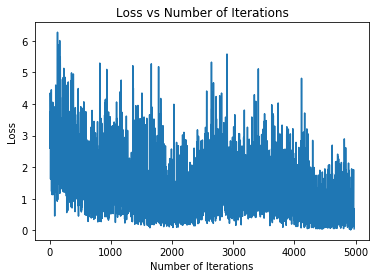

In [5]:
plt.title('Loss vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.plot(gd_iterations, avg_losses)
plt.show()

# Policy Rollout

In [6]:
def make_graphs(xs, a1s, a2s, steps):
    
    # plotting
    fig1 = plt.figure(1)
    fig1.suptitle('Policy Rollout')
    ax1 = fig1.add_subplot(311)
    ax2 = fig1.add_subplot(312)
    ax3 = fig1.add_subplot(313)
    fig2 = plt.figure(2)
    fig2.suptitle('a1 vs a2')
    ax4 = fig2.add_subplot(111)
    
    ax1.plot(steps, xs, '.-')
    ax1.set_ylabel('x')
    ax1.set_xlabel('steps')
    ax2.plot(steps, a1s, '.-')
    ax2.set_ylabel('a1')
    ax2.set_xlabel('steps')
    ax3.plot(steps, a2s, '.-')
    ax3.set_ylabel('a2')
    ax3.set_xlabel('steps')
    ax4.plot(a1s,a2s,'.-')
    ax4.set_xlabel('a1')
    ax4.set_ylabel('a2')
    
    fig1.tight_layout()
    fig2.tight_layout()
    plt.tight_layout()
    plt.show()

In 1 th iteration the initial state is:  (-0.4951523112185967, -0.00188942966046457, 0.2562743421350251)
In 1 th iteration the chosen action is:  (-0.39269908169872414, 1.5707963267948966)
In 1 th iteration, the robot moved  2.04108541435  in x direction
In 2 th iteration the initial state is:  (-0.39916889792903976, -0.19823897050982664, 1.0416725055324734)
In 2 th iteration the chosen action is:  (1.5707963267948966, 1.5707963267948966)
In 2 th iteration, the robot moved  0.600772817632  in x direction
In 3 th iteration the initial state is:  (-0.53155973620278363, 0, 1.5707963267948966)
In 3 th iteration the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In 3 th iteration, the robot moved  -0.126942558586  in x direction
In 4 th iteration the initial state is:  (-0.48247235099044311, -0.098174770424681035, 1.4726215563702154)
In 4 th iteration the chosen action is:  (1.1780972450961724, 1.5707963267948966)
In 4 th iteration, the robot moved  0.124133853168  in x dir

In 34 th iteration the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In 34 th iteration, the robot moved  0.117082526761  in x direction
In 35 th iteration the initial state is:  (-0.63870396928726647, 0, 1.5707963267948966)
In 35 th iteration the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In 35 th iteration, the robot moved  -0.118232229598  in x direction
In 36 th iteration the initial state is:  (-0.5896165840749259, -0.098174770424681035, 1.4726215563702154)
In 36 th iteration the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In 36 th iteration, the robot moved  0.116556847596  in x direction
In 37 th iteration the initial state is:  (-0.64544840270398507, 0, 1.5707963267948966)
In 37 th iteration the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In 37 th iteration, the robot moved  -0.117637443635  in x direction
In 38 th iteration the initial state is:  (-0.5963610174916445, -0.098174770424681035, 1.47262155637021

In 68 th iteration the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In 68 th iteration, the robot moved  0.107441918222  in x direction
In 69 th iteration the initial state is:  (-0.75335933737148264, 0, 1.5707963267948966)
In 69 th iteration the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In 69 th iteration, the robot moved  -0.107412263814  in x direction
In 70 th iteration the initial state is:  (-0.70427195215914207, -0.098174770424681035, 1.4726215563702154)
In 70 th iteration the chosen action is:  (1.3744467859455343, 1.5707963267948966)
In 70 th iteration, the robot moved  0.106829553004  in x direction
In 71 th iteration the initial state is:  (-0.76010377078820124, 0, 1.5707963267948966)
In 71 th iteration the chosen action is:  (-0.19634954084936207, -0.19634954084936207)
In 71 th iteration, the robot moved  -0.10673038509  in x direction
In 72 th iteration the initial state is:  (-0.71101638557586067, -0.098174770424681035, 1.4726215563702

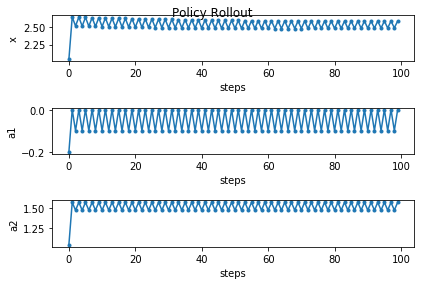

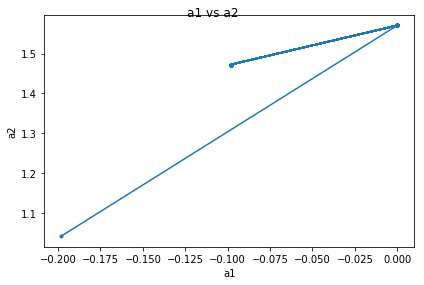

In [9]:
TIMESTEPS = 100
xs = []
a1s = []
a2s = []
steps = []
dx = 0
robot = ThreeLinkRobot(t_interval=0.5)
robot.randomize_state(enforce_opposite_angle_signs=True)
for i in range(TIMESTEPS):

    # rollout
    state = robot.state
    print('In', i+1, 'th iteration the initial state is: ', state)
    old_x = robot.x
    action = agent.choose_action(robot, state)
    print('In', i+1, 'th iteration the chosen action is: ', action)
    robot.move(action=action)
    new_x = robot.x
    print('In', i+1, 'th iteration, the robot moved ', new_x - old_x, ' in x direction')
    dx += (new_x-old_x)

    # add values to lists
    xs.append(dx)
    a1s.append(robot.a1)
    a2s.append(robot.a2)
    steps.append(i)

# plotting
make_graphs(xs,a1s,a2s,steps)
